# Capstone Project
## Using Machine Learning in Trading Futures

Cell below is loading data obtained from [quandl.com](https://quandl.com). You can check how the resulting csv file was produced from raw trading data of futures contracts across multiple years. Workbook data-preparation.ipynb contains all the code.

In [2]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

fee = 1.5

delta = 0.95
account_size = 10000
stop_loss = 550

trading_days_in_year = 252

start_date = datetime.date(year=2006, month=6, day=13)
end_date = datetime.date(year=2018, month=12, day=30)
validation_date = datetime.date(year=2018, month=1, day=1)

gold = pd.read_csv('data/gold_daily.csv', index_col='Date')
gold_cot = pd.read_csv('data/gold_cot.csv', index_col='Date')

corn = pd.read_csv('data/corn_daily.csv', index_col='Date')
corn_cot = pd.read_csv('data/corn_cot.csv', index_col='Date')

coffee = pd.read_csv('data/coffee_daily.csv', index_col='Date')
coffee_cot = pd.read_csv('data/coffee_cot.csv', index_col='Date')

dow = pd.read_csv('data/dow_daily.csv', index_col='Date')
nasdaq = pd.read_csv('data/nasdaq_daily.csv', index_col='Date')

Convert index to date type.

In [3]:
gold.index = pd.DatetimeIndex(data=gold.index)
gold_cot.index = pd.DatetimeIndex(data=gold_cot.index)

corn.index = pd.DatetimeIndex(data=corn.index)
corn_cot.index = pd.DatetimeIndex(data=corn_cot.index)

coffee.index = pd.DatetimeIndex(data=coffee.index)
coffee_cot.index = pd.DatetimeIndex(data=coffee_cot.index)

dow.index = pd.DatetimeIndex(data=dow.index)
nasdaq.index = pd.DatetimeIndex(data=nasdaq.index)

Ensure that dataframe is sorted by index (date).

In [4]:
gold = gold.sort_index(kind='mergesort')
gold_cot = gold_cot.sort_index(kind='mergesort')
corn = corn.sort_index(kind='mergesort')
corn_cot = corn_cot.sort_index(kind='mergesort')
coffee = coffee.sort_index(kind='mergesort')
coffee_cot = coffee_cot.sort_index(kind='mergesort')
dow = dow.sort_index(kind='mergesort')
nasdaq = nasdaq.sort_index(kind='mergesort')

Remove older dataframe - because we are missing COT.

In [5]:
gold = gold.loc[gold.index >= '2006-06-13']
corn = corn.loc[corn.index >= '2006-06-13']
coffee = coffee.loc[coffee.index >= '2006-06-13']

In [6]:
gold_cot.head(10)

,Open Interest,Producer/Merchant/Processor/User Longs,Producer/Merchant/Processor/User Shorts,Swap Dealer Longs,Swap Dealer Shorts,Swap Dealer Spreads,Money Manager Longs,Money Manager Shorts,Money Manager Spreads,Other Reportable Longs,Other Reportable Shorts,Other Reportable Spreads,Total Reportable Longs,Total Reportable Shorts,Non Reportable Longs,Non Reportable Shorts
Date,,,,,,,,,,,,,,,,
2006-06-13,382474.0,42587.0,128892.0,19370.0,66611.0,22998.0,103211.0,30916.0,46704.0,33230.0,10656.0,58412.0,326513.0,365190.0,55961.0,17284.0
2006-06-20,390281.0,47440.0,126992.0,22404.0,64682.0,25806.0,94632.0,30963.0,48730.0,32947.0,11142.0,64458.0,336417.0,372774.0,53864.0,17507.0
2006-06-27,384321.0,48449.0,121890.0,22425.0,62640.0,25151.0,91042.0,32287.0,49614.0,31307.0,11386.0,59762.0,327749.0,362729.0,56572.0,21592.0
2006-07-03,392868.0,48087.0,122568.0,22720.0,69714.0,26352.0,92545.0,30452.0,50821.0,32874.0,8677.0,63514.0,336914.0,372098.0,55955.0,20771.0
2006-07-11,427008.0,54509.0,130618.0,21840.0,79217.0,28805.0,104213.0,27624.0,54922.0,33165.0,11194.0,70944.0,368398.0,403323.0,58611.0,23685.0
2006-07-18,443519.0,49863.0,131166.0,21681.0,83183.0,33352.0,107413.0,24296.0,62395.0,31760.0,9442.0,74272.0,380737.0,418105.0,62782.0,25414.0
2006-07-25,432413.0,52859.0,133290.0,22956.0,85604.0,28832.0,99087.0,22386.0,64810.0,29740.0,6244.0,73980.0,372265.0,415146.0,60148.0,17266.0
2006-08-01,394609.0,45161.0,135988.0,21250.0,73244.0,23643.0,99330.0,24391.0,54618.0,32195.0,4758.0,57618.0,333815.0,374260.0,60795.0,20350.0
2006-08-08,402899.0,46203.0,142240.0,20703.0,72061.0,24259.0,104600.0,24271.0,57785.0,33123.0,6489.0,57914.0,344587.0,385020.0,58312.0,17880.0


### COT Feature engineering
Determine how far we are from top across last 2 years (730 days).

In [7]:
def percentage_from_max(sr):
    mx = sr.max()
    mn = sr.min()
    return (sr[-1]-mn)/(mx-mn)

def max_positions_percentage(df):
    df['Prod_net_position'] = df['Producer/Merchant/Processor/User Longs'] - df['Producer/Merchant/Processor/User Shorts']
    df['Prod_net_position_perc'] = df.rolling('730d')['Prod_net_position'].apply(percentage_from_max, raw=False)
    df['Money_manager_net_position'] = df['Money Manager Longs'] - df['Money Manager Shorts']
    df['Money_manager_net_position_perc'] = df.rolling('730d')['Money_manager_net_position'].apply(percentage_from_max, raw=False)
    df = df[['Prod_net_position_perc', 'Money_manager_net_position_perc']]
    return df

In [8]:
gold_cot = max_positions_percentage(gold_cot)
corn_cot = max_positions_percentage(corn_cot)
coffee_cot = max_positions_percentage(coffee_cot)

### Williams %R
Create feature with Williams %R indicator

In the end I decided not to use any indicator.

In [9]:
# code from stockstats pypy package
def get_wr(df, n_days):
    """ Williams Overbought/Oversold Index
    WMS=[(Hn—Ct)/(Hn—Ln)] ×100
    Ct - the close price
    Hn - N days high
    Ln - N days low
    :param df: data
    :param n_days: N days
    :return: None
    """
    n_days = int(n_days)
    ln = df['Low'].rolling(min_periods=1, window=n_days,
                           center=False).min()
    hn = df['High'].rolling(min_periods=1, window=n_days,
                            center=False).max()
    column_name = 'wr_{}'.format(n_days)
    column_name = 'wr'
    df[column_name] = (hn - df['Settle']) / (hn - ln) * 100

### Create Targets
Based on the threshold, fee and delta calculate targets used for supervised learning.

In [10]:
def calculate_target(row, threshold):
    global fee, delta, stop_loss
    volatility = (row['Settle']-row['Open'])*delta
    if abs(volatility) > fee + threshold:
        if volatility > 0:
            return 1
        else:
            return -1
    else:
        return 0
    return df


def create_trade_outcomes(df, contracts, threshold):
    ans_df = pd.DataFrame([])
    ans_df['gains'] = (df['Settle'] - df['Open'])*0.95*contracts
    ans_df = pd.concat([ans_df, df[['Open', 'High', 'Low', 'Settle']]*contracts], axis=1)
    ans_df['target'] = ans_df.apply(lambda x: calculate_target(x, threshold), axis=1)
    print(ans_df.head(5))
    return ans_df.shift(-1)

In [11]:
threshold = 500
contracts = 100
gold_gains = create_trade_outcomes(gold, contracts, threshold)
gold_gains_train = gold_gains.loc[gold_gains.index < '2018-1-1']
# gold_gains.head(20)

             gains     Open     High      Low   Settle  target
Date                                                          
2006-06-13 -2251.5  59050.0  59500.0  56550.0  56680.0      -1
2006-06-14  -332.5  57000.0  57550.0  56540.0  56650.0       0
2006-06-15  -304.0  57350.0  57950.0  56950.0  57030.0       0
2006-06-16    47.5  58120.0  58250.0  57050.0  58170.0       0
2006-06-19   -38.0  57280.0  57840.0  57100.0  57240.0       0


In [12]:
# get_wr(gold, 14)
gold = pd.concat([gold, gold_gains[['target']]], axis=1)
gold.head(15)

,Open,High,Low,Settle,Volume,Prev. Day Open Interest,target
Date,,,,,,,
2006-06-13,590.5,595.0,565.5,566.8,93899.0,192616.0,0.0
2006-06-14,570.0,575.5,565.4,566.5,68729.0,192917.0,0.0
2006-06-15,573.5,579.5,569.5,570.3,52628.0,193887.0,0.0
2006-06-16,581.2,582.5,570.5,581.7,43947.0,189585.0,0.0
2006-06-19,572.8,578.4,571.0,572.4,27362.0,189168.0,1.0
2006-06-20,572.0,581.0,567.8,580.5,39962.0,187696.0,1.0
2006-06-21,577.0,591.5,573.5,591.0,43918.0,187072.0,0.0
2006-06-22,588.0,593.5,584.5,585.4,42916.0,187027.0,1.0
2006-06-23,574.5,589.0,574.5,588.0,33705.0,181290.0,0.0


### Trade gains investigation

Ivestigate trade gains
- have a look at all gains (regardless of label)
- analyze gains for long trades (label 1)
- analyze gains for short trades (label -1)

### Trade labels distribution

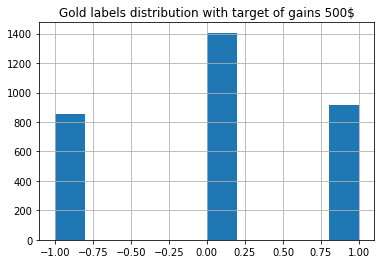

In [13]:
from matplotlib.pyplot import savefig

ax = gold['target'].hist()
ax.set_title('Gold labels distribution with target of gains 500$')
savefig('figures/gold_target_distribution.eps')

In [14]:
gold_gains_train.gains.describe()

count     2921.000000
mean        -6.878637
std       1225.716089
min     -11390.500000
25%       -560.500000
50%         28.500000
75%        627.000000
max       6555.000000
Name: gains, dtype: float64

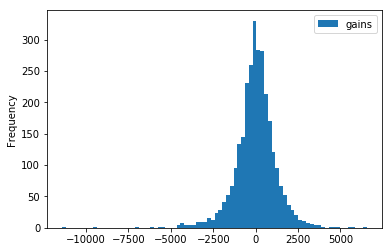

In [15]:
gold_gains_train[['gains']].plot.hist(bins=80)

In [16]:
def stop_loss_gen(df):
    df['Open_High'] = df['High'] - df['Open']
    df['Open_Low'] = df['Open'] - df['Low']
    return df

In [17]:
gold_gains_train = stop_loss_gen(gold_gains_train)

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [18]:
def plot_histogram_cumsum(df, column):
    df[column].hist(bins=50, density=True, cumulative=-1, figsize=(10,5))
    df[column].hist(bins=50, density=True, linewidth=1.5, cumulative=True, histtype='step', figsize=(10,5))
    ax = plt.plot([0, df[column].max()], [0.9, 0.9], lw=1, color='r')
    return ax

### Investigate suitable stop-loss value

Below are cumulative curves.
Red line denotes 90% mark. What stop-loss should you use when you want 90% of trades to get completed (trade from open  to close)?

Following curves are investigating stop losses based on the label.

| trade | commodity | stop loss |
|-------|-----------|-----------|
| long  |      gold |      1000 |
| short |      gold |       800 |
| long  |      corn |       300 |
| short |      corn |       300 |
| long  |    coffee |       800 |
| short |    coffee |       800 |



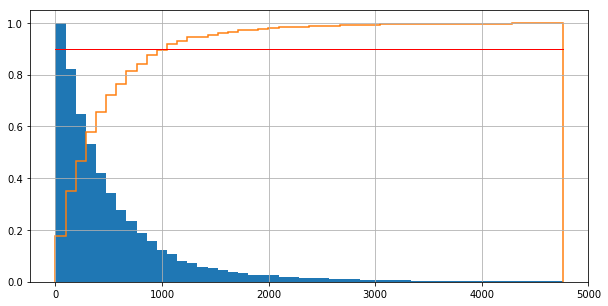

In [19]:
ax = plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == 1], 'Open_Low')
# print(type(ax[0]))
# print(type(ax))
# ax.set_title('Gold stop loss long trades')
savefig('figures/gold_stop_loss_long_trades.eps')

In [20]:
gold_gains_train[gold_gains_train.target == 1].Open_Low.describe()

count     860.000000
mean      472.825581
std       538.691375
min         0.000000
25%       130.000000
50%       310.000000
75%       640.000000
max      4760.000000
Name: Open_Low, dtype: float64

In [21]:
gold_gains_train[gold_gains_train.target == -1].Open_High.describe()

count     802.000000
mean      429.077307
std       439.462157
min         0.000000
25%       150.000000
50%       310.000000
75%       570.000000
max      4380.000000
Name: Open_High, dtype: float64

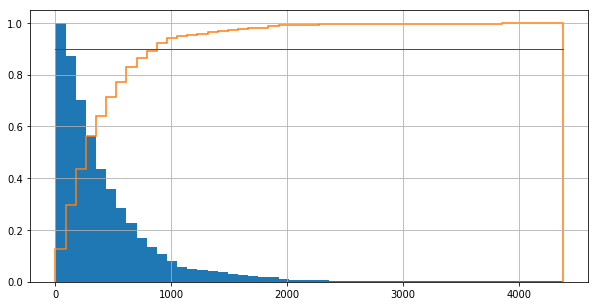

In [22]:
plot_histogram_cumsum(gold_gains_train[gold_gains_train.target == -1], 'Open_High')
savefig('figures/gold_stop_loss_short_trades.eps')

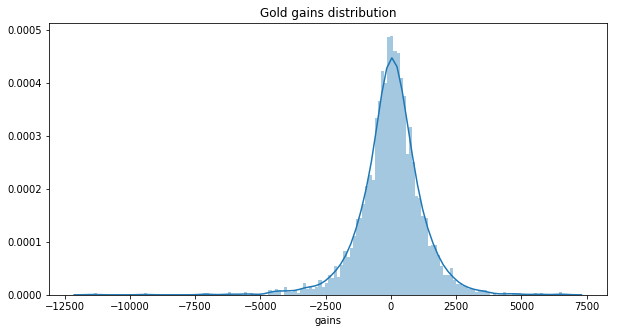

In [23]:
sr = gold_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, bins=150, ax=ax)
ax.set_title('Gold gains distribution')
savefig('figures/gold_gains_distribution.eps')

In [24]:
# Corn Contract has 5000 bushels contract is in cents therefore 50 contracts are producing desired values
contracts = 50
threshold = 150
corn_gains = create_trade_outcomes(corn, contracts, threshold)
corn_gains_train = corn_gains.loc[corn_gains.index < '2018-1-1']

              gains     Open     High      Low   Settle  target
Date                                                           
2006-06-13 -213.750  12387.5  12400.0  12112.5  12162.5      -1
2006-06-14 -332.500  12200.0  12262.5  11837.5  11850.0      -1
2006-06-15 -213.750  11875.0  11937.5  11600.0  11650.0      -1
2006-06-16   71.250  12987.5  13137.5  12962.5  13062.5       0
2006-06-19 -154.375  12950.0  13050.0  12750.0  12787.5      -1


In [25]:
corn_gains_train.gains.describe()

count    2917.000000
mean        6.122729
std       411.069273
min     -1983.125000
25%      -190.000000
50%        11.875000
75%       213.750000
max      1888.125000
Name: gains, dtype: float64

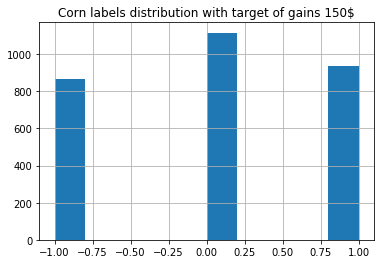

In [26]:
# get_wr(corn, 14)
corn = pd.concat([corn, corn_gains[['target']]], axis=1)

ax = corn.loc[corn.index < '2018-1-1'].target.hist()
ax.set_title('Corn labels distribution with target of gains 150$')
savefig('figures/corn_target_distribution.eps')

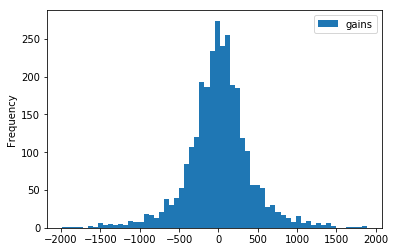

In [27]:
ax = corn_gains_train[['gains']].plot.hist(bins=60)

In [28]:
corn_gains_train.head(10)

,gains,Open,High,Low,Settle,target
Date,,,,,,
2006-06-13,-332.500,12200.0,12262.5,11837.5,11850.0,-1.0
2006-06-14,-213.750,11875.0,11937.5,11600.0,11650.0,-1.0
2006-06-15,71.250,12987.5,13137.5,12962.5,13062.5,0.0
2006-06-16,-154.375,12950.0,13050.0,12750.0,12787.5,-1.0
2006-06-19,-23.750,12825.0,12837.5,12675.0,12800.0,0.0
2006-06-20,142.500,12800.0,12975.0,12775.0,12950.0,0.0
2006-06-21,-95.000,12950.0,13025.0,12800.0,12850.0,0.0
2006-06-22,-83.125,12850.0,12887.5,12737.5,12762.5,0.0
2006-06-23,-225.625,12687.5,12687.5,12387.5,12450.0,-1.0


In [29]:
corn_gains = stop_loss_gen(corn_gains)
corn_gains_train = corn_gains[corn_gains.index < '2018-1-1']

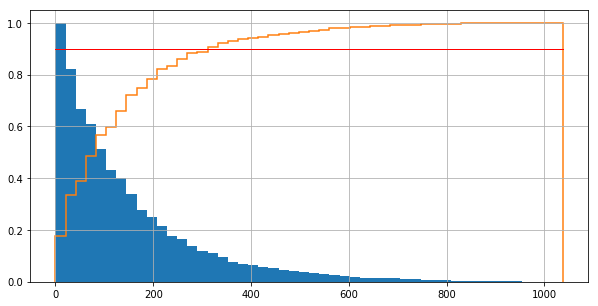

In [30]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == 1], 'Open_Low')
savefig('figures/corn_stop_loss_long_trades.eps')

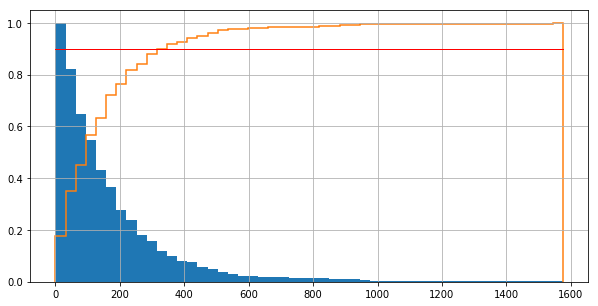

In [31]:
plot_histogram_cumsum(corn_gains_train[corn_gains_train.target == -1], 'Open_High')
savefig('figures/corn_stop_loss_short_trades.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


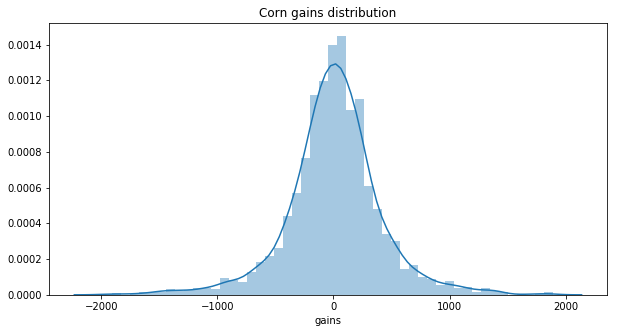

In [32]:
sr = corn_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Corn gains distribution')
savefig('figures/corn_gains_distribution.eps')

/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


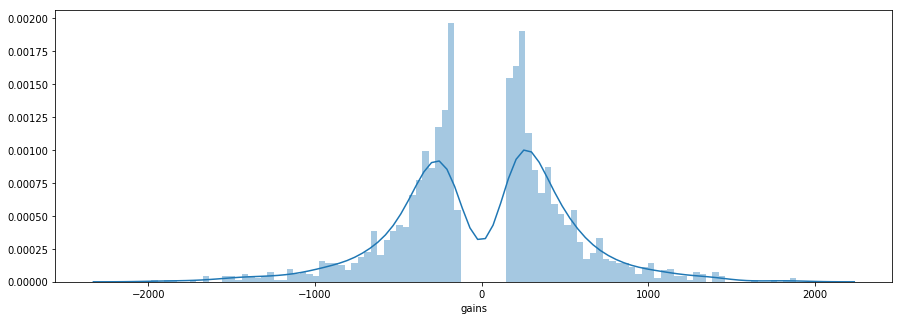

In [33]:
sr = corn_gains_train[corn_gains.gains.abs() > 150].gains
fig, ax = plt.subplots(figsize=(15,5))
sns.distplot(sr, bins=100, ax=ax)

In [34]:
# coffee contract size is 37,500 pounds price is in cents per pound
contracts = 375
threshold = 275
coffee_gains = create_trade_outcomes(coffee, contracts, threshold)
coffee_gains = stop_loss_gen(coffee_gains)
coffee_gains_train = coffee_gains.loc[coffee_gains.index < '2018-1-1']

            gains      Open     High      Low    Settle  target
Date                                                           
2006-06-13    0.0  36731.25  37050.0  36712.5  36731.25       0
2006-06-14    0.0  36918.75  37275.0  36600.0  36918.75       0
2006-06-15    0.0  37106.25  37425.0  36937.5  37106.25       0
2006-06-16    0.0  36637.50  37350.0  36337.5  36637.50       0
2006-06-19    0.0  36468.75  36712.5  36375.0  36468.75       0


In [35]:
coffee_gains_train.gains.describe()

count    2908.000000
mean      -11.546273
std      1070.462227
min     -5236.875000
25%      -516.562500
50%         0.000000
75%       498.750000
max      6341.250000
Name: gains, dtype: float64

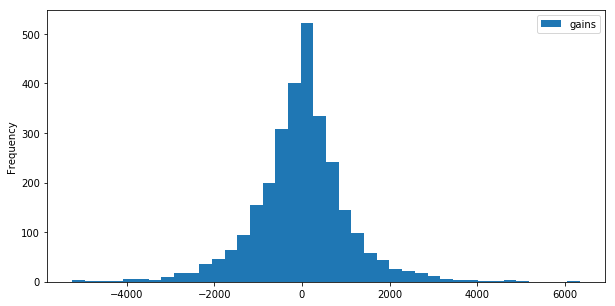

In [36]:
coffee_gains_train[['gains']].plot.hist(bins=40, figsize=(10, 5))

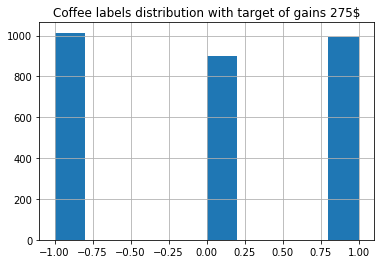

In [37]:
# get_wr(coffee, 14)
coffee = pd.concat([coffee, coffee_gains[['target']]], axis=1)
ax = coffee.loc[coffee.index < '2018-1-1'].target.hist()
ax.set_title('Coffee labels distribution with target of gains 275$')
savefig('figures/coffee_target_distribution.eps')

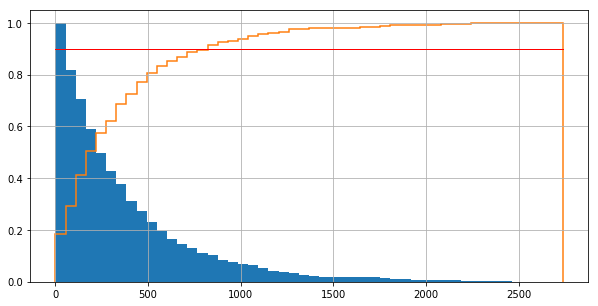

In [38]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == 1], 'Open_Low')
savefig('figures/coffee_stop_loss_long_trades.eps')

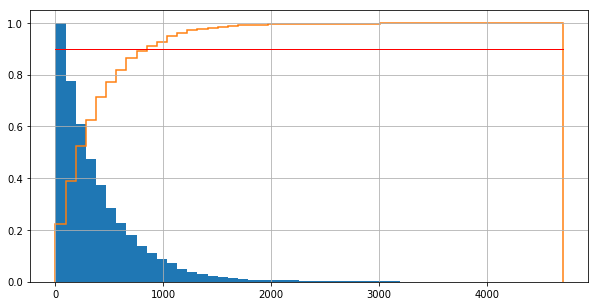

In [39]:
plot_histogram_cumsum(coffee_gains_train[coffee_gains_train.target == -1], 'Open_High')
savefig('figures/coffee_stop_loss_short_trades.eps')

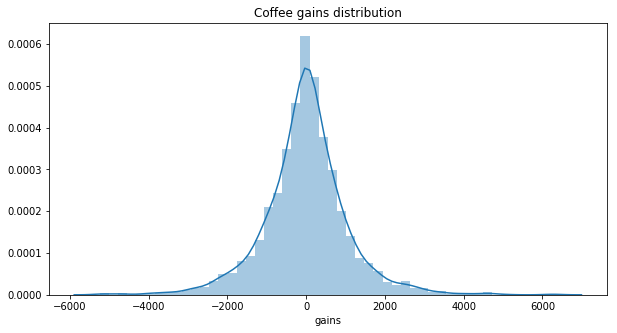

In [40]:
sr = coffee_gains_train.gains
fig, ax = plt.subplots(figsize=(10,5))
sns.distplot(sr, ax=ax)
ax.set_title('Coffee gains distribution')
savefig('figures/coffee_gains_distribution.eps')

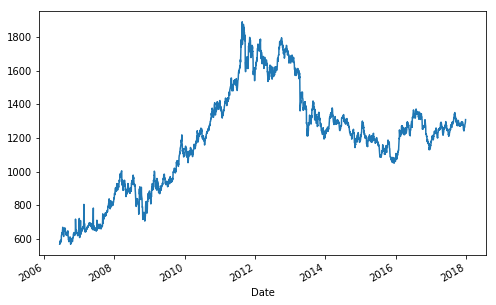

In [41]:
ax = gold.loc[gold.index < '2018-01-01']['Settle'].plot(figsize=(8, 5))
savefig('figures/gold.eps')

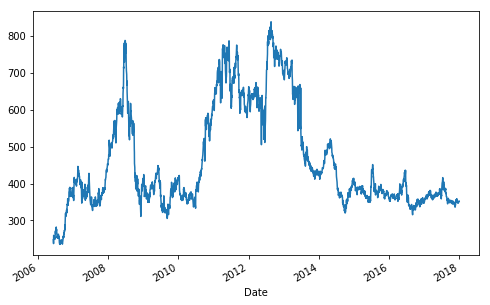

In [42]:
corn.loc[corn.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/corn.eps')

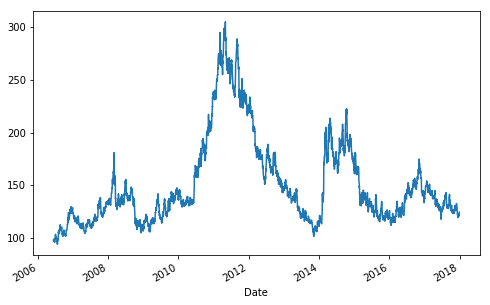

In [43]:
coffee.loc[coffee.index < '2018-01-01']['Open'].plot(figsize=(8, 5))
savefig('figures/coffee.eps')

# Feature Engineering

Code below create date features. In order to capture cyclicality I have transformed features as trading day of month or day of week into $sin$ and $cos$ values.
I am not sure whether this transformation grants subsequent PCA usage.

In [44]:
import numpy as np
import holidays

def trading_day_of_month(tm):
    ts = (tm - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
    dt = datetime.datetime.fromtimestamp(ts)
    di = datetime.date(year=dt.year, month=dt.month, day=1)
    us_holidays = holidays.UnitedStates()
    cnt = 1
    for i in range(1, 32):
        if i == dt.day:
            break
        if di.weekday() in [0, 1, 2, 3, 4] and dt not in us_holidays:
            cnt += 1
        di += datetime.timedelta(days=1)
    return cnt


def create_cycle(x, period):
    sn = np.sin(x*(2.*np.pi/period))
    cs = np.cos(x*(2.*np.pi/period))
    return sn, cs


def create_vectors(df, df_cot):
    global trading_days_in_year
    nv = df.shape[1]-2
    i_t = df.shape[1]-1
    ans_dct = {}
    for i in range(df.shape[0]):
        if i < 2*trading_days_in_year:
            continue
        mtrx = df.iloc[i-2*trading_days_in_year:i, 0:nv].values
        size = np.prod(mtrx.shape)
        mtrx = list(mtrx.reshape(size))
        idx = df.index.values[i]
        # add COT report to the end of list
        mtrx_cot = df_cot[df_cot.index < idx].values[-8:]
        size = np.prod(mtrx_cot.shape)
        mtrx_cot = list(mtrx_cot.reshape(size))
        if size < 16:
            mtrx_cot += [0 for i in range(16-size)]
        # Date Features
        ts = (idx - np.datetime64('1970-01-01')) / np.timedelta64(1, 's')
        dt = datetime.datetime.fromtimestamp(ts)
        wsn, wcs = create_cycle(dt.weekday(), 5)
        # period for trading day in month is at most 23
        tsn, tcs = create_cycle(trading_day_of_month(idx), 23)
        dsn, dcs = create_cycle(dt.month, 12)
        qsn, qcs = create_cycle((dt.month-1)//3, 4)
        mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs]
        # mtrx_date = [wsn, wcs, tsn, tcs, dsn, dcs, qsn, qcs, df.loc[idx].wr]
        # mtrx_date = [dt.weekday(), trading_day_of_month(idx), dt.month, (dt.month-1)//3, df.loc[idx].wr]
        # Combine list
        mtrx = mtrx + mtrx_cot + mtrx_date
        mtrx.append(df.iloc[i, i_t])
        ans_dct[idx] = mtrx
    return pd.DataFrame.from_dict(ans_dct, orient='index')

In [45]:
gold_data = create_vectors(gold, gold_cot)
gold_data = gold_data.loc[:end_date]
corn_data = create_vectors(corn, corn_cot)
corn_data = corn_data.loc[:end_date]
coffee_data = create_vectors(coffee, coffee_cot)
coffee_data = coffee_data.loc[:end_date]

cols = list(range(2544))
gold_data_reg = gold_data[cols].join(gold_gains[['gains']].rename(columns={"gains": 2544}))
corn_data_reg = corn_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))
coffee_data_reg = coffee_data[cols].join(corn_gains[['gains']].rename(columns={"gains": 2544}))

In [46]:
gold_data.tail()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2018-12-21,1134.0,1138.8,1131.0,1133.2,110023.0,1133.2,1135.5,1128.6,1130.7,115561.0,...,0.346733,-0.951057,0.309017,-0.816970,-0.576680,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-24,1133.2,1135.5,1128.6,1130.7,115561.0,1130.0,1137.3,1129.5,1133.6,71039.0,...,0.346733,0.000000,1.000000,-0.942261,-0.334880,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-26,1130.0,1137.3,1129.5,1133.6,71039.0,1135.3,1151.7,1132.8,1138.8,102763.0,...,0.346733,0.587785,-0.809017,-0.979084,0.203456,-2.449294e-16,1.0,-1.0,-1.836970e-16,1.0
2018-12-27,1135.3,1151.7,1132.8,1138.8,102763.0,1139.3,1145.1,1137.1,1140.9,100470.0,...,0.346733,-0.587785,-0.809017,-0.887885,0.460065,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0
2018-12-28,1139.3,1145.1,1137.1,1140.9,100470.0,1143.1,1160.6,1142.6,1158.1,153065.0,...,0.346733,-0.951057,0.309017,-0.730836,0.682553,-2.449294e-16,1.0,-1.0,-1.836970e-16,0.0


In [47]:
gold_data_reg.head()

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-760.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-2213.5
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1111.5
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1092.5
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,199.5


Removing Nan from data

In [48]:
gold_data.shape

(2668, 2545)

In [49]:
gold_data = gold_data.dropna()
gold_data.shape

(2668, 2545)

In [50]:
print(corn_data.shape)
corn_data = corn_data.dropna()
corn_data.shape

(2664, 2545)


(2664, 2545)

In [51]:
print(coffee_data.shape)
coffee_data = coffee_data.dropna()
coffee_data.shape

(2655, 2545)


(2655, 2545)

In [52]:
print(gold_data_reg.shape)
gold_data_reg = gold_data_reg.dropna()
gold_data_reg.shape

(2668, 2545)


(2668, 2545)

In [53]:
print(corn_data_reg.shape)
corn_data_reg = corn_data_reg.dropna()
corn_data_reg.shape

(2664, 2545)


(2664, 2545)

In [54]:
print(coffee_data_reg.shape)
coffee_data_reg = coffee_data_reg.dropna()
coffee_data_reg.shape

(2655, 2545)


(2654, 2545)

In [55]:
gold_cot.head(5)

,Prod_net_position_perc,Money_manager_net_position_perc
Date,,
2006-06-13,NaN,NaN
2006-06-20,1.000000,0.000000
2006-06-27,1.000000,0.000000
2006-07-03,0.919154,0.246529
2006-07-11,0.792600,1.000000


In [56]:
gold_data = gold_data.loc[gold_data.index >= '2007-01-01']
corn_data = corn_data.loc[corn_data.index >= '2007-01-01']
coffee_data = coffee_data.loc[coffee_data.index >= '2007-01-01']

gold_data_reg = gold_data_reg.loc[gold_data_reg.index >= '2007-01-01']
corn_data_reg = corn_data_reg.loc[corn_data_reg.index >= '2007-01-01']
coffee_data_reg = coffee_data_reg.loc[coffee_data_reg.index >= '2007-01-01']

In [57]:
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.decomposition import FactorAnalysis

validate_date = '2018-01-01'


def data_split_pca_transform(df):
    global validate_date
    label_index = 2544
    df_validate = df.loc[validate_date <= df.index]
    df_data_tt = df.loc[validate_date > df.index]
    df_train, df_test, label_train, label_test = train_test_split(df_data_tt[list(range(label_index))], df_data_tt[label_index], test_size=0.2, random_state=2242)
    
    pca = PCA(n_components=200, random_state=2234)
    # pca = FactorAnalysis(n_components=5, random_state=2234)
    pca.fit(df_train[list(range(label_index))])
    
    return df_train, df_test, label_train, label_test, df_validate[list(range(label_index))], df_validate[label_index], pca


def pca_transform(df, pca):
    label_index = 2544
    df_pca = pca.transform(df[list(range(label_index))])
    
    return df_pca

In [58]:
gold_train, gold_test, gold_label_train, gold_label_test, gold_validate, gold_label_validate, gold_pca = data_split_pca_transform(gold_data)
corn_train, corn_test, corn_label_train, corn_label_test, corn_validate, corn_label_validate, corn_pca = data_split_pca_transform(corn_data)
coffee_train, coffee_test, coffee_label_train, coffee_label_test, coffee_validate, coffee_label_validate, coffee_pca = data_split_pca_transform(coffee_data)

gold_reg_train, gold_reg_test, gold_reg_label_train, gold_reg_label_test, gold_reg_validate, gold_reg_label_validate, gold_reg_pca = data_split_pca_transform(gold_data_reg)
corn_reg_train, corn_reg_test, corn_reg_label_train, corn_reg_label_test, corn_reg_validate, corn_reg_label_validate, corn_reg_pca = data_split_pca_transform(corn_data_reg)
coffee_reg_train, coffee_reg_test, coffee_reg_label_train, coffee_reg_label_test, coffee_reg_validate, coffee_reg_label_validate, coffee_reg_pca = data_split_pca_transform(coffee_data_reg)

# Outlier detection
The code below is using random forest. I am relying on automatic outlier detection.

In [59]:
from sklearn.ensemble import IsolationForest
# from sklearn.neighbors import LocalOutlierFactor

pca_gold = pca_transform(gold_train, gold_pca)
out_gold = IsolationForest(contamination='auto', behaviour='new', random_state=428)
modified_gold = out_gold.fit_predict(pca_gold)

pca_corn = pca_transform(corn_train, corn_pca)
out_corn = IsolationForest(contamination='auto', behaviour='new', random_state=912)
modified_corn = out_corn.fit_predict(pca_corn)

pca_coffee = pca_transform(coffee_train, coffee_pca)
out_coffee = IsolationForest(contamination='auto', behaviour='new', random_state=832)
modified_coffee = out_coffee.fit_predict(pca_coffee)


def remove_outliers(arr, y, isolation):
    lst = out_gold.predict(X)
    a = []
    y_a = []
    for v, h, k in zip(lst, y, X):
        if v == 1:
            a.append(k)
            y_a.append(h)
    a = np.array(a)
    y_a = np.array(y_a)
    return a, y_a

In [60]:
def plot_hist_perc(x):
    df = pd.DataFrame(x)

    ln = df[0].count()
    dct = {}
    dct[-1] = df[df[0] == -1][0].count() / ln
    dct[1] = df[df[0] == 1][0].count() / ln
    
    print('outliers: ' + str(df[df[0] == -1][0].count()))
    print('inliers: ' + str(df[df[0] == 1][0].count()))

    rf = pd.DataFrame.from_dict(dct, orient='index')

    ax = rf.plot(kind='bar', figsize=(10,5), legend=False)
    for i in ax.patches:
        ax.text(i.get_x()-.2, i.get_height()-.05, \
                str(round(i.get_height(),4)), fontsize=15)

outliers: 6
inliers: 1927


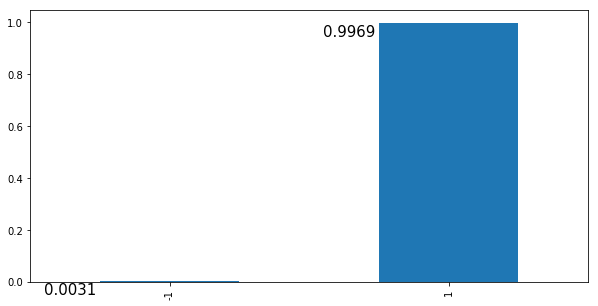

In [61]:
plot_hist_perc(modified_gold)
savefig('figures/gold_outliers.eps')

In [62]:
gold_out = []

for v in pca_gold:
    [p] = out_gold.predict([v])
    if p != 1:
        gold_out.append(v)

In [63]:
gold_out_orig = []

for index, row in gold_train.iterrows():
    [nv] = pca_transform(gold_train.loc[[index]], gold_pca)
    check = [1 for v in gold_out if np.allclose(v, nv)]
    if check:
        print(index)
        gold_out_orig.append(v)

2017-09-25 00:00:00
2017-11-14 00:00:00
2017-11-20 00:00:00
2017-12-05 00:00:00
2017-12-22 00:00:00
2017-12-12 00:00:00


outliers: 15
inliers: 1915


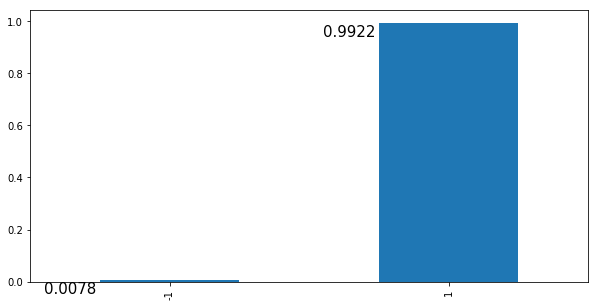

In [64]:
plot_hist_perc(modified_corn)
savefig('figures/corn_outliers.eps')

In [65]:
corn_out = []

for v in pca_corn:
    [p] = out_corn.predict([v])
    if p != 1:
        corn_out.append(v)
        
corn_out_orig = []

for index, row in corn_train.iterrows():
    [nv] = pca_transform(corn_train.loc[[index]], corn_pca)
    check = [1 for v in corn_out if np.allclose(v, nv)]
    if check:
        print(index)
        corn_out_orig.append(v)

2017-06-08 00:00:00
2017-09-28 00:00:00
2017-08-01 00:00:00
2017-03-24 00:00:00
2017-11-13 00:00:00
2017-09-01 00:00:00
2017-09-20 00:00:00
2017-10-30 00:00:00
2017-07-10 00:00:00
2017-06-16 00:00:00
2017-06-26 00:00:00
2017-10-10 00:00:00
2017-09-18 00:00:00
2017-11-02 00:00:00
2017-08-02 00:00:00


Coffee data contains unusually big number of outliers - maybe this could be modified by increasing number of PCA components.

outliers: 346
inliers: 1577


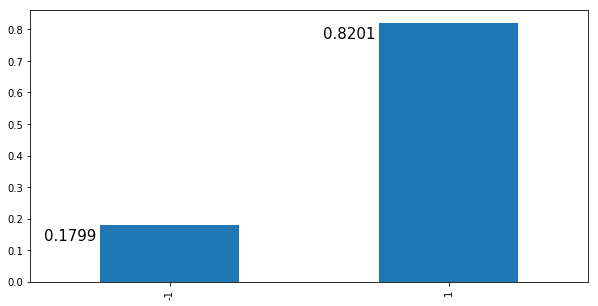

In [66]:
plot_hist_perc(modified_coffee)
savefig('figures/coffee_outliers.eps')

In [67]:
coffee_out = []

for v in pca_coffee:
    [p] = out_coffee.predict([v])
    if p != 1:
        coffee_out.append(v)
        
coffee_out_orig = []

for index, row in coffee_train.iterrows():
    [nv] = pca_transform(coffee_train.loc[[index]], coffee_pca)
    check = [1 for v in coffee_out if np.allclose(v, nv)]
    if check:
        print(index)
        coffee_out_orig.append(v)

2008-06-26 00:00:00
2010-01-07 00:00:00
2009-04-06 00:00:00
2008-08-28 00:00:00
2008-07-02 00:00:00
2008-11-25 00:00:00
2008-12-04 00:00:00
2008-09-16 00:00:00
2010-01-28 00:00:00
2009-08-12 00:00:00
2010-01-08 00:00:00
2008-09-15 00:00:00
2009-09-02 00:00:00
2009-02-09 00:00:00
2009-05-29 00:00:00
2009-07-20 00:00:00
2009-09-18 00:00:00
2009-07-08 00:00:00
2009-02-11 00:00:00
2008-11-03 00:00:00
2009-03-10 00:00:00
2009-12-10 00:00:00
2009-02-02 00:00:00
2009-04-01 00:00:00
2008-08-29 00:00:00
2009-02-20 00:00:00
2008-12-01 00:00:00
2008-12-24 00:00:00
2009-08-17 00:00:00
2009-06-25 00:00:00
2009-08-21 00:00:00
2010-03-02 00:00:00
2008-07-18 00:00:00
2009-08-19 00:00:00
2009-11-30 00:00:00
2008-12-19 00:00:00
2009-11-13 00:00:00
2009-09-08 00:00:00
2009-12-14 00:00:00
2009-06-18 00:00:00
2009-04-17 00:00:00
2009-10-23 00:00:00
2009-02-06 00:00:00
2009-11-03 00:00:00
2009-01-21 00:00:00
2009-05-28 00:00:00
2009-05-11 00:00:00
2008-12-30 00:00:00
2009-01-28 00:00:00
2008-10-20 00:00:00


In [68]:
def create_pca_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_long_validation.csv', index=False)
    train_df.to_csv(name + '_long_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: x if x >= 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_long_test.csv', index=False)

    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index < '2018-1-1'][2544].values)))
    gdf['label'] = gdf.label.astype(int)
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_short_validation.csv', index=False)
    train_df.to_csv(name + '_short_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = np.array(list(map(lambda x: 1 if x < 0 else 0, df.loc[df.index >= '2018-1-1'][2544].values)))
    gdf_test['label'] = gdf_test.label.astype(int)
    gdf_test.to_csv(name + '_short_test.csv', index=False)


def create_pca_reg_training(df, df_pca, name, validation=0.2):
    gdf = pd.DataFrame(pca_transform(df.loc[df.index < '2018-1-1'], df_pca))
    gdf['label'] = df.loc[df.index < '2018-1-1'][2544].values
    test_df = gdf.sample(frac=validation)
    test_df = test_df.reset_index()
    test_df = test_df.drop(columns=['index'])
    train_df = gdf.drop(test_df.index)
    train_df = train_df.reset_index()
    train_df = train_df.drop(columns=['index'])
    test_df.to_csv(name + '_validation.csv', index=False)
    train_df.to_csv(name + '_train.csv', index=False)
    
    gdf_test = pd.DataFrame(pca_transform(df.loc[df.index >= '2018-1-1'], df_pca))
    gdf_test['label'] = df.loc[df.index >= '2018-1-1'][2544].values
    gdf_test.to_csv(name + '_test.csv', index=False)


create_pca_training(gold_data, gold_pca, 'data/gold_pca')
create_pca_training(corn_data, corn_pca, 'data/corn_pca')
create_pca_training(coffee_data, coffee_pca, 'data/coffee_pca')

create_pca_reg_training(gold_data_reg, gold_pca, 'data/gold_pca_reg')
create_pca_reg_training(corn_data_reg, corn_pca, 'data/corn_pca_reg')
create_pca_reg_training(coffee_data_reg, coffee_pca, 'data/coffee_pca_reg')

### Dimension reduction with PCA

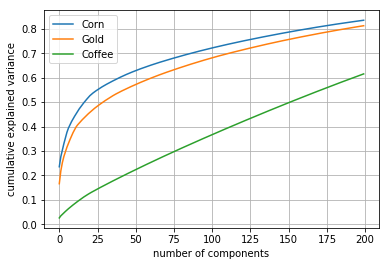

In [69]:
plt.plot(np.cumsum(corn_pca.explained_variance_ratio_), label='Corn')
plt.plot(np.cumsum(gold_pca.explained_variance_ratio_), label='Gold')
plt.plot(np.cumsum(coffee_pca.explained_variance_ratio_), label='Coffee')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.grid(True)
plt.legend()
# plt.show()
plt.savefig('figures/pca.eps')

It is interesting Corn is best explained by PCA transformation. It is probably due to clear seasonal patterns in trading.

I am surprised that gold is better explained by PCA transformation than Coffee. I would expect that coffee has stronger seasonal trading patterns than gold because of the growth cycle. Maybe gold mining is subject to the weather in similar way as agricultural commodities. Gold is still mostly recycled and new production has limited impact on total amount of traded gold.

Possible explanations:
- corn traded on CME is mostly US produced with stable harvest season
- production of coffee is very unpredictable depending on the conditions of a given year
- there are multiple producers around the world (coffee is more of a global market with limited US production) with different harvest periods https://driftaway.coffee/when-is-coffee-harvested/
- important difference between coffee and corn is price per unit corn is much less efficient to transport
    - 1 kg of corn is worth about 15¢
    - 1 kg of coffee is worth about 230¢
    
Based on this graph I think that PCA transformation is not suitable for coffee. Information in components is growing linearly. If we don't see sharp increase of cumulative explained variance with few first components, then PCA transformation is not suitable. Therefore, coffee should not be considered for trading. I will continue with coffee as well but based on this transformation I would not go ahead with trading unless I would find different transformation.

In [70]:
# np.cumsum(gold_pca.explained_variance_ratio_)[268]

In [71]:
gold_data.head(10)

,0,1,2,3,4,5,6,7,8,9,...,2535,2536,2537,2538,2539,2540,2541,2542,2543,2544
2008-06-06,590.5,595.0,565.5,566.8,93899.0,570.0,575.5,565.4,566.5,68729.0,...,0.698322,-0.951057,0.309017,0.979084,0.203456,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-09,570.0,575.5,565.4,566.5,68729.0,573.5,579.5,569.5,570.3,52628.0,...,0.698322,0.000000,1.000000,0.997669,-0.068242,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-10,573.5,579.5,569.5,570.3,52628.0,581.2,582.5,570.5,581.7,43947.0,...,0.698322,0.951057,0.309017,0.942261,-0.334880,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-11,581.2,582.5,570.5,581.7,43947.0,572.8,578.4,571.0,572.4,27362.0,...,0.584221,0.587785,-0.809017,0.816970,-0.576680,1.224647e-16,-1.0,1.0,6.123234e-17,-1.0
2008-06-12,572.8,578.4,571.0,572.4,27362.0,572.0,581.0,567.8,580.5,39962.0,...,0.584221,-0.587785,-0.809017,0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-13,572.0,581.0,567.8,580.5,39962.0,577.0,591.5,573.5,591.0,43918.0,...,0.584221,-0.951057,0.309017,0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-16,577.0,591.5,573.5,591.0,43918.0,588.0,593.5,584.5,585.4,42916.0,...,0.584221,0.000000,1.000000,0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,0.0
2008-06-17,588.0,593.5,584.5,585.4,42916.0,574.5,589.0,574.5,588.0,33705.0,...,0.584221,0.951057,0.309017,-0.136167,-0.990686,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-18,574.5,589.0,574.5,588.0,33705.0,586.2,589.5,580.0,587.7,30510.0,...,0.604415,0.587785,-0.809017,-0.398401,-0.917211,1.224647e-16,-1.0,1.0,6.123234e-17,1.0
2008-06-19,586.2,589.5,580.0,587.7,30510.0,589.5,599.0,583.7,584.4,47778.0,...,0.604415,-0.587785,-0.809017,-0.631088,-0.775711,1.224647e-16,-1.0,1.0,6.123234e-17,0.0


In [72]:
import os
import platform

print(platform.platform())

if platform.system() == 'Darwin':
    os.environ['KMP_DUPLICATE_LIB_OK']='True'

Linux-4.15.0-45-generic-x86_64-with-debian-buster-sid


In [73]:
def get_round_ceiling(sr):
    return (np.ceil(sr.max()+1000)//1000+1)*1000

In [74]:
from numpy import size
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score


def make_label(v, threshold, fee):
    if abs(v)-fee > threshold:
        if v > 0:
            return 1
        else:
            return -1
    return 0


def print_2d(f):
    return format(f, '.2f')


def earnings_per_trade(df):
    ans = 0
    if df[df.trade != 0].trade.count() != 0:
        ans = (df[df.trade != 0].gains.sum())/(df[df.trade != 0].trade.count())
    return ans


def earnings_per_shorts(df):
    ans = 0
    if df[df.trade == -1].trade.count() != 0:
        ans = (df[df.trade == -1].gains.sum())/(df[df.trade == -1].trade.count())
    return ans


def earnings_per_longs(df):
    ans = 0
    if df[df.trade == 1].trade.count() != 0:
        ans = (df[df.trade == 1].gains.sum())/(df[df.trade == 1].trade.count())
    return ans


def get_performance(model, pca, df_gains, df, labels, regression=False, target=200, stop_loss_long=1000, stop_loss_short=800, debug=False, name=''):
    df = pca_transform(df, pca)
    preds = model.predict(df)
    if regression and not np.isscalar(preds[0]):
        preds = np.reshape(preds, (preds.shape[0],))
    l = preds.shape[0]
    if regression:
        ax = sns.distplot(preds - df_gains.gains.values[:l], hist = False, kde = True,
                          kde_kws = {'shade': True, 'linewidth': 3}, axlabel="Residual")
        title = ax.set_title('Kernel density of residuals', size=15)
        savefig('figures/' + name + '_kernel_density_residuals.eps')
        fig1, ax1 = plt.subplots()
        ax1 = sns.scatterplot(x=preds, y=df_gains.gains.values[:l])
        ax1.set_xlabel('Predictions')
        ax1.set_ylabel('Actuals')
        title = ax1.set_title('Actual vs Prediction scatter plot', size=15)
        savefig('figures/' + name + '_actual_prediction.eps')
        print("Predictions/Actual volatility correlation: ", np.corrcoef(preds, df_gains.gains.values[:l])[0][1])
    # print("Predictions/Actual volatility correlation for : ", np.corrcoef(preds, df_gains.gains.values[:l][0][1]))
    if debug:
        print(preds)
    predictions = []
    for v in preds:
        if not regression:
            i = pd.Series(v).idxmax()
            if i == 0:
                predictions.append(0)
            elif i == 1:
                predictions.append(-1)
            else:
                predictions.append(1)
        else:
            if abs(v) > target:
                if v > 0:
                    predictions.append(1)
                else:
                    predictions.append(-1)
            else:
                predictions.append(0)
    return get_account(predictions, df_gains, labels, stop_loss_long, stop_loss_short, regression, name, target)


def get_account(predictions, df_gains, labels, stop_loss_long=1000, stop_loss_short=800, regression=False, name='', target=0):
    global account_size, fee
    acc = account_size
    dct = {}
    dct['account'] = [acc]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['short'] = [0]
    dct['long'] = [0]
    dct['trade'] = [0]
    dct['label'] = [0]
    dct['stop_loss'] = [0]
    dct['gains'] = [0]
    dct['predicted_value'] = [0]
    dct['true_value'] = [0]
    for p, l, v in zip(predictions, labels, df_gains.values):
        short = 0
        long = 0
        s_l = 0
        gains = 0
        if p == -1.0:
            short = 1
            if (v[2] - v[1]) > stop_loss_short:
                gains = -stop_loss
                s_l = 1
            else:
                gains = -v[0] - fee
        elif p == 1.0:
            long = 1
            if (v[1] - v[3]) > stop_loss_long:
                gains = -stop_loss
                s_l = 1
            else:
                gains = v[0] - fee
        else:
            pass
        acc += gains
        dct['account'].append(acc)
        dct['short'].append(short)
        dct['long'].append(long)
        dct['stop_loss'].append(s_l)
        dct['trade'].append(float(p))
        dct['label'].append(l)
        dct['gains'].append(gains)
        dct['predicted_value'].append(p)
        dct['true_value'].append(v[0])
        if acc <= 0:
            break
    rf = pd.DataFrame.from_dict(dct)
    rf['id'] = rf.index.values
    rf['trade_visual'] = rf.trade*1000
    ax1 = rf[['account']].plot(grid=True, figsize=(15, 5))
    rf.plot(ax=ax1, x='id', y='trade_visual', color='g', grid=True)
    ax1.set_ylim(-2000, get_round_ceiling(rf.account))
    savefig('figures/' + name + '_account.eps')
    print("Returns ", print_2d((rf.account.values[-1]/rf.account.values[0])*100-100), "%")
    print("Number of trades: ", rf[rf.trade != 0].trade.count())
    print("Number of short trades: ", rf[rf.trade == -1].trade.count())
    print("Number of long trades: ", rf[rf.trade == 1].trade.count())
    print("Earnings per trade: ", print_2d(earnings_per_trade(rf)))
    print("Earnings per short trade: ", print_2d(earnings_per_shorts(rf)))
    print("Earnings per long trade: ", print_2d(earnings_per_longs(rf)))
    if regression:
        label = list(map(lambda x: make_label(x, target, fee), rf.label))
        # print(rf.label)
        # print(label)
    else:
        label = rf.label
    print("Precision score: ", precision_score(label, rf.trade, average=None))
    if not regression:
        # print("Precision score: ", precision_score(list(map(, rf.label)), rf.trade, average=None))
        fig3, ax3 = plt.subplots()
        cm = confusion_matrix(rf['label'].astype(int), rf['trade'].astype(int))
        sns.heatmap(cm, annot=True, fmt="d", ax=ax3)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        savefig('figures/' + name + '_heatmap.eps')
        fig4, ax4 = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="f", ax=ax4)
    fig2, ax2 = plt.subplots()
    rf.trade.hist(ax=ax2)
    title = ax2.set_title('Histogram of trades -1 short, 0 no trade, 1 long', size=15)
    savefig('figures/' + name + '_trade_histogram.eps')
    return rf

# General strategy for training
I tried the same model for all three commodities (gold, corn and coffee). I am looking for classifier with the same parameters for any commodity. This way I can be sure that I have found some general classification and good results are not just a coincidence.

Following exploration can be split into:
- classificator
- regressor

# LightGBM Regressor
I tried training lightGBM classifier to train on data with created labels.

- gold 57% gains
- corn 2% gains
- coffee 34% gains

In [75]:
# %%capture cpt_gold_train
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, AdaBoostRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.model_selection import GridSearchCV, GroupKFold
import lightgbm as lgb
# import xgboost as xgb

# categoricals = [10, 11, 12, 13]
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# train_data = lgb.Dataset(X, label=y, categorical_feature=categoricals) # categorical_feature=[3040,3041,3042,3043])
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
# test_data = lgb.Dataset(X_test, label=y_test, categorical_feature=categoricals)
test_data = lgb.Dataset(X_test, label=y_test)

param = {}
param['num_leaves'] = 40
param['objective'] = 'regression'
param['boosting'] = 'dart'
# param['boosting'] = 'gbdt'
# param['metric'] = 'binary_error'
# param['metric'] = 'ROC'
param['metric'] = 'l2'
param['estimators'] = 1000
param['learning_rate'] = 0.001
param['num_class'] = 1
param['max_bin'] = 30
param['reg_alpha'] = 5
param['reg_lambda'] = 10
num_round = 1000

np.random.seed = 4567

evals_result = {}
gold_clf = lgb.train(param, train_data, num_round,
                     early_stopping_rounds=100,
                     valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 1.62038e+06
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 1.62037e+06
[3]	valid_0's l2: 1.62036e+06
[4]	valid_0's l2: 1.62035e+06
[5]	valid_0's l2: 1.62034e+06
[6]	valid_0's l2: 1.62033e+06
[7]	valid_0's l2: 1.62032e+06
[8]	valid_0's l2: 1.62033e+06
[9]	valid_0's l2: 1.62032e+06
[10]	valid_0's l2: 1.62031e+06
[11]	valid_0's l2: 1.6203e+06
[12]	valid_0's l2: 1.6203e+06
[13]	valid_0's l2: 1.62029e+06
[14]	valid_0's l2: 1.62029e+06
[15]	valid_0's l2: 1.62028e+06
[16]	valid_0's l2: 1.62027e+06
[17]	valid_0's l2: 1.62026e+06
[18]	valid_0's l2: 1.62024e+06
[19]	valid_0's l2: 1.62024e+06
[20]	valid_0's l2: 1.62022e+06
[21]	valid_0's l2: 1.62022e+06
[22]	valid_0's l2: 1.6202e+06
[23]	valid_0's l2: 1.6202e+06
[24]	valid_0's l2: 1.62018e+06
[25]	valid_0's l2: 1.62017e+06
[26]	valid_0's l2: 1.62015e+06
[27]	valid_0's l2: 1.62015e+06
[28]	valid_0's l2: 1.62015e+06
[29]	valid_0's l2: 1.62014e+06
[30]	valid_0's l2: 1.62014e+06
[31]	valid_0's l2: 1

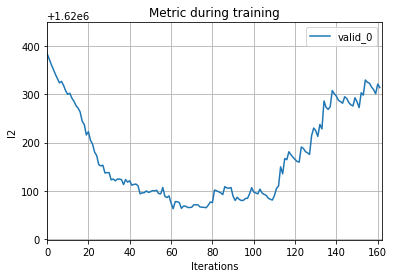

In [76]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/gold_lgb_training.eps')

Predictions/Actual volatility correlation:  0.0798799854987822
Returns  42.84 %
Number of trades:  42
Number of short trades:  15
Number of long trades:  27
Earnings per trade:  102.01
Earnings per short trade:  165.27
Earnings per long trade:  66.87
Precision score:  [0.53333333 0.01904762 0.44444444]


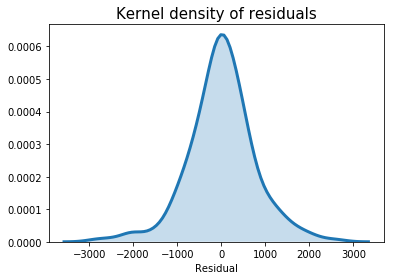

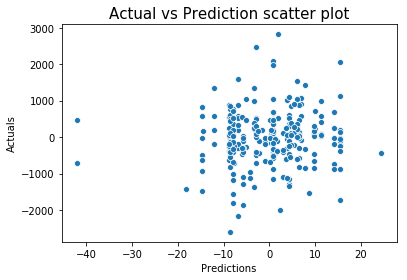

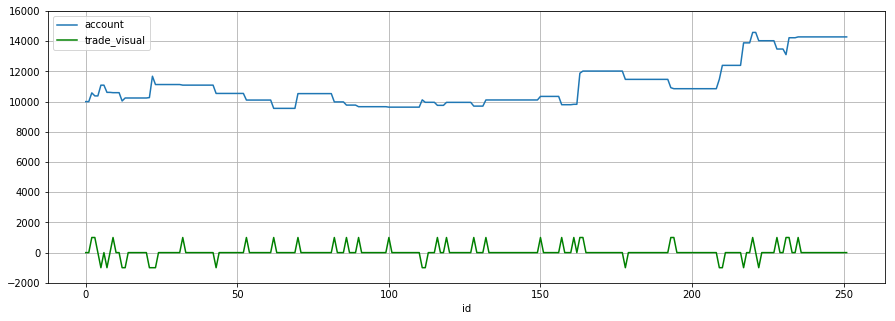

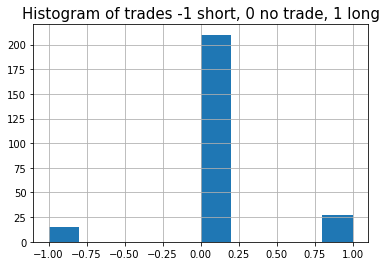

In [77]:
gold_account = get_performance(gold_clf, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=10, name='gold_lgb')

In [78]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
test_data = lgb.Dataset(X_test, label=y_test)

evals_result = {}
corn_clf = lgb.train(param, train_data, num_round,
                     early_stopping_rounds=100,
                     valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 175904
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 175905
[3]	valid_0's l2: 175907
[4]	valid_0's l2: 175908
[5]	valid_0's l2: 175900
[6]	valid_0's l2: 175902
[7]	valid_0's l2: 175894
[8]	valid_0's l2: 175893
[9]	valid_0's l2: 175895
[10]	valid_0's l2: 175887
[11]	valid_0's l2: 175889
[12]	valid_0's l2: 175888
[13]	valid_0's l2: 175881
[14]	valid_0's l2: 175883
[15]	valid_0's l2: 175876
[16]	valid_0's l2: 175877
[17]	valid_0's l2: 175870
[18]	valid_0's l2: 175872
[19]	valid_0's l2: 175866
[20]	valid_0's l2: 175869
[21]	valid_0's l2: 175867
[22]	valid_0's l2: 175860
[23]	valid_0's l2: 175863
[24]	valid_0's l2: 175856
[25]	valid_0's l2: 175859
[26]	valid_0's l2: 175853
[27]	valid_0's l2: 175855
[28]	valid_0's l2: 175855
[29]	valid_0's l2: 175850
[30]	valid_0's l2: 175852
[31]	valid_0's l2: 175852
[32]	valid_0's l2: 175847
[33]	valid_0's l2: 175849
[34]	valid_0's l2: 175849
[35]	valid_0's l2: 175850
[36]	valid_0's l2: 175850
[37]	valid

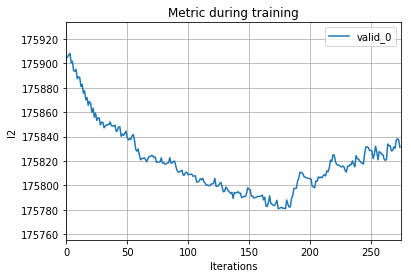

In [79]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/corn_lgb_training.eps')

Predictions/Actual volatility correlation:  0.07818532914699987
Returns  5.14 %
Number of trades:  20
Number of short trades:  11
Number of long trades:  9
Earnings per trade:  25.70
Earnings per short trade:  44.92
Earnings per long trade:  2.21
Precision score:  [0.54545455 0.0387931  0.66666667]


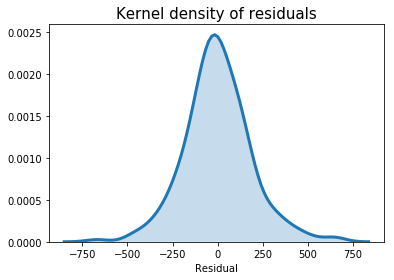

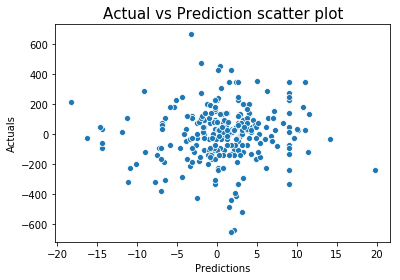

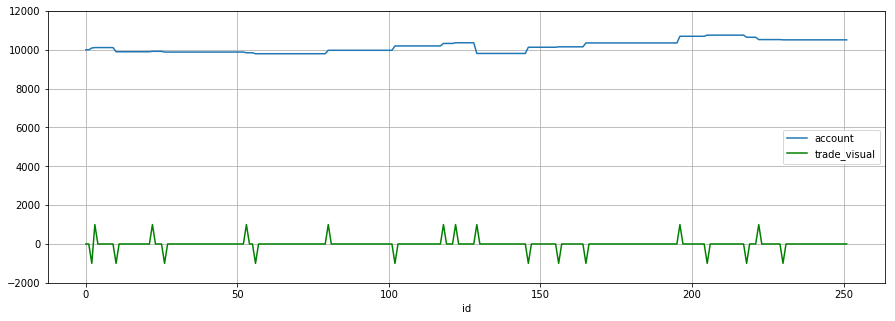

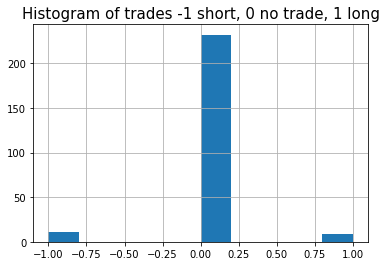

In [80]:
corn_account_lgb = get_performance(corn_clf, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=10, name='corn_lgb')

In [81]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
ln_train = len(X)
y = coffee_reg_label_train.values
train_data = lgb.Dataset(X, label=y)
X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
ln_test = len(X_test)
y_test = coffee_reg_label_test.values
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

evals_result = {}
coffee_clf = lgb.train(param, train_data, num_round, early_stopping_rounds=100, valid_sets=[test_data], evals_result=evals_result)

[1]	valid_0's l2: 161691
Training until validation scores don't improve for 100 rounds.
[2]	valid_0's l2: 161691
[3]	valid_0's l2: 161691
[4]	valid_0's l2: 161692
[5]	valid_0's l2: 161693
[6]	valid_0's l2: 161693
[7]	valid_0's l2: 161695
[8]	valid_0's l2: 161695
[9]	valid_0's l2: 161695
[10]	valid_0's l2: 161697
[11]	valid_0's l2: 161701
[12]	valid_0's l2: 161700
[13]	valid_0's l2: 161701
[14]	valid_0's l2: 161704
[15]	valid_0's l2: 161706
[16]	valid_0's l2: 161709
[17]	valid_0's l2: 161700
[18]	valid_0's l2: 161704
[19]	valid_0's l2: 161695
[20]	valid_0's l2: 161699
[21]	valid_0's l2: 161698
[22]	valid_0's l2: 161690
[23]	valid_0's l2: 161694
[24]	valid_0's l2: 161685
[25]	valid_0's l2: 161690
[26]	valid_0's l2: 161692
[27]	valid_0's l2: 161686
[28]	valid_0's l2: 161684
[29]	valid_0's l2: 161685
[30]	valid_0's l2: 161679
[31]	valid_0's l2: 161679
[32]	valid_0's l2: 161685
[33]	valid_0's l2: 161683
[34]	valid_0's l2: 161683
[35]	valid_0's l2: 161683
[36]	valid_0's l2: 161684
[37]	valid

[334]	valid_0's l2: 161423
[335]	valid_0's l2: 161427
[336]	valid_0's l2: 161428
[337]	valid_0's l2: 161425
[338]	valid_0's l2: 161429
[339]	valid_0's l2: 161429
[340]	valid_0's l2: 161430
[341]	valid_0's l2: 161437
[342]	valid_0's l2: 161428
[343]	valid_0's l2: 161432
[344]	valid_0's l2: 161433
[345]	valid_0's l2: 161425
[346]	valid_0's l2: 161423
[347]	valid_0's l2: 161424
[348]	valid_0's l2: 161430
[349]	valid_0's l2: 161421
[350]	valid_0's l2: 161422
[351]	valid_0's l2: 161421
[352]	valid_0's l2: 161426
[353]	valid_0's l2: 161418
[354]	valid_0's l2: 161419
[355]	valid_0's l2: 161420
[356]	valid_0's l2: 161416
[357]	valid_0's l2: 161417
[358]	valid_0's l2: 161421
[359]	valid_0's l2: 161421
[360]	valid_0's l2: 161424
[361]	valid_0's l2: 161416
[362]	valid_0's l2: 161420
[363]	valid_0's l2: 161421
[364]	valid_0's l2: 161422
[365]	valid_0's l2: 161413
[366]	valid_0's l2: 161414
[367]	valid_0's l2: 161415
[368]	valid_0's l2: 161412
[369]	valid_0's l2: 161414
[370]	valid_0's l2: 161421
[

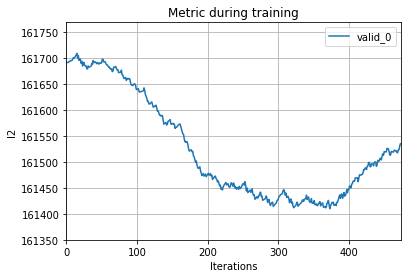

In [82]:
ax = lgb.plot_metric(evals_result, metric='l2')
plt.savefig('figures/coffee_lgb_training.eps')

Predictions/Actual volatility correlation:  -0.0014039801132773953
Returns  62.54 %
Number of trades:  37
Number of short trades:  24
Number of long trades:  13
Earnings per trade:  169.04
Earnings per short trade:  216.42
Earnings per long trade:  81.56
Precision score:  [0.45833333 0.03255814 0.23076923]


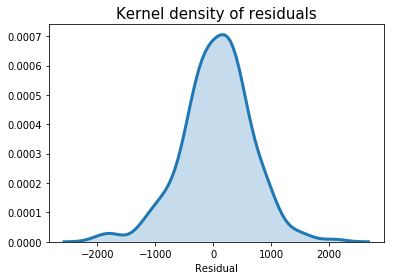

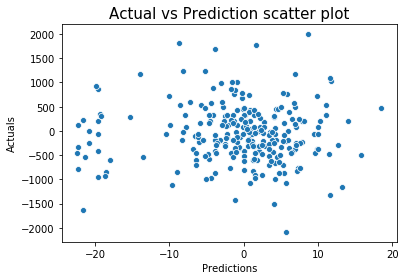

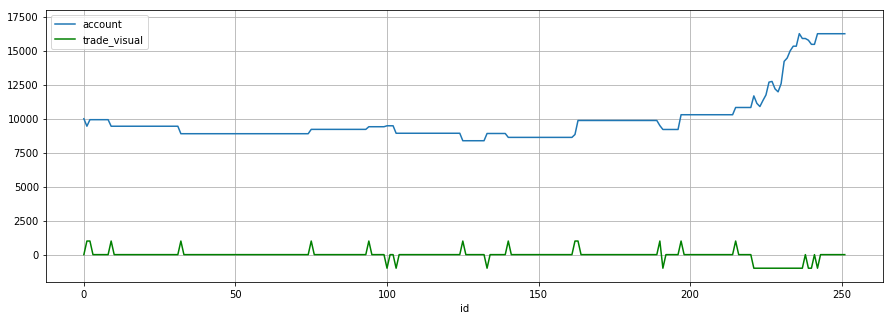

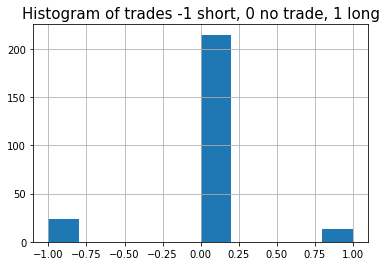

In [83]:
coffee_account_lgb = get_performance(coffee_clf, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=10, name='coffee_lgb')

# Neural Networks classifier
---


| commodity | gains % | earnings per trade | number of trades |
|-----------|---------|--------------------|------------------|
| gold      | 125     | 73.17              | 172              |
| corn      | 7       | 5.2                | 141              |
| coffee    | -100    | -90.6              | 111              |

In [84]:
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/


def plot_training_history_acc(history, name):
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    plt.savefig('figures/' + name + '_keras_accuracy.eps')
    
    
def plot_training_history_loss(history, name):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('figures/' + name + '_keras_loss.eps')
    # plt.show()

In [86]:
def create_target(x):
    if x == 1.0:
        return [0,0,1]
    elif x == 0.0:
        return [1,0,0]
    else:
        return [0,1,0]

In [87]:
X = pca_transform(gold_train, gold_pca)
y = gold_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_test, gold_pca)
y_test = gold_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

# X = np.concatenate([X, X_test])
# y = np.concatenate([y, y_test])

In [88]:
# %%capture training_gold
from keras.layers import Dropout, Flatten, Dense, Activation, LeakyReLU
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Nadam
from keras.models import Sequential
from keras.metrics import categorical_accuracy, binary_accuracy, sparse_categorical_accuracy
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import RMSprop

input_shape = 200
num_classes = 3

def define_model(input_shape, num_classes):
    # Define a model
    opt = RMSprop(lr=0.0001)
    
    model = Sequential()  
    model.add(Dense(32, input_dim=input_shape, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(16, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))
    model.add(Dense(8, activity_regularizer=regularizers.l2(0.01)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))
    model.add(Dense(num_classes))
    model.add(Activation('tanh'))

    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# opt = SGD(lr=0.1, momentum=0.9, decay=0.0, nesterov=False)
# opt = Nadam(lr=0.002)
batch_size = 20
epochs = 500
model = define_model(input_shape, num_classes)

Using TensorFlow backend.


In [89]:
from keras.callbacks import ModelCheckpoint

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

In [90]:
# model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X, y,
                    validation_data=(X_test, y_test),
                    # validation_split=0.2,
                    batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()

Train on 1927 samples, validate on 484 samples
Epoch 1/500
1927/1927 [==============================] - 7s 4ms/step - loss: 80777551057.9014 - acc: 0.3197 - val_loss: 76345906192.9256 - val_acc: 0.3182

Epoch 00001: val_loss improved from inf to 76345906192.92561, saving model to saved_models/weights.gold.hdf5
Epoch 2/500
1927/1927 [==============================] - 0s 192us/step - loss: 73832762208.0498 - acc: 0.2999 - val_loss: 69688764145.1901 - val_acc: 0.3182

Epoch 00002: val_loss improved from 76345906192.92561 to 69688764145.19008, saving model to saved_models/weights.gold.hdf5
Epoch 3/500
1927/1927 [==============================] - 0s 204us/step - loss: 67334321841.2206 - acc: 0.3285 - val_loss: 63442163271.9339 - val_acc: 0.3306

Epoch 00003: val_loss improved from 69688764145.19008 to 63442163271.93388, saving model to saved_models/weights.gold.hdf5
Epoch 4/500
1927/1927 [==============================] - 0s 198us/step - loss: 61362820859.0846 - acc: 0.3207 - val_loss: 5762

1927/1927 [==============================] - 0s 194us/step - loss: 2259182941.7250 - acc: 0.3145 - val_loss: 1969190370.3802 - val_acc: 0.3430

Epoch 00030: val_loss improved from 2423984369.19008 to 1969190370.38017, saving model to saved_models/weights.gold.hdf5
Epoch 31/500
1927/1927 [==============================] - 0s 189us/step - loss: 1816501170.7483 - acc: 0.3290 - val_loss: 1570026019.1736 - val_acc: 0.3409

Epoch 00031: val_loss improved from 1969190370.38017 to 1570026019.17355, saving model to saved_models/weights.gold.hdf5
Epoch 32/500
1927/1927 [==============================] - 0s 192us/step - loss: 1433372277.8537 - acc: 0.3259 - val_loss: 1221214579.8347 - val_acc: 0.3450

Epoch 00032: val_loss improved from 1570026019.17355 to 1221214579.83471, saving model to saved_models/weights.gold.hdf5
Epoch 33/500
1927/1927 [==============================] - 0s 191us/step - loss: 1098653481.6980 - acc: 0.3243 - val_loss: 922032333.3554 - val_acc: 0.3492

Epoch 00033: val_loss i

1927/1927 [==============================] - 0s 190us/step - loss: 182302.8247 - acc: 0.3259 - val_loss: 160386.5806 - val_acc: 0.3512

Epoch 00064: val_loss improved from 169210.82038 to 160386.58064, saving model to saved_models/weights.gold.hdf5
Epoch 65/500
1927/1927 [==============================] - 0s 191us/step - loss: 182804.6653 - acc: 0.3311 - val_loss: 188278.0536 - val_acc: 0.3698

Epoch 00065: val_loss did not improve from 160386.58064
Epoch 66/500
1927/1927 [==============================] - 0s 189us/step - loss: 182947.7387 - acc: 0.3337 - val_loss: 188952.2874 - val_acc: 0.3698

Epoch 00066: val_loss did not improve from 160386.58064
Epoch 67/500
1927/1927 [==============================] - 0s 191us/step - loss: 179576.0777 - acc: 0.3233 - val_loss: 178362.0650 - val_acc: 0.3781

Epoch 00067: val_loss did not improve from 160386.58064
Epoch 68/500
1927/1927 [==============================] - 0s 192us/step - loss: 181234.2009 - acc: 0.3368 - val_loss: 192268.8388 - val_

1927/1927 [==============================] - 0s 191us/step - loss: 181399.8599 - acc: 0.3264 - val_loss: 180989.9657 - val_acc: 0.3306

Epoch 00103: val_loss did not improve from 149231.90722
Epoch 104/500
1927/1927 [==============================] - 0s 191us/step - loss: 183534.3157 - acc: 0.3368 - val_loss: 165871.0554 - val_acc: 0.3326

Epoch 00104: val_loss did not improve from 149231.90722
Epoch 105/500
1927/1927 [==============================] - 0s 191us/step - loss: 183762.4414 - acc: 0.3399 - val_loss: 183194.1477 - val_acc: 0.3698

Epoch 00105: val_loss did not improve from 149231.90722
Epoch 106/500
1927/1927 [==============================] - 0s 193us/step - loss: 179837.0022 - acc: 0.3295 - val_loss: 159278.6726 - val_acc: 0.3430

Epoch 00106: val_loss did not improve from 149231.90722
Epoch 107/500
1927/1927 [==============================] - 0s 191us/step - loss: 181323.6647 - acc: 0.3358 - val_loss: 182823.4539 - val_acc: 0.3512

Epoch 00107: val_loss did not improve fr

1927/1927 [==============================] - 0s 191us/step - loss: 180324.7091 - acc: 0.3275 - val_loss: 212252.2261 - val_acc: 0.3409

Epoch 00143: val_loss did not improve from 149231.90722
Epoch 144/500
1927/1927 [==============================] - 0s 193us/step - loss: 184979.1954 - acc: 0.3316 - val_loss: 165569.1003 - val_acc: 0.3326

Epoch 00144: val_loss did not improve from 149231.90722
Epoch 145/500
1927/1927 [==============================] - 0s 192us/step - loss: 180206.2667 - acc: 0.3337 - val_loss: 187971.7226 - val_acc: 0.3471

Epoch 00145: val_loss did not improve from 149231.90722
Epoch 146/500
1927/1927 [==============================] - 0s 192us/step - loss: 181683.9968 - acc: 0.3337 - val_loss: 172735.6314 - val_acc: 0.3450

Epoch 00146: val_loss did not improve from 149231.90722
Epoch 147/500
1927/1927 [==============================] - 0s 193us/step - loss: 206493.6617 - acc: 0.3477 - val_loss: 140173.6405 - val_acc: 0.3533

Epoch 00147: val_loss improved from 1492


Epoch 00182: val_loss did not improve from 140173.64050
Epoch 183/500
1927/1927 [==============================] - 0s 191us/step - loss: 182583.8042 - acc: 0.3487 - val_loss: 200066.4511 - val_acc: 0.3678

Epoch 00183: val_loss did not improve from 140173.64050
Epoch 184/500
1927/1927 [==============================] - 0s 191us/step - loss: 184619.2697 - acc: 0.3378 - val_loss: 155556.0942 - val_acc: 0.3760

Epoch 00184: val_loss did not improve from 140173.64050
Epoch 185/500
1927/1927 [==============================] - 0s 192us/step - loss: 180610.5756 - acc: 0.3389 - val_loss: 197524.7343 - val_acc: 0.3719

Epoch 00185: val_loss did not improve from 140173.64050
Epoch 186/500
1927/1927 [==============================] - 0s 193us/step - loss: 187341.4388 - acc: 0.3404 - val_loss: 152477.1184 - val_acc: 0.3512

Epoch 00186: val_loss did not improve from 140173.64050
Epoch 187/500
1927/1927 [==============================] - 0s 191us/step - loss: 177872.4713 - acc: 0.3342 - val_loss: 


Epoch 00222: val_loss did not improve from 140173.64050
Epoch 223/500
1927/1927 [==============================] - 0s 189us/step - loss: 182762.7169 - acc: 0.3430 - val_loss: 182515.0256 - val_acc: 0.3802

Epoch 00223: val_loss did not improve from 140173.64050
Epoch 224/500
1927/1927 [==============================] - 0s 190us/step - loss: 182091.7777 - acc: 0.3383 - val_loss: 174968.4163 - val_acc: 0.3864

Epoch 00224: val_loss did not improve from 140173.64050
Epoch 225/500
1927/1927 [==============================] - 0s 203us/step - loss: 185255.8417 - acc: 0.3544 - val_loss: 191361.6245 - val_acc: 0.3760

Epoch 00225: val_loss did not improve from 140173.64050
Epoch 226/500
1927/1927 [==============================] - 0s 193us/step - loss: 185222.2015 - acc: 0.3581 - val_loss: 178778.4554 - val_acc: 0.3967

Epoch 00226: val_loss did not improve from 140173.64050
Epoch 227/500
1927/1927 [==============================] - 0s 191us/step - loss: 180035.1776 - acc: 0.3472 - val_loss: 


Epoch 00262: val_loss did not improve from 140173.64050
Epoch 263/500
1927/1927 [==============================] - 0s 190us/step - loss: 186548.5672 - acc: 0.3399 - val_loss: 184650.7101 - val_acc: 0.3698

Epoch 00263: val_loss did not improve from 140173.64050
Epoch 264/500
1927/1927 [==============================] - 0s 190us/step - loss: 180893.3394 - acc: 0.3383 - val_loss: 190350.7244 - val_acc: 0.3616

Epoch 00264: val_loss did not improve from 140173.64050
Epoch 265/500
1927/1927 [==============================] - 0s 189us/step - loss: 179335.2250 - acc: 0.3368 - val_loss: 182141.2195 - val_acc: 0.3636

Epoch 00265: val_loss did not improve from 140173.64050
Epoch 266/500
1927/1927 [==============================] - 0s 188us/step - loss: 181927.6057 - acc: 0.3664 - val_loss: 205610.6750 - val_acc: 0.3843

Epoch 00266: val_loss did not improve from 140173.64050
Epoch 267/500
1927/1927 [==============================] - 0s 192us/step - loss: 184336.7430 - acc: 0.3518 - val_loss: 


Epoch 00302: val_loss did not improve from 140173.64050
Epoch 303/500
1927/1927 [==============================] - 0s 189us/step - loss: 183144.1779 - acc: 0.3415 - val_loss: 152081.7086 - val_acc: 0.3760

Epoch 00303: val_loss did not improve from 140173.64050
Epoch 304/500
1927/1927 [==============================] - 0s 194us/step - loss: 179427.5151 - acc: 0.3378 - val_loss: 193596.5546 - val_acc: 0.3946

Epoch 00304: val_loss did not improve from 140173.64050
Epoch 305/500
1927/1927 [==============================] - 0s 188us/step - loss: 185145.4215 - acc: 0.3368 - val_loss: 158043.4761 - val_acc: 0.4132

Epoch 00305: val_loss did not improve from 140173.64050
Epoch 306/500
1927/1927 [==============================] - 0s 188us/step - loss: 179884.2339 - acc: 0.3461 - val_loss: 166026.7904 - val_acc: 0.4091

Epoch 00306: val_loss did not improve from 140173.64050
Epoch 307/500
1927/1927 [==============================] - 0s 190us/step - loss: 181074.6732 - acc: 0.3290 - val_loss: 


Epoch 00342: val_loss did not improve from 140173.64050
Epoch 343/500
1927/1927 [==============================] - 0s 192us/step - loss: 180058.8458 - acc: 0.3498 - val_loss: 201475.0761 - val_acc: 0.4070

Epoch 00343: val_loss did not improve from 140173.64050
Epoch 344/500
1927/1927 [==============================] - 0s 195us/step - loss: 183119.0204 - acc: 0.3332 - val_loss: 193007.2354 - val_acc: 0.4277

Epoch 00344: val_loss did not improve from 140173.64050
Epoch 345/500
1927/1927 [==============================] - 0s 193us/step - loss: 184002.4118 - acc: 0.3508 - val_loss: 198211.5928 - val_acc: 0.3698

Epoch 00345: val_loss did not improve from 140173.64050
Epoch 346/500
1927/1927 [==============================] - 0s 191us/step - loss: 184579.7349 - acc: 0.3596 - val_loss: 190861.5568 - val_acc: 0.4256

Epoch 00346: val_loss did not improve from 140173.64050
Epoch 347/500
1927/1927 [==============================] - 0s 191us/step - loss: 178818.5917 - acc: 0.3311 - val_loss: 


Epoch 00382: val_loss did not improve from 140173.64050
Epoch 383/500
1927/1927 [==============================] - 0s 192us/step - loss: 181564.7546 - acc: 0.3643 - val_loss: 202219.1529 - val_acc: 0.4132

Epoch 00383: val_loss did not improve from 140173.64050
Epoch 384/500
1927/1927 [==============================] - 0s 191us/step - loss: 181489.3723 - acc: 0.3622 - val_loss: 215284.0317 - val_acc: 0.4277

Epoch 00384: val_loss did not improve from 140173.64050
Epoch 385/500
1927/1927 [==============================] - 0s 194us/step - loss: 182049.6583 - acc: 0.3565 - val_loss: 178431.8353 - val_acc: 0.4132

Epoch 00385: val_loss did not improve from 140173.64050
Epoch 386/500
1927/1927 [==============================] - 0s 191us/step - loss: 182432.5374 - acc: 0.3409 - val_loss: 170927.9063 - val_acc: 0.3988

Epoch 00386: val_loss did not improve from 140173.64050
Epoch 387/500
1927/1927 [==============================] - 0s 190us/step - loss: 183288.6707 - acc: 0.3617 - val_loss: 


Epoch 00422: val_loss did not improve from 140173.64050
Epoch 423/500
1927/1927 [==============================] - 0s 190us/step - loss: 183308.6558 - acc: 0.3409 - val_loss: 199610.4736 - val_acc: 0.4008

Epoch 00423: val_loss did not improve from 140173.64050
Epoch 424/500
1927/1927 [==============================] - 0s 190us/step - loss: 181808.9933 - acc: 0.3555 - val_loss: 182330.0605 - val_acc: 0.4112

Epoch 00424: val_loss did not improve from 140173.64050
Epoch 425/500
1927/1927 [==============================] - 0s 193us/step - loss: 187180.9539 - acc: 0.3555 - val_loss: 180918.7445 - val_acc: 0.3988

Epoch 00425: val_loss did not improve from 140173.64050
Epoch 426/500
1927/1927 [==============================] - 0s 195us/step - loss: 179898.9666 - acc: 0.3736 - val_loss: 179651.3054 - val_acc: 0.4174

Epoch 00426: val_loss did not improve from 140173.64050
Epoch 427/500
1927/1927 [==============================] - 0s 200us/step - loss: 182134.9519 - acc: 0.3612 - val_loss: 


Epoch 00462: val_loss did not improve from 140173.64050
Epoch 463/500
1927/1927 [==============================] - 0s 204us/step - loss: 184883.5426 - acc: 0.3576 - val_loss: 186798.0984 - val_acc: 0.4277

Epoch 00463: val_loss did not improve from 140173.64050
Epoch 464/500
1927/1927 [==============================] - 0s 191us/step - loss: 182209.0089 - acc: 0.3389 - val_loss: 161865.6259 - val_acc: 0.4008

Epoch 00464: val_loss did not improve from 140173.64050
Epoch 465/500
1927/1927 [==============================] - 0s 191us/step - loss: 183013.5692 - acc: 0.3534 - val_loss: 200803.1914 - val_acc: 0.3905

Epoch 00465: val_loss did not improve from 140173.64050
Epoch 466/500
1927/1927 [==============================] - 0s 193us/step - loss: 182324.4663 - acc: 0.3467 - val_loss: 159702.4816 - val_acc: 0.4421

Epoch 00466: val_loss did not improve from 140173.64050
Epoch 467/500
1927/1927 [==============================] - 0s 211us/step - loss: 186805.2870 - acc: 0.3487 - val_loss: 

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


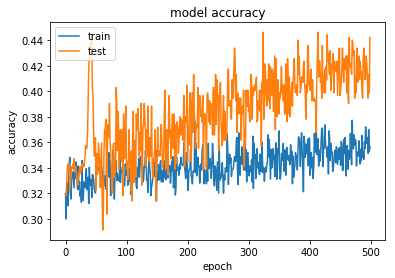

In [91]:
plot_training_history_acc(history, 'gold_nn_clf')

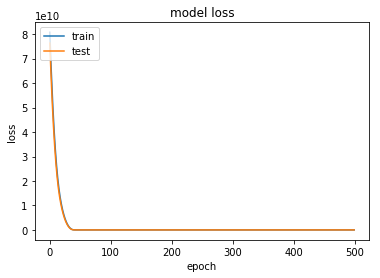

In [92]:
plot_training_history_loss(history, 'gold_nn_clf')

In [93]:
model.load_weights('saved_models/weights.gold.hdf5')
gold_clf_nn = model

Returns  67.96 %
Number of trades:  146
Number of short trades:  3
Number of long trades:  143
Earnings per trade:  46.54
Earnings per short trade:  -184.33
Earnings per long trade:  51.39
Precision score:  [0.         0.63207547 0.22377622]


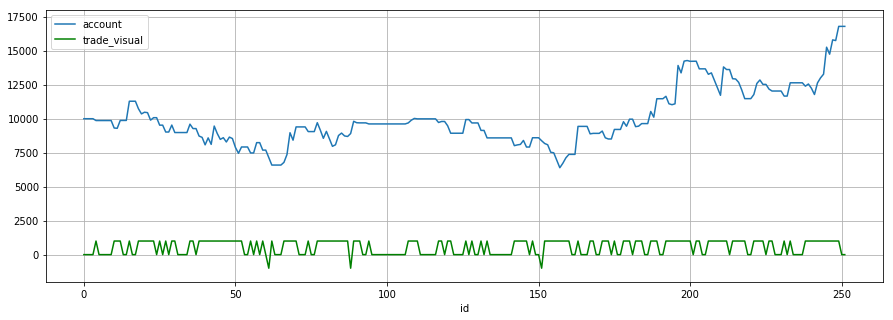

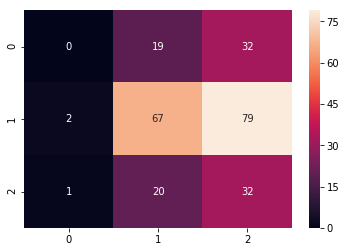

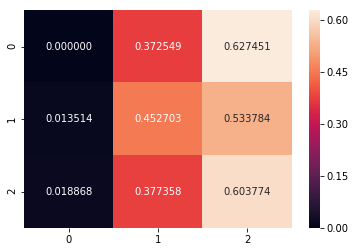

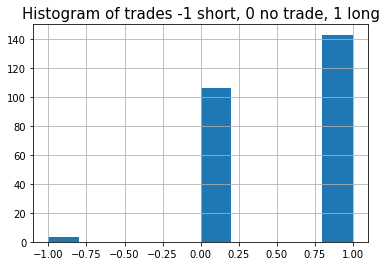

In [94]:
gold_account_nn = get_performance(gold_clf_nn, gold_pca, gold_gains.loc[gold_gains.index > validate_date], gold_validate, gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_nn_cls', regression=False)

In [95]:
X = pca_transform(corn_train, corn_pca)
y = corn_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_test, corn_pca)
y_test = corn_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.corn.hdf5')
corn_clf_nn = model

Train on 1928 samples, validate on 483 samples
Epoch 1/500
1928/1928 [==============================] - 1s 546us/step - loss: 70862649879.3693 - acc: 0.3465 - val_loss: 66244874714.8986 - val_acc: 0.3209

Epoch 00001: val_loss improved from inf to 66244874714.89855, saving model to saved_models/weights.corn.hdf5
Epoch 2/500
1928/1928 [==============================] - 0s 190us/step - loss: 64324199819.1535 - acc: 0.3299 - val_loss: 60061500507.1636 - val_acc: 0.3313

Epoch 00002: val_loss improved from 66244874714.89855 to 60061500507.16356, saving model to saved_models/weights.corn.hdf5
Epoch 3/500
1928/1928 [==============================] - 0s 209us/step - loss: 58200345842.1909 - acc: 0.3605 - val_loss: 54258985795.3126 - val_acc: 0.3313

Epoch 00003: val_loss improved from 60061500507.16356 to 54258985795.31263, saving model to saved_models/weights.corn.hdf5
Epoch 4/500
1928/1928 [==============================] - 0s 202us/step - loss: 52557660618.8880 - acc: 0.3470 - val_loss: 48

1928/1928 [==============================] - 0s 191us/step - loss: 2113270478.8714 - acc: 0.3543 - val_loss: 1856290739.6108 - val_acc: 0.3292

Epoch 00030: val_loss improved from 2238729329.29193 to 1856290739.61077, saving model to saved_models/weights.corn.hdf5
Epoch 31/500
1928/1928 [==============================] - 0s 192us/step - loss: 1740841986.3900 - acc: 0.3309 - val_loss: 1515999493.8302 - val_acc: 0.3354

Epoch 00031: val_loss improved from 1856290739.61077 to 1515999493.83023, saving model to saved_models/weights.corn.hdf5
Epoch 32/500
1928/1928 [==============================] - 0s 194us/step - loss: 1408898091.4191 - acc: 0.3325 - val_loss: 1213836638.4099 - val_acc: 0.3333

Epoch 00032: val_loss improved from 1515999493.83023 to 1213836638.40994, saving model to saved_models/weights.corn.hdf5
Epoch 33/500
1928/1928 [==============================] - 0s 191us/step - loss: 1119084956.0166 - acc: 0.3169 - val_loss: 950080264.7453 - val_acc: 0.3354

Epoch 00033: val_loss i

1928/1928 [==============================] - 0s 193us/step - loss: 154809.1441 - acc: 0.3330 - val_loss: 143188.7305 - val_acc: 0.3271

Epoch 00064: val_loss did not improve from 125046.12251
Epoch 65/500
1928/1928 [==============================] - 0s 191us/step - loss: 156538.9757 - acc: 0.3325 - val_loss: 167600.7730 - val_acc: 0.3706

Epoch 00065: val_loss did not improve from 125046.12251
Epoch 66/500
1928/1928 [==============================] - 0s 191us/step - loss: 156395.0169 - acc: 0.3195 - val_loss: 155540.8684 - val_acc: 0.3416

Epoch 00066: val_loss did not improve from 125046.12251
Epoch 67/500
1928/1928 [==============================] - 0s 192us/step - loss: 154791.5418 - acc: 0.3397 - val_loss: 162933.9085 - val_acc: 0.3395

Epoch 00067: val_loss did not improve from 125046.12251
Epoch 68/500
1928/1928 [==============================] - 0s 203us/step - loss: 157040.2957 - acc: 0.3288 - val_loss: 152214.2376 - val_acc: 0.2940

Epoch 00068: val_loss did not improve from 1

1928/1928 [==============================] - 0s 193us/step - loss: 155144.7394 - acc: 0.3351 - val_loss: 147310.4379 - val_acc: 0.3271

Epoch 00104: val_loss did not improve from 119028.82609
Epoch 105/500
1928/1928 [==============================] - 0s 206us/step - loss: 156903.3733 - acc: 0.3200 - val_loss: 138893.9267 - val_acc: 0.3085

Epoch 00105: val_loss did not improve from 119028.82609
Epoch 106/500
1928/1928 [==============================] - 0s 191us/step - loss: 155524.8690 - acc: 0.3377 - val_loss: 181984.4250 - val_acc: 0.3416

Epoch 00106: val_loss did not improve from 119028.82609
Epoch 107/500
1928/1928 [==============================] - 0s 192us/step - loss: 158641.8055 - acc: 0.3371 - val_loss: 171796.4705 - val_acc: 0.3147

Epoch 00107: val_loss did not improve from 119028.82609
Epoch 108/500
1928/1928 [==============================] - 0s 203us/step - loss: 152493.1084 - acc: 0.3428 - val_loss: 144881.6585 - val_acc: 0.3230

Epoch 00108: val_loss did not improve fr

1928/1928 [==============================] - 0s 196us/step - loss: 154769.7421 - acc: 0.3205 - val_loss: 173397.9232 - val_acc: 0.3395

Epoch 00144: val_loss did not improve from 119028.82609
Epoch 145/500
1928/1928 [==============================] - 0s 194us/step - loss: 155660.7148 - acc: 0.3496 - val_loss: 168272.9888 - val_acc: 0.3168

Epoch 00145: val_loss did not improve from 119028.82609
Epoch 146/500
1928/1928 [==============================] - 0s 191us/step - loss: 157132.9172 - acc: 0.3356 - val_loss: 151251.6438 - val_acc: 0.3375

Epoch 00146: val_loss did not improve from 119028.82609
Epoch 147/500
1928/1928 [==============================] - 0s 202us/step - loss: 157824.8595 - acc: 0.3449 - val_loss: 157731.1829 - val_acc: 0.3251

Epoch 00147: val_loss did not improve from 119028.82609
Epoch 148/500
1928/1928 [==============================] - 0s 209us/step - loss: 154927.7853 - acc: 0.3366 - val_loss: 136696.2564 - val_acc: 0.3602

Epoch 00148: val_loss did not improve fr

1928/1928 [==============================] - 0s 192us/step - loss: 154962.8735 - acc: 0.3449 - val_loss: 135453.9746 - val_acc: 0.3623

Epoch 00184: val_loss did not improve from 119028.82609
Epoch 185/500
1928/1928 [==============================] - 0s 193us/step - loss: 155905.3552 - acc: 0.3579 - val_loss: 163932.2161 - val_acc: 0.3685

Epoch 00185: val_loss did not improve from 119028.82609
Epoch 186/500
1928/1928 [==============================] - 0s 190us/step - loss: 157511.7455 - acc: 0.3548 - val_loss: 152870.1865 - val_acc: 0.3416

Epoch 00186: val_loss did not improve from 119028.82609
Epoch 187/500
1928/1928 [==============================] - 0s 192us/step - loss: 153429.9769 - acc: 0.3745 - val_loss: 155700.6210 - val_acc: 0.3623

Epoch 00187: val_loss did not improve from 119028.82609
Epoch 188/500
1928/1928 [==============================] - 0s 196us/step - loss: 156159.2420 - acc: 0.3237 - val_loss: 153116.5915 - val_acc: 0.3520

Epoch 00188: val_loss did not improve fr

1928/1928 [==============================] - 0s 193us/step - loss: 159760.6039 - acc: 0.3527 - val_loss: 138930.4175 - val_acc: 0.3395

Epoch 00224: val_loss did not improve from 119028.82609
Epoch 225/500
1928/1928 [==============================] - 0s 190us/step - loss: 152046.6491 - acc: 0.3532 - val_loss: 148408.3980 - val_acc: 0.3623

Epoch 00225: val_loss did not improve from 119028.82609
Epoch 226/500
1928/1928 [==============================] - 0s 193us/step - loss: 156448.2822 - acc: 0.3262 - val_loss: 147859.4499 - val_acc: 0.3623

Epoch 00226: val_loss did not improve from 119028.82609
Epoch 227/500
1928/1928 [==============================] - 0s 195us/step - loss: 159012.5056 - acc: 0.3408 - val_loss: 151976.2736 - val_acc: 0.3375

Epoch 00227: val_loss did not improve from 119028.82609
Epoch 228/500
1928/1928 [==============================] - 0s 192us/step - loss: 154198.8944 - acc: 0.3444 - val_loss: 172330.9380 - val_acc: 0.3520

Epoch 00228: val_loss did not improve fr

1928/1928 [==============================] - 0s 190us/step - loss: 156965.5973 - acc: 0.3449 - val_loss: 135902.6421 - val_acc: 0.3602

Epoch 00264: val_loss did not improve from 119028.82609
Epoch 265/500
1928/1928 [==============================] - 0s 192us/step - loss: 154455.0734 - acc: 0.3356 - val_loss: 141821.7674 - val_acc: 0.3623

Epoch 00265: val_loss did not improve from 119028.82609
Epoch 266/500
1928/1928 [==============================] - 0s 191us/step - loss: 156966.0413 - acc: 0.3392 - val_loss: 157492.5902 - val_acc: 0.3623

Epoch 00266: val_loss did not improve from 119028.82609
Epoch 267/500
1928/1928 [==============================] - 0s 191us/step - loss: 152801.4069 - acc: 0.3408 - val_loss: 207501.6537 - val_acc: 0.3520

Epoch 00267: val_loss did not improve from 119028.82609
Epoch 268/500
1928/1928 [==============================] - 0s 192us/step - loss: 158256.9500 - acc: 0.3522 - val_loss: 145641.6664 - val_acc: 0.3810

Epoch 00268: val_loss did not improve fr

1928/1928 [==============================] - 0s 192us/step - loss: 157020.5357 - acc: 0.3366 - val_loss: 150390.6793 - val_acc: 0.3665

Epoch 00304: val_loss did not improve from 119028.82609
Epoch 305/500
1928/1928 [==============================] - 0s 192us/step - loss: 155191.5402 - acc: 0.3532 - val_loss: 146777.2006 - val_acc: 0.3520

Epoch 00305: val_loss did not improve from 119028.82609
Epoch 306/500
1928/1928 [==============================] - 0s 192us/step - loss: 158465.0868 - acc: 0.3351 - val_loss: 162112.6841 - val_acc: 0.3665

Epoch 00306: val_loss did not improve from 119028.82609
Epoch 307/500
1928/1928 [==============================] - 0s 193us/step - loss: 153530.3065 - acc: 0.3517 - val_loss: 157604.5500 - val_acc: 0.3954

Epoch 00307: val_loss did not improve from 119028.82609
Epoch 308/500
1928/1928 [==============================] - 0s 197us/step - loss: 156877.8472 - acc: 0.3662 - val_loss: 147802.8449 - val_acc: 0.3437

Epoch 00308: val_loss did not improve fr

1928/1928 [==============================] - 0s 212us/step - loss: 155308.7189 - acc: 0.3506 - val_loss: 157316.4770 - val_acc: 0.3996

Epoch 00344: val_loss did not improve from 119028.82609
Epoch 345/500
1928/1928 [==============================] - 0s 206us/step - loss: 155244.3148 - acc: 0.3377 - val_loss: 150540.8782 - val_acc: 0.3996

Epoch 00345: val_loss did not improve from 119028.82609
Epoch 346/500
1928/1928 [==============================] - 0s 205us/step - loss: 154339.8493 - acc: 0.3413 - val_loss: 172060.7042 - val_acc: 0.3727

Epoch 00346: val_loss did not improve from 119028.82609
Epoch 347/500
1928/1928 [==============================] - 0s 209us/step - loss: 159076.7770 - acc: 0.3268 - val_loss: 143574.0400 - val_acc: 0.3623

Epoch 00347: val_loss did not improve from 119028.82609
Epoch 348/500
1928/1928 [==============================] - 0s 214us/step - loss: 156016.0350 - acc: 0.3392 - val_loss: 162985.9238 - val_acc: 0.3768

Epoch 00348: val_loss did not improve fr

1928/1928 [==============================] - 0s 193us/step - loss: 156349.2833 - acc: 0.3454 - val_loss: 136262.4884 - val_acc: 0.3810

Epoch 00384: val_loss did not improve from 119028.82609
Epoch 385/500
1928/1928 [==============================] - 0s 194us/step - loss: 157225.5023 - acc: 0.3402 - val_loss: 153583.9899 - val_acc: 0.3830

Epoch 00385: val_loss did not improve from 119028.82609
Epoch 386/500
1928/1928 [==============================] - 0s 192us/step - loss: 155575.9387 - acc: 0.3594 - val_loss: 167888.4022 - val_acc: 0.3975

Epoch 00386: val_loss did not improve from 119028.82609
Epoch 387/500
1928/1928 [==============================] - 0s 192us/step - loss: 157850.9398 - acc: 0.3563 - val_loss: 152483.7967 - val_acc: 0.3768

Epoch 00387: val_loss did not improve from 119028.82609
Epoch 388/500
1928/1928 [==============================] - 0s 191us/step - loss: 154050.7798 - acc: 0.3620 - val_loss: 140210.1884 - val_acc: 0.3727

Epoch 00388: val_loss did not improve fr

1928/1928 [==============================] - 0s 195us/step - loss: 159287.8764 - acc: 0.3605 - val_loss: 140603.0641 - val_acc: 0.3830

Epoch 00424: val_loss did not improve from 119028.82609
Epoch 425/500
1928/1928 [==============================] - 0s 192us/step - loss: 156335.2177 - acc: 0.3677 - val_loss: 176372.2802 - val_acc: 0.3685

Epoch 00425: val_loss did not improve from 119028.82609
Epoch 426/500
1928/1928 [==============================] - 0s 193us/step - loss: 157309.0058 - acc: 0.3651 - val_loss: 146542.8622 - val_acc: 0.3623

Epoch 00426: val_loss did not improve from 119028.82609
Epoch 427/500
1928/1928 [==============================] - 0s 193us/step - loss: 155674.0455 - acc: 0.3449 - val_loss: 137673.3151 - val_acc: 0.3913

Epoch 00427: val_loss did not improve from 119028.82609
Epoch 428/500
1928/1928 [==============================] - 0s 193us/step - loss: 157864.5214 - acc: 0.3553 - val_loss: 156739.4172 - val_acc: 0.3830

Epoch 00428: val_loss did not improve fr

1928/1928 [==============================] - 0s 191us/step - loss: 152731.3469 - acc: 0.3636 - val_loss: 140293.6988 - val_acc: 0.3892

Epoch 00464: val_loss did not improve from 119028.82609
Epoch 465/500
1928/1928 [==============================] - 0s 194us/step - loss: 158214.8787 - acc: 0.3491 - val_loss: 146796.8024 - val_acc: 0.3727

Epoch 00465: val_loss did not improve from 119028.82609
Epoch 466/500
1928/1928 [==============================] - 0s 192us/step - loss: 155024.6191 - acc: 0.3667 - val_loss: 150902.6825 - val_acc: 0.3582

Epoch 00466: val_loss did not improve from 119028.82609
Epoch 467/500
1928/1928 [==============================] - 0s 192us/step - loss: 158532.1101 - acc: 0.3356 - val_loss: 147664.6391 - val_acc: 0.3851

Epoch 00467: val_loss did not improve from 119028.82609
Epoch 468/500
1928/1928 [==============================] - 0s 195us/step - loss: 156541.8085 - acc: 0.3517 - val_loss: 129916.8631 - val_acc: 0.3727

Epoch 00468: val_loss did not improve fr

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


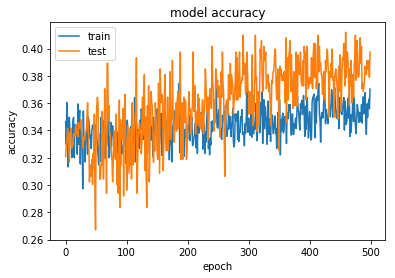

In [96]:
plot_training_history_acc(history, 'corn_nn_clf')

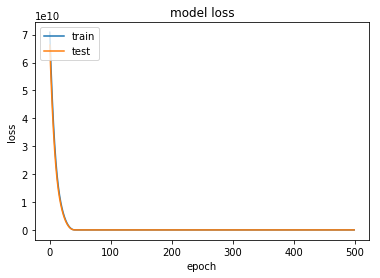

In [97]:
plot_training_history_loss(history, 'corn_nn_clf')

Returns  -39.53 %
Number of trades:  160
Number of short trades:  75
Number of long trades:  85
Earnings per trade:  -24.70
Earnings per short trade:  -10.14
Earnings per long trade:  -37.56
Precision score:  [0.12       0.64130435 0.15294118]


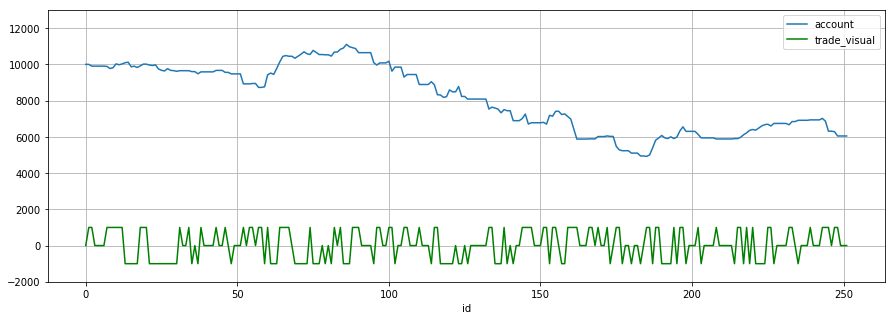

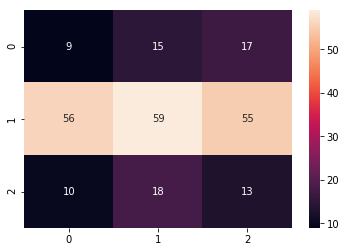

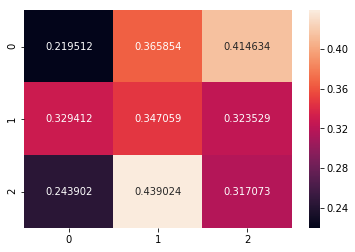

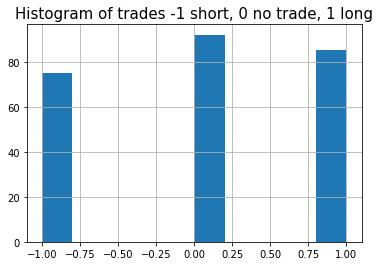

In [98]:
corn_account_nn = get_performance(corn_clf_nn, corn_pca, corn_gains.loc[corn_gains.index > validate_date], corn_validate, corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_nn_cls')

In [99]:
X = pca_transform(coffee_train, coffee_pca)
y = coffee_label_train
# remove outliers
X, y = remove_outliers(X, y, out_coffee)

X_test = pca_transform(coffee_test, coffee_pca)
y_test = coffee_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_coffee)
y = np.array(list(map(create_target, y)))
y_test = np.array(list(map(create_target, y_test)))

model = define_model(input_shape, num_classes)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

history = model.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

model.summary()
model.load_weights('saved_models/weights.coffee.hdf5')
coffee_clf_nn = model

Train on 1923 samples, validate on 481 samples
Epoch 1/500
1923/1923 [==============================] - 1s 566us/step - loss: 4445750303.3510 - acc: 0.3344 - val_loss: 4441178622.4033 - val_acc: 0.2931

Epoch 00001: val_loss improved from inf to 4441178622.40333, saving model to saved_models/weights.coffee.hdf5
Epoch 2/500
1923/1923 [==============================] - 0s 215us/step - loss: 4267020205.7285 - acc: 0.3266 - val_loss: 4284184414.7360 - val_acc: 0.2952

Epoch 00002: val_loss improved from 4441178622.40333 to 4284184414.73597, saving model to saved_models/weights.coffee.hdf5
Epoch 3/500
1923/1923 [==============================] - 0s 194us/step - loss: 4134030472.9860 - acc: 0.3313 - val_loss: 4132131315.7588 - val_acc: 0.2994

Epoch 00003: val_loss improved from 4284184414.73597 to 4132131315.75884, saving model to saved_models/weights.coffee.hdf5
Epoch 4/500
1923/1923 [==============================] - 0s 193us/step - loss: 3979165926.0406 - acc: 0.3261 - val_loss: 39852419

1923/1923 [==============================] - 0s 195us/step - loss: 1369772712.5367 - acc: 0.3229 - val_loss: 1350887731.9584 - val_acc: 0.2931

Epoch 00030: val_loss improved from 1421064024.48233 to 1350887731.95842, saving model to saved_models/weights.coffee.hdf5
Epoch 31/500
1923/1923 [==============================] - 0s 192us/step - loss: 1304976071.7608 - acc: 0.3255 - val_loss: 1282714820.3243 - val_acc: 0.2973

Epoch 00031: val_loss improved from 1350887731.95842 to 1282714820.32432, saving model to saved_models/weights.coffee.hdf5
Epoch 32/500
1923/1923 [==============================] - 0s 193us/step - loss: 1239541549.4618 - acc: 0.3167 - val_loss: 1217504673.6632 - val_acc: 0.2911

Epoch 00032: val_loss improved from 1282714820.32432 to 1217504673.66320, saving model to saved_models/weights.coffee.hdf5
Epoch 33/500
1923/1923 [==============================] - 0s 193us/step - loss: 1175499100.1300 - acc: 0.3370 - val_loss: 1153053137.5634 - val_acc: 0.2786

Epoch 00033: val

1923/1923 [==============================] - 0s 197us/step - loss: 111270198.7207 - acc: 0.3266 - val_loss: 100066505.6466 - val_acc: 0.2744

Epoch 00060: val_loss improved from 117748201.08940 to 100066505.64657, saving model to saved_models/weights.coffee.hdf5
Epoch 61/500
1923/1923 [==============================] - 0s 192us/step - loss: 94365329.3188 - acc: 0.3063 - val_loss: 83968936.1164 - val_acc: 0.2744

Epoch 00061: val_loss improved from 100066505.64657 to 83968936.11642, saving model to saved_models/weights.coffee.hdf5
Epoch 62/500
1923/1923 [==============================] - 0s 203us/step - loss: 79319440.5895 - acc: 0.3183 - val_loss: 69501416.2079 - val_acc: 0.2765

Epoch 00062: val_loss improved from 83968936.11642 to 69501416.20790, saving model to saved_models/weights.coffee.hdf5
Epoch 63/500
1923/1923 [==============================] - 0s 192us/step - loss: 65314605.4642 - acc: 0.3073 - val_loss: 56420076.8233 - val_acc: 0.2744

Epoch 00063: val_loss improved from 695


Epoch 00094: val_loss did not improve from 48343.89112
Epoch 95/500
1923/1923 [==============================] - 0s 195us/step - loss: 50060.2381 - acc: 0.3188 - val_loss: 53594.4478 - val_acc: 0.2931

Epoch 00095: val_loss did not improve from 48343.89112
Epoch 96/500
1923/1923 [==============================] - 0s 194us/step - loss: 53451.7300 - acc: 0.3219 - val_loss: 48741.8924 - val_acc: 0.2557

Epoch 00096: val_loss did not improve from 48343.89112
Epoch 97/500
1923/1923 [==============================] - 0s 194us/step - loss: 49693.1916 - acc: 0.3073 - val_loss: 56715.2489 - val_acc: 0.2723

Epoch 00097: val_loss did not improve from 48343.89112
Epoch 98/500
1923/1923 [==============================] - 0s 193us/step - loss: 54242.8188 - acc: 0.2995 - val_loss: 49506.6530 - val_acc: 0.2723

Epoch 00098: val_loss did not improve from 48343.89112
Epoch 99/500
1923/1923 [==============================] - 0s 194us/step - loss: 49442.4884 - acc: 0.3042 - val_loss: 54174.4169 - val_ac

1923/1923 [==============================] - 0s 192us/step - loss: 50472.5323 - acc: 0.3115 - val_loss: 57435.8763 - val_acc: 0.3015

Epoch 00135: val_loss did not improve from 48343.89112
Epoch 136/500
1923/1923 [==============================] - 0s 191us/step - loss: 52370.3777 - acc: 0.3146 - val_loss: 54098.0272 - val_acc: 0.2723

Epoch 00136: val_loss did not improve from 48343.89112
Epoch 137/500
1923/1923 [==============================] - 0s 194us/step - loss: 51148.8089 - acc: 0.2985 - val_loss: 56161.9191 - val_acc: 0.2703

Epoch 00137: val_loss did not improve from 48343.89112
Epoch 138/500
1923/1923 [==============================] - 0s 196us/step - loss: 53152.5812 - acc: 0.2876 - val_loss: 50428.1344 - val_acc: 0.2744

Epoch 00138: val_loss did not improve from 48343.89112
Epoch 139/500
1923/1923 [==============================] - 0s 195us/step - loss: 50968.8382 - acc: 0.3115 - val_loss: 58681.9550 - val_acc: 0.2599

Epoch 00139: val_loss did not improve from 48343.89112

1923/1923 [==============================] - 0s 194us/step - loss: 52748.4242 - acc: 0.2772 - val_loss: 58928.5864 - val_acc: 0.2640

Epoch 00175: val_loss did not improve from 46776.72856
Epoch 176/500
1923/1923 [==============================] - 0s 195us/step - loss: 53391.8571 - acc: 0.2808 - val_loss: 55473.7000 - val_acc: 0.2703

Epoch 00176: val_loss did not improve from 46776.72856
Epoch 177/500
1923/1923 [==============================] - 0s 200us/step - loss: 49506.0095 - acc: 0.2995 - val_loss: 55378.7950 - val_acc: 0.2827

Epoch 00177: val_loss did not improve from 46776.72856
Epoch 178/500
1923/1923 [==============================] - 0s 192us/step - loss: 52481.1410 - acc: 0.2985 - val_loss: 56339.7524 - val_acc: 0.2578

Epoch 00178: val_loss did not improve from 46776.72856
Epoch 179/500
1923/1923 [==============================] - 0s 193us/step - loss: 51901.8096 - acc: 0.2865 - val_loss: 56500.2298 - val_acc: 0.2703

Epoch 00179: val_loss did not improve from 46776.72856

1923/1923 [==============================] - 0s 193us/step - loss: 53006.3192 - acc: 0.2855 - val_loss: 54093.0625 - val_acc: 0.2765

Epoch 00215: val_loss did not improve from 46776.72856
Epoch 216/500
1923/1923 [==============================] - 0s 193us/step - loss: 50876.7329 - acc: 0.2772 - val_loss: 55141.2998 - val_acc: 0.2786

Epoch 00216: val_loss did not improve from 46776.72856
Epoch 217/500
1923/1923 [==============================] - 0s 193us/step - loss: 51416.7628 - acc: 0.2860 - val_loss: 54915.9489 - val_acc: 0.2807

Epoch 00217: val_loss did not improve from 46776.72856
Epoch 218/500
1923/1923 [==============================] - 0s 192us/step - loss: 53354.5573 - acc: 0.2798 - val_loss: 49305.9286 - val_acc: 0.2744

Epoch 00218: val_loss did not improve from 46776.72856
Epoch 219/500
1923/1923 [==============================] - 0s 196us/step - loss: 51190.7067 - acc: 0.2709 - val_loss: 53671.9950 - val_acc: 0.2703

Epoch 00219: val_loss did not improve from 46776.72856

1923/1923 [==============================] - 0s 194us/step - loss: 53100.0291 - acc: 0.2803 - val_loss: 44394.2106 - val_acc: 0.2536

Epoch 00255: val_loss improved from 46776.72856 to 44394.21059, saving model to saved_models/weights.coffee.hdf5
Epoch 256/500
1923/1923 [==============================] - 0s 196us/step - loss: 49876.6106 - acc: 0.2803 - val_loss: 53309.9985 - val_acc: 0.2620

Epoch 00256: val_loss did not improve from 44394.21059
Epoch 257/500
1923/1923 [==============================] - 0s 198us/step - loss: 53282.7143 - acc: 0.2777 - val_loss: 53658.9571 - val_acc: 0.2703

Epoch 00257: val_loss did not improve from 44394.21059
Epoch 258/500
1923/1923 [==============================] - 0s 192us/step - loss: 50055.8537 - acc: 0.2746 - val_loss: 56002.3839 - val_acc: 0.2599

Epoch 00258: val_loss did not improve from 44394.21059
Epoch 259/500
1923/1923 [==============================] - 0s 201us/step - loss: 51743.6460 - acc: 0.2850 - val_loss: 56475.6892 - val_acc: 0.26

1923/1923 [==============================] - 0s 197us/step - loss: 54615.6211 - acc: 0.2824 - val_loss: 47674.1982 - val_acc: 0.2557

Epoch 00295: val_loss did not improve from 44394.21059
Epoch 296/500
1923/1923 [==============================] - 0s 193us/step - loss: 50412.7500 - acc: 0.2741 - val_loss: 55763.0494 - val_acc: 0.2557

Epoch 00296: val_loss did not improve from 44394.21059
Epoch 297/500
1923/1923 [==============================] - 0s 190us/step - loss: 51071.9454 - acc: 0.2767 - val_loss: 50955.0483 - val_acc: 0.2682

Epoch 00297: val_loss did not improve from 44394.21059
Epoch 298/500
1923/1923 [==============================] - 0s 194us/step - loss: 53139.6350 - acc: 0.2839 - val_loss: 53281.2685 - val_acc: 0.2661

Epoch 00298: val_loss did not improve from 44394.21059
Epoch 299/500
1923/1923 [==============================] - 0s 192us/step - loss: 51543.9524 - acc: 0.2829 - val_loss: 55187.0553 - val_acc: 0.2723

Epoch 00299: val_loss did not improve from 44394.21059

1923/1923 [==============================] - 0s 192us/step - loss: 53134.2308 - acc: 0.2709 - val_loss: 52259.3109 - val_acc: 0.2765

Epoch 00335: val_loss did not improve from 44394.21059
Epoch 336/500
1923/1923 [==============================] - 0s 192us/step - loss: 50117.7941 - acc: 0.2678 - val_loss: 51356.4184 - val_acc: 0.2620

Epoch 00336: val_loss did not improve from 44394.21059
Epoch 337/500
1923/1923 [==============================] - 0s 192us/step - loss: 52345.2847 - acc: 0.2772 - val_loss: 54558.4035 - val_acc: 0.2703

Epoch 00337: val_loss did not improve from 44394.21059
Epoch 338/500
1923/1923 [==============================] - 0s 193us/step - loss: 52088.9496 - acc: 0.2767 - val_loss: 52427.6575 - val_acc: 0.2703

Epoch 00338: val_loss did not improve from 44394.21059
Epoch 339/500
1923/1923 [==============================] - 0s 196us/step - loss: 50250.2026 - acc: 0.2631 - val_loss: 55499.9223 - val_acc: 0.2620

Epoch 00339: val_loss did not improve from 44394.21059

1923/1923 [==============================] - 0s 201us/step - loss: 51886.4924 - acc: 0.2673 - val_loss: 57795.0373 - val_acc: 0.2703

Epoch 00375: val_loss did not improve from 44394.21059
Epoch 376/500
1923/1923 [==============================] - 0s 192us/step - loss: 50449.5129 - acc: 0.2642 - val_loss: 58175.6408 - val_acc: 0.2682

Epoch 00376: val_loss did not improve from 44394.21059
Epoch 377/500
1923/1923 [==============================] - 0s 193us/step - loss: 53881.5323 - acc: 0.2678 - val_loss: 51927.2164 - val_acc: 0.2765

Epoch 00377: val_loss did not improve from 44394.21059
Epoch 378/500
1923/1923 [==============================] - 0s 192us/step - loss: 50798.0840 - acc: 0.2824 - val_loss: 51750.6813 - val_acc: 0.2661

Epoch 00378: val_loss did not improve from 44394.21059
Epoch 379/500
1923/1923 [==============================] - 0s 196us/step - loss: 49919.1743 - acc: 0.2751 - val_loss: 51924.7125 - val_acc: 0.2599

Epoch 00379: val_loss did not improve from 44394.21059

1923/1923 [==============================] - 0s 192us/step - loss: 49207.9055 - acc: 0.2709 - val_loss: 53816.2379 - val_acc: 0.2744

Epoch 00415: val_loss did not improve from 44394.21059
Epoch 416/500
1923/1923 [==============================] - 0s 198us/step - loss: 53477.3400 - acc: 0.2621 - val_loss: 49705.2423 - val_acc: 0.2620

Epoch 00416: val_loss did not improve from 44394.21059
Epoch 417/500
1923/1923 [==============================] - 0s 194us/step - loss: 53308.1160 - acc: 0.2767 - val_loss: 50999.3672 - val_acc: 0.2495

Epoch 00417: val_loss did not improve from 44394.21059
Epoch 418/500
1923/1923 [==============================] - 0s 193us/step - loss: 49984.3369 - acc: 0.2777 - val_loss: 53601.5100 - val_acc: 0.2827

Epoch 00418: val_loss did not improve from 44394.21059
Epoch 419/500
1923/1923 [==============================] - 0s 192us/step - loss: 50249.7388 - acc: 0.2751 - val_loss: 55128.8297 - val_acc: 0.2578

Epoch 00419: val_loss did not improve from 44394.21059

1923/1923 [==============================] - 0s 192us/step - loss: 52871.4344 - acc: 0.2709 - val_loss: 55668.9916 - val_acc: 0.2682

Epoch 00455: val_loss did not improve from 44394.21059
Epoch 456/500
1923/1923 [==============================] - 0s 194us/step - loss: 52443.0062 - acc: 0.2616 - val_loss: 56371.3898 - val_acc: 0.2661

Epoch 00456: val_loss did not improve from 44394.21059
Epoch 457/500
1923/1923 [==============================] - 0s 191us/step - loss: 51505.1399 - acc: 0.2647 - val_loss: 51634.6156 - val_acc: 0.2640

Epoch 00457: val_loss did not improve from 44394.21059
Epoch 458/500
1923/1923 [==============================] - 0s 195us/step - loss: 52479.4104 - acc: 0.2689 - val_loss: 52537.5137 - val_acc: 0.2620

Epoch 00458: val_loss did not improve from 44394.21059
Epoch 459/500
1923/1923 [==============================] - 0s 195us/step - loss: 49813.5375 - acc: 0.2637 - val_loss: 57755.6730 - val_acc: 0.2661

Epoch 00459: val_loss did not improve from 44394.21059

1923/1923 [==============================] - 0s 193us/step - loss: 52265.6035 - acc: 0.2725 - val_loss: 54428.6163 - val_acc: 0.2640

Epoch 00495: val_loss did not improve from 44394.21059
Epoch 496/500
1923/1923 [==============================] - 0s 195us/step - loss: 52716.9424 - acc: 0.2699 - val_loss: 48491.2389 - val_acc: 0.2661

Epoch 00496: val_loss did not improve from 44394.21059
Epoch 497/500
1923/1923 [==============================] - 0s 193us/step - loss: 50582.0723 - acc: 0.2522 - val_loss: 56875.9190 - val_acc: 0.2682

Epoch 00497: val_loss did not improve from 44394.21059
Epoch 498/500
1923/1923 [==============================] - 0s 198us/step - loss: 51025.2984 - acc: 0.2673 - val_loss: 55152.0361 - val_acc: 0.2723

Epoch 00498: val_loss did not improve from 44394.21059
Epoch 499/500
1923/1923 [==============================] - 0s 198us/step - loss: 52496.7300 - acc: 0.2709 - val_loss: 55161.8209 - val_acc: 0.2682

Epoch 00499: val_loss did not improve from 44394.21059

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


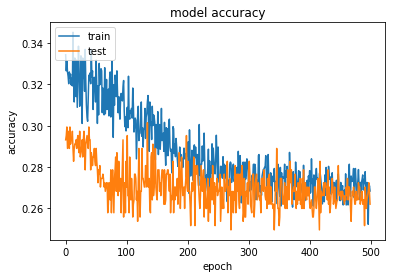

In [100]:
plot_training_history_acc(history, 'coffee_nn_clf')

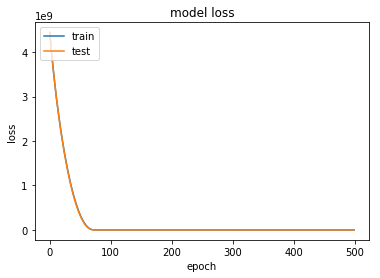

In [101]:
plot_training_history_loss(history, 'coffee_nn_clf')

Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00
Precision score:  [0.         0.39285714 0.        ]


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


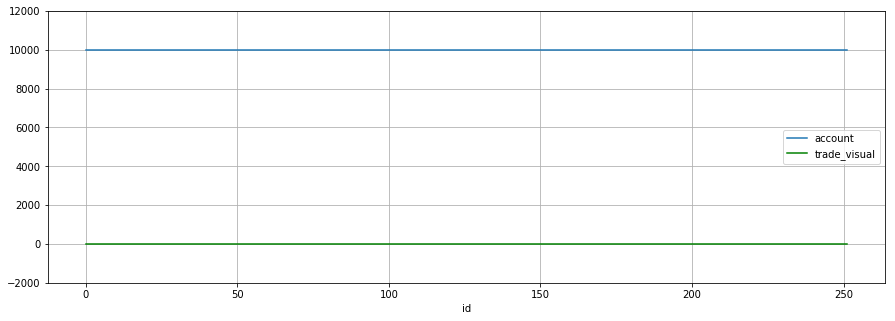

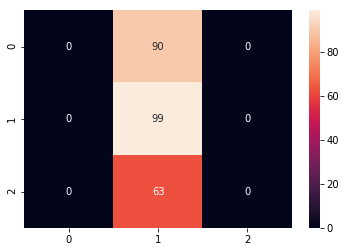

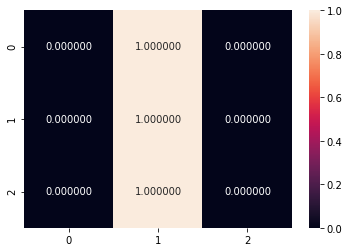

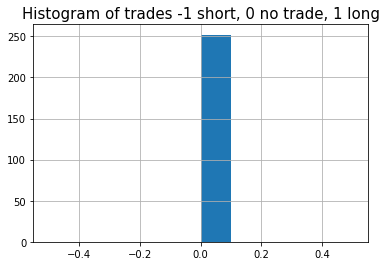

In [102]:
coffee_account_nn = get_performance(coffee_clf_nn, coffee_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_validate, coffee_label_validate, stop_loss_long=300, stop_loss_short=300, name='coffee_nn_cls')

# Neural network regressor

I have decided to use weighted in loss function with weight $0.75$. This is because errors around $0$ does not matter because I want to trigger trades when volatility reaches threshold.

Model performance
---


| commodity | gains % | earnings per trade | number of trades | test/real correlation |
|-----------|---------|--------------------|------------------|-----------------------|
| gold      | 232     | 180                | 129              | 0.14                  |
| corn      | -74     | -65                | 113              | -0.025                |
| coffee   | -12.92  | -56                | 23               | -0.020                |

In [103]:
import keras
import tensorflow as tf
from tensorflow.losses import mean_squared_error
from keras.optimizers import Nadam


def huber_loss(y_true, y_pred):
    return tf.losses.huber_loss(y_true,y_pred)


def weighted_mean_squared_error(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, weights=0.75)


# loss = huber_loss
loss = weighted_mean_squared_error
# optimizer = 'Adam'
optimizer = Nadam(lr=0.0001)

def regressor_model():
    global input_shape
    global loss
    global optimizer
    
    alpha=.0001
    model = Sequential()
    model.add(Dense(500, input_dim=input_shape, kernel_initializer='normal', activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(128, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(64, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(32, kernel_initializer='normal',activation='relu',))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.4))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss=loss, optimizer=optimizer, metrics=["mean_squared_error"])
    return model

    # model.compile(optimizer=opt, loss='mean_squared_error', metrics=['accuracy'])
    # model.compile(loss='l1', optimizer='sgd', metrics=['mse'])
    # return model

In [104]:
X = pca_transform(gold_reg_train, gold_reg_pca)
y = gold_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_gold)

X_test = pca_transform(gold_reg_test, gold_reg_pca)
y_test = gold_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_gold)

epochs = 1000
batch_size = 50

checkpointer = ModelCheckpoint(filepath='saved_models/weights.gold_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)

In [105]:
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1927 samples, validate on 484 samples
Epoch 1/1000
1927/1927 [==============================] - 2s 788us/step - loss: 1279835.0120 - mean_squared_error: 1706446.6788 - val_loss: 1215193.7206 - val_mean_squared_error: 1620258.3275

Epoch 00001: val_loss improved from inf to 1215193.72056, saving model to saved_models/weights.gold_reg.hdf5
Epoch 2/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1279826.4941 - mean_squared_error: 1706435.2832 - val_loss: 1215193.4447 - val_mean_squared_error: 1620257.8722

Epoch 00002: val_loss improved from 1215193.72056 to 1215193.44473, saving model to saved_models/weights.gold_reg.hdf5
Epoch 3/1000
1927/1927 [==============================] - 0s 116us/step - loss: 1279813.9880 - mean_squared_error: 1706418.6376 - val_loss: 1215193.3897 - val_mean_squared_error: 1620257.8388

Epoch 00003: val_loss improved from 1215193.44473 to 1215193.38972, saving model to saved_models/weights.gold_reg.hdf5
Epoch 4/1000
1927/1927 [===

1927/1927 [==============================] - 0s 113us/step - loss: 1279754.9805 - mean_squared_error: 1706339.9533 - val_loss: 1215183.5034 - val_mean_squared_error: 1620244.7482

Epoch 00028: val_loss improved from 1215184.34685 to 1215183.50336, saving model to saved_models/weights.gold_reg.hdf5
Epoch 29/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1279747.9739 - mean_squared_error: 1706330.6362 - val_loss: 1215182.6147 - val_mean_squared_error: 1620243.4667

Epoch 00029: val_loss improved from 1215183.50336 to 1215182.61467, saving model to saved_models/weights.gold_reg.hdf5
Epoch 30/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1279784.3642 - mean_squared_error: 1706379.1734 - val_loss: 1215182.0054 - val_mean_squared_error: 1620242.7113

Epoch 00030: val_loss improved from 1215182.61467 to 1215182.00542, saving model to saved_models/weights.gold_reg.hdf5
Epoch 31/1000
1927/1927 [==============================] - 0s 114us/step - 

1927/1927 [==============================] - 0s 114us/step - loss: 1278847.1071 - mean_squared_error: 1705129.4762 - val_loss: 1215083.0070 - val_mean_squared_error: 1620110.6521

Epoch 00054: val_loss improved from 1215091.38042 to 1215083.00697, saving model to saved_models/weights.gold_reg.hdf5
Epoch 55/1000
1927/1927 [==============================] - 0s 113us/step - loss: 1278616.4928 - mean_squared_error: 1704821.9827 - val_loss: 1215065.3174 - val_mean_squared_error: 1620087.0320

Epoch 00055: val_loss improved from 1215083.00697 to 1215065.31741, saving model to saved_models/weights.gold_reg.hdf5
Epoch 56/1000
1927/1927 [==============================] - 0s 116us/step - loss: 1278627.8594 - mean_squared_error: 1704837.1657 - val_loss: 1215047.9424 - val_mean_squared_error: 1620063.8995

Epoch 00056: val_loss improved from 1215065.31741 to 1215047.94241, saving model to saved_models/weights.gold_reg.hdf5
Epoch 57/1000
1927/1927 [==============================] - 0s 116us/step - 

1927/1927 [==============================] - 0s 114us/step - loss: 1274496.3532 - mean_squared_error: 1699328.5016 - val_loss: 1214689.5876 - val_mean_squared_error: 1619586.0837

Epoch 00081: val_loss improved from 1214735.58110 to 1214689.58755, saving model to saved_models/weights.gold_reg.hdf5
Epoch 82/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1274196.8744 - mean_squared_error: 1698929.1534 - val_loss: 1214650.0323 - val_mean_squared_error: 1619533.4039

Epoch 00082: val_loss improved from 1214689.58755 to 1214650.03228, saving model to saved_models/weights.gold_reg.hdf5
Epoch 83/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1273941.1426 - mean_squared_error: 1698588.1772 - val_loss: 1214623.7939 - val_mean_squared_error: 1619498.3453

Epoch 00083: val_loss improved from 1214650.03228 to 1214623.79390, saving model to saved_models/weights.gold_reg.hdf5
Epoch 84/1000
1927/1927 [==============================] - 0s 123us/step - 

1927/1927 [==============================] - 0s 137us/step - loss: 1267610.7140 - mean_squared_error: 1690147.6105 - val_loss: 1214328.0127 - val_mean_squared_error: 1619103.9930

Epoch 00110: val_loss improved from 1214347.88791 to 1214328.01265, saving model to saved_models/weights.gold_reg.hdf5
Epoch 111/1000
1927/1927 [==============================] - 0s 141us/step - loss: 1267622.5170 - mean_squared_error: 1690163.3869 - val_loss: 1214303.5467 - val_mean_squared_error: 1619071.3877

Epoch 00111: val_loss improved from 1214328.01265 to 1214303.54675, saving model to saved_models/weights.gold_reg.hdf5
Epoch 112/1000
1927/1927 [==============================] - 0s 136us/step - loss: 1266818.3748 - mean_squared_error: 1689091.1470 - val_loss: 1214277.5713 - val_mean_squared_error: 1619036.7177

Epoch 00112: val_loss improved from 1214303.54675 to 1214277.57128, saving model to saved_models/weights.gold_reg.hdf5
Epoch 113/1000
1927/1927 [==============================] - 0s 134us/step


Epoch 00138: val_loss did not improve from 1213859.96901
Epoch 139/1000
1927/1927 [==============================] - 0s 117us/step - loss: 1259694.5908 - mean_squared_error: 1679592.8069 - val_loss: 1213864.4721 - val_mean_squared_error: 1618485.9396

Epoch 00139: val_loss did not improve from 1213859.96901
Epoch 140/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1259951.0570 - mean_squared_error: 1679934.7569 - val_loss: 1213922.1273 - val_mean_squared_error: 1618562.8303

Epoch 00140: val_loss did not improve from 1213859.96901
Epoch 141/1000
1927/1927 [==============================] - 0s 122us/step - loss: 1259351.4081 - mean_squared_error: 1679135.2428 - val_loss: 1213946.8605 - val_mean_squared_error: 1618595.8073

Epoch 00141: val_loss did not improve from 1213859.96901
Epoch 142/1000
1927/1927 [==============================] - 0s 124us/step - loss: 1258709.4330 - mean_squared_error: 1678279.2502 - val_loss: 1213943.4507 - val_mean_squared_error: 16185

1927/1927 [==============================] - 0s 116us/step - loss: 1249212.4920 - mean_squared_error: 1665616.6500 - val_loss: 1213810.5943 - val_mean_squared_error: 1618414.1413

Epoch 00170: val_loss did not improve from 1213755.41658
Epoch 171/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1249428.1866 - mean_squared_error: 1665904.2120 - val_loss: 1213745.1237 - val_mean_squared_error: 1618326.8662

Epoch 00171: val_loss improved from 1213755.41658 to 1213745.12371, saving model to saved_models/weights.gold_reg.hdf5
Epoch 172/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1248881.7573 - mean_squared_error: 1665175.7068 - val_loss: 1213749.7332 - val_mean_squared_error: 1618333.0351

Epoch 00172: val_loss did not improve from 1213745.12371
Epoch 173/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1248392.1188 - mean_squared_error: 1664522.8601 - val_loss: 1213735.6074 - val_mean_squared_error: 1618314.1777

Ep

1927/1927 [==============================] - 0s 115us/step - loss: 1237815.0256 - mean_squared_error: 1650419.9896 - val_loss: 1213373.0134 - val_mean_squared_error: 1617830.6609

Epoch 00200: val_loss did not improve from 1213266.71539
Epoch 201/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1237933.5072 - mean_squared_error: 1650578.0207 - val_loss: 1213389.7051 - val_mean_squared_error: 1617853.0305

Epoch 00201: val_loss did not improve from 1213266.71539
Epoch 202/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1237473.9536 - mean_squared_error: 1649965.2519 - val_loss: 1213364.6681 - val_mean_squared_error: 1617819.5635

Epoch 00202: val_loss did not improve from 1213266.71539
Epoch 203/1000
1927/1927 [==============================] - 0s 123us/step - loss: 1237489.1780 - mean_squared_error: 1649985.5851 - val_loss: 1213361.2040 - val_mean_squared_error: 1617814.9530

Epoch 00203: val_loss did not improve from 1213266.71539
Epoch 2

1927/1927 [==============================] - 0s 114us/step - loss: 1226133.2358 - mean_squared_error: 1634844.2885 - val_loss: 1212959.2712 - val_mean_squared_error: 1617278.9809

Epoch 00231: val_loss improved from 1212991.69602 to 1212959.27118, saving model to saved_models/weights.gold_reg.hdf5
Epoch 232/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1225080.8917 - mean_squared_error: 1633441.2030 - val_loss: 1212820.4044 - val_mean_squared_error: 1617093.8554

Epoch 00232: val_loss improved from 1212959.27118 to 1212820.40444, saving model to saved_models/weights.gold_reg.hdf5
Epoch 233/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1223830.1544 - mean_squared_error: 1631773.5321 - val_loss: 1212955.6963 - val_mean_squared_error: 1617274.2836

Epoch 00233: val_loss did not improve from 1212820.40444
Epoch 234/1000
1927/1927 [==============================] - 0s 119us/step - loss: 1223182.5687 - mean_squared_error: 1630910.1310 - val

1927/1927 [==============================] - 0s 113us/step - loss: 1210535.0664 - mean_squared_error: 1614046.7515 - val_loss: 1212754.5943 - val_mean_squared_error: 1617006.1798

Epoch 00262: val_loss did not improve from 1212653.39489
Epoch 263/1000
1927/1927 [==============================] - 0s 118us/step - loss: 1211739.2847 - mean_squared_error: 1615652.3435 - val_loss: 1212688.1304 - val_mean_squared_error: 1616917.5103

Epoch 00263: val_loss did not improve from 1212653.39489
Epoch 264/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1209381.3966 - mean_squared_error: 1612508.5477 - val_loss: 1212547.9447 - val_mean_squared_error: 1616730.6947

Epoch 00264: val_loss improved from 1212653.39489 to 1212547.94473, saving model to saved_models/weights.gold_reg.hdf5
Epoch 265/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1210496.3947 - mean_squared_error: 1613995.1713 - val_loss: 1212646.4688 - val_mean_squared_error: 1616861.9233

Ep


Epoch 00293: val_loss did not improve from 1212464.05940
Epoch 294/1000
1927/1927 [==============================] - 0s 116us/step - loss: 1196176.4087 - mean_squared_error: 1594901.8843 - val_loss: 1212821.9892 - val_mean_squared_error: 1617095.8745

Epoch 00294: val_loss did not improve from 1212464.05940
Epoch 295/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1194032.1700 - mean_squared_error: 1592042.9282 - val_loss: 1212743.5803 - val_mean_squared_error: 1616991.3988

Epoch 00295: val_loss did not improve from 1212464.05940
Epoch 296/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1195062.2918 - mean_squared_error: 1593416.3810 - val_loss: 1212700.6216 - val_mean_squared_error: 1616934.2025

Epoch 00296: val_loss did not improve from 1212464.05940
Epoch 297/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1192971.4899 - mean_squared_error: 1590628.6181 - val_loss: 1212597.6211 - val_mean_squared_error: 16167

1927/1927 [==============================] - 0s 113us/step - loss: 1180921.8083 - mean_squared_error: 1574562.3790 - val_loss: 1212686.5147 - val_mean_squared_error: 1616915.3760

Epoch 00326: val_loss did not improve from 1212388.77014
Epoch 327/1000
1927/1927 [==============================] - 0s 123us/step - loss: 1177436.4419 - mean_squared_error: 1569915.2735 - val_loss: 1212609.2218 - val_mean_squared_error: 1616812.2195

Epoch 00327: val_loss did not improve from 1212388.77014
Epoch 328/1000
1927/1927 [==============================] - 0s 137us/step - loss: 1177364.2278 - mean_squared_error: 1569818.9894 - val_loss: 1212541.0429 - val_mean_squared_error: 1616721.3608

Epoch 00328: val_loss did not improve from 1212388.77014
Epoch 329/1000
1927/1927 [==============================] - 0s 136us/step - loss: 1178929.6646 - mean_squared_error: 1571906.2267 - val_loss: 1212606.1550 - val_mean_squared_error: 1616808.2074

Epoch 00329: val_loss did not improve from 1212388.77014
Epoch 3

1927/1927 [==============================] - 0s 136us/step - loss: 1161097.7750 - mean_squared_error: 1548130.3631 - val_loss: 1212247.0721 - val_mean_squared_error: 1616329.3727

Epoch 00357: val_loss did not improve from 1212002.88998
Epoch 358/1000
1927/1927 [==============================] - 0s 135us/step - loss: 1159770.5972 - mean_squared_error: 1546360.7833 - val_loss: 1212221.3383 - val_mean_squared_error: 1616295.0935

Epoch 00358: val_loss did not improve from 1212002.88998
Epoch 359/1000
1927/1927 [==============================] - 0s 134us/step - loss: 1160111.9112 - mean_squared_error: 1546815.8717 - val_loss: 1212272.1710 - val_mean_squared_error: 1616362.9326

Epoch 00359: val_loss did not improve from 1212002.88998
Epoch 360/1000
1927/1927 [==============================] - 0s 135us/step - loss: 1158001.3050 - mean_squared_error: 1544001.7475 - val_loss: 1212451.7252 - val_mean_squared_error: 1616602.2993

Epoch 00360: val_loss did not improve from 1212002.88998
Epoch 3

1927/1927 [==============================] - 0s 136us/step - loss: 1141490.3551 - mean_squared_error: 1521987.1596 - val_loss: 1212429.0702 - val_mean_squared_error: 1616572.1335

Epoch 00389: val_loss did not improve from 1211725.05630
Epoch 390/1000
1927/1927 [==============================] - 0s 135us/step - loss: 1141699.4094 - mean_squared_error: 1522265.8849 - val_loss: 1212315.9163 - val_mean_squared_error: 1616421.1875

Epoch 00390: val_loss did not improve from 1211725.05630
Epoch 391/1000
1927/1927 [==============================] - 0s 137us/step - loss: 1143925.1324 - mean_squared_error: 1525233.4888 - val_loss: 1212323.0857 - val_mean_squared_error: 1616430.7260

Epoch 00391: val_loss did not improve from 1211725.05630
Epoch 392/1000
1927/1927 [==============================] - 0s 135us/step - loss: 1139758.3619 - mean_squared_error: 1519677.8364 - val_loss: 1212394.4749 - val_mean_squared_error: 1616525.9817

Epoch 00392: val_loss did not improve from 1211725.05630
Epoch 3


Epoch 00421: val_loss did not improve from 1211725.05630
Epoch 422/1000
1927/1927 [==============================] - 0s 122us/step - loss: 1118388.7760 - mean_squared_error: 1491185.0271 - val_loss: 1212271.7887 - val_mean_squared_error: 1616362.3629

Epoch 00422: val_loss did not improve from 1211725.05630
Epoch 423/1000
1927/1927 [==============================] - 0s 121us/step - loss: 1122095.1933 - mean_squared_error: 1496126.9261 - val_loss: 1211776.4858 - val_mean_squared_error: 1615701.9285

Epoch 00423: val_loss did not improve from 1211725.05630
Epoch 424/1000
1927/1927 [==============================] - 0s 119us/step - loss: 1122124.8529 - mean_squared_error: 1496166.4347 - val_loss: 1211903.3704 - val_mean_squared_error: 1615871.1792

Epoch 00424: val_loss did not improve from 1211725.05630
Epoch 425/1000
1927/1927 [==============================] - 0s 120us/step - loss: 1117941.3304 - mean_squared_error: 1490588.4320 - val_loss: 1212056.5739 - val_mean_squared_error: 16160

1927/1927 [==============================] - 0s 119us/step - loss: 1097234.3109 - mean_squared_error: 1462979.0990 - val_loss: 1213300.0155 - val_mean_squared_error: 1617733.3174

Epoch 00454: val_loss did not improve from 1211725.05630
Epoch 455/1000
1927/1927 [==============================] - 0s 118us/step - loss: 1094932.1605 - mean_squared_error: 1459909.5276 - val_loss: 1213113.8089 - val_mean_squared_error: 1617485.1173

Epoch 00455: val_loss did not improve from 1211725.05630
Epoch 456/1000
1927/1927 [==============================] - 0s 118us/step - loss: 1094745.5237 - mean_squared_error: 1459660.6729 - val_loss: 1213188.0839 - val_mean_squared_error: 1617584.0421

Epoch 00456: val_loss did not improve from 1211725.05630
Epoch 457/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1095180.1984 - mean_squared_error: 1460240.2993 - val_loss: 1213164.8827 - val_mean_squared_error: 1617553.1684

Epoch 00457: val_loss did not improve from 1211725.05630
Epoch 4


Epoch 00486: val_loss did not improve from 1211725.05630
Epoch 487/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1073383.1749 - mean_squared_error: 1431177.5459 - val_loss: 1213337.4698 - val_mean_squared_error: 1617783.2146

Epoch 00487: val_loss did not improve from 1211725.05630
Epoch 488/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1078511.3955 - mean_squared_error: 1438015.1913 - val_loss: 1213142.9194 - val_mean_squared_error: 1617523.9295

Epoch 00488: val_loss did not improve from 1211725.05630
Epoch 489/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1070489.4232 - mean_squared_error: 1427319.2474 - val_loss: 1212924.8902 - val_mean_squared_error: 1617233.2949

Epoch 00489: val_loss did not improve from 1211725.05630
Epoch 490/1000
1927/1927 [==============================] - 0s 114us/step - loss: 1073843.4168 - mean_squared_error: 1431791.2347 - val_loss: 1212976.9688 - val_mean_squared_error: 16173

1927/1927 [==============================] - 0s 114us/step - loss: 1049788.9700 - mean_squared_error: 1399718.6204 - val_loss: 1214581.3391 - val_mean_squared_error: 1619441.8414

Epoch 00519: val_loss did not improve from 1211725.05630
Epoch 520/1000
1927/1927 [==============================] - 0s 121us/step - loss: 1054562.8748 - mean_squared_error: 1406083.8312 - val_loss: 1214462.3102 - val_mean_squared_error: 1619283.1147

Epoch 00520: val_loss did not improve from 1211725.05630
Epoch 521/1000
1927/1927 [==============================] - 0s 117us/step - loss: 1049040.4839 - mean_squared_error: 1398720.6616 - val_loss: 1214709.2061 - val_mean_squared_error: 1619612.2441

Epoch 00521: val_loss did not improve from 1211725.05630
Epoch 522/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1050778.3059 - mean_squared_error: 1401037.7664 - val_loss: 1215106.3321 - val_mean_squared_error: 1620141.8902

Epoch 00522: val_loss did not improve from 1211725.05630
Epoch 5


Epoch 00551: val_loss did not improve from 1211725.05630
Epoch 552/1000
1927/1927 [==============================] - 0s 119us/step - loss: 1027722.3472 - mean_squared_error: 1370296.4608 - val_loss: 1215751.0023 - val_mean_squared_error: 1621001.3533

Epoch 00552: val_loss did not improve from 1211725.05630
Epoch 553/1000
1927/1927 [==============================] - 0s 117us/step - loss: 1033507.6131 - mean_squared_error: 1378010.1357 - val_loss: 1215871.6591 - val_mean_squared_error: 1621162.2244

Epoch 00553: val_loss did not improve from 1211725.05630
Epoch 554/1000
1927/1927 [==============================] - 0s 121us/step - loss: 1026661.1345 - mean_squared_error: 1368881.5320 - val_loss: 1216022.8184 - val_mean_squared_error: 1621363.7182

Epoch 00554: val_loss did not improve from 1211725.05630
Epoch 555/1000
1927/1927 [==============================] - 0s 117us/step - loss: 1021368.0688 - mean_squared_error: 1361824.0770 - val_loss: 1215861.2053 - val_mean_squared_error: 16211

1927/1927 [==============================] - 0s 117us/step - loss: 1008257.3058 - mean_squared_error: 1344343.0791 - val_loss: 1218884.3685 - val_mean_squared_error: 1625179.1082

Epoch 00584: val_loss did not improve from 1211725.05630
Epoch 585/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1004948.8089 - mean_squared_error: 1339931.7407 - val_loss: 1219002.0010 - val_mean_squared_error: 1625335.9414

Epoch 00585: val_loss did not improve from 1211725.05630
Epoch 586/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1004648.3440 - mean_squared_error: 1339531.1321 - val_loss: 1219667.9150 - val_mean_squared_error: 1626223.8895

Epoch 00586: val_loss did not improve from 1211725.05630
Epoch 587/1000
1927/1927 [==============================] - 0s 115us/step - loss: 1000457.3966 - mean_squared_error: 1333943.1837 - val_loss: 1220441.5284 - val_mean_squared_error: 1627255.4029

Epoch 00587: val_loss did not improve from 1211725.05630
Epoch 5


Epoch 00616: val_loss did not improve from 1211725.05630
Epoch 617/1000
1927/1927 [==============================] - 0s 114us/step - loss: 975890.5658 - mean_squared_error: 1301187.3969 - val_loss: 1222217.5852 - val_mean_squared_error: 1629623.4507

Epoch 00617: val_loss did not improve from 1211725.05630
Epoch 618/1000
1927/1927 [==============================] - 0s 114us/step - loss: 975630.2163 - mean_squared_error: 1300840.3139 - val_loss: 1221759.9749 - val_mean_squared_error: 1629013.2655

Epoch 00618: val_loss did not improve from 1211725.05630
Epoch 619/1000
1927/1927 [==============================] - 0s 114us/step - loss: 969147.3151 - mean_squared_error: 1292196.4369 - val_loss: 1222126.8585 - val_mean_squared_error: 1629502.4881

Epoch 00619: val_loss did not improve from 1211725.05630
Epoch 620/1000
1927/1927 [==============================] - 0s 115us/step - loss: 973157.5339 - mean_squared_error: 1297543.4147 - val_loss: 1222255.1276 - val_mean_squared_error: 1629673.4

1927/1927 [==============================] - 0s 125us/step - loss: 953507.0604 - mean_squared_error: 1271342.7393 - val_loss: 1224717.5638 - val_mean_squared_error: 1632956.7120

Epoch 00649: val_loss did not improve from 1211725.05630
Epoch 650/1000
1927/1927 [==============================] - 0s 124us/step - loss: 950568.3233 - mean_squared_error: 1267424.4597 - val_loss: 1224836.8704 - val_mean_squared_error: 1633115.8536

Epoch 00650: val_loss did not improve from 1211725.05630
Epoch 651/1000
1927/1927 [==============================] - 0s 132us/step - loss: 950388.2620 - mean_squared_error: 1267184.3356 - val_loss: 1224616.9615 - val_mean_squared_error: 1632822.6206

Epoch 00651: val_loss did not improve from 1211725.05630
Epoch 652/1000
1927/1927 [==============================] - 0s 117us/step - loss: 954976.6475 - mean_squared_error: 1273302.1942 - val_loss: 1224729.1340 - val_mean_squared_error: 1632972.2128

Epoch 00652: val_loss did not improve from 1211725.05630
Epoch 653/1


Epoch 00681: val_loss did not improve from 1211725.05630
Epoch 682/1000
1927/1927 [==============================] - 0s 123us/step - loss: 923246.6090 - mean_squared_error: 1230995.5034 - val_loss: 1226973.3458 - val_mean_squared_error: 1635964.4574

Epoch 00682: val_loss did not improve from 1211725.05630
Epoch 683/1000
1927/1927 [==============================] - 0s 113us/step - loss: 917917.4549 - mean_squared_error: 1223889.9363 - val_loss: 1227280.5442 - val_mean_squared_error: 1636374.0186

Epoch 00683: val_loss did not improve from 1211725.05630
Epoch 684/1000
1927/1927 [==============================] - 0s 112us/step - loss: 926952.6620 - mean_squared_error: 1235936.8822 - val_loss: 1227556.8729 - val_mean_squared_error: 1636742.4788

Epoch 00684: val_loss did not improve from 1211725.05630
Epoch 685/1000
1927/1927 [==============================] - 0s 113us/step - loss: 918256.0189 - mean_squared_error: 1224341.3790 - val_loss: 1227498.8510 - val_mean_squared_error: 1636665.1

1927/1927 [==============================] - 0s 113us/step - loss: 893538.9683 - mean_squared_error: 1191385.2728 - val_loss: 1232752.3014 - val_mean_squared_error: 1643669.7244

Epoch 00714: val_loss did not improve from 1211725.05630
Epoch 715/1000
1927/1927 [==============================] - 0s 112us/step - loss: 904575.2142 - mean_squared_error: 1206100.2734 - val_loss: 1232298.3758 - val_mean_squared_error: 1643064.5349

Epoch 00715: val_loss did not improve from 1211725.05630
Epoch 716/1000
1927/1927 [==============================] - 0s 112us/step - loss: 890599.4999 - mean_squared_error: 1187465.9982 - val_loss: 1232520.0214 - val_mean_squared_error: 1643360.0018

Epoch 00716: val_loss did not improve from 1211725.05630
Epoch 717/1000
1927/1927 [==============================] - 0s 114us/step - loss: 902759.0672 - mean_squared_error: 1203678.7767 - val_loss: 1232491.8213 - val_mean_squared_error: 1643322.4483

Epoch 00717: val_loss did not improve from 1211725.05630
Epoch 718/1


Epoch 00746: val_loss did not improve from 1211725.05630
Epoch 747/1000
1927/1927 [==============================] - 0s 113us/step - loss: 861540.8685 - mean_squared_error: 1148721.1712 - val_loss: 1238077.6947 - val_mean_squared_error: 1650770.2655

Epoch 00747: val_loss did not improve from 1211725.05630
Epoch 748/1000
1927/1927 [==============================] - 0s 114us/step - loss: 868678.0437 - mean_squared_error: 1158237.3936 - val_loss: 1238212.2957 - val_mean_squared_error: 1650949.6800

Epoch 00748: val_loss did not improve from 1211725.05630
Epoch 749/1000
1927/1927 [==============================] - 0s 113us/step - loss: 875334.6134 - mean_squared_error: 1167112.8072 - val_loss: 1238701.8838 - val_mean_squared_error: 1651602.4566

Epoch 00749: val_loss did not improve from 1211725.05630
Epoch 750/1000
1927/1927 [==============================] - 0s 114us/step - loss: 868577.2358 - mean_squared_error: 1158102.9468 - val_loss: 1238392.5630 - val_mean_squared_error: 1651190.0

1927/1927 [==============================] - 0s 115us/step - loss: 842828.3747 - mean_squared_error: 1123771.1847 - val_loss: 1243709.5919 - val_mean_squared_error: 1658279.4215

Epoch 00779: val_loss did not improve from 1211725.05630
Epoch 780/1000
1927/1927 [==============================] - 0s 115us/step - loss: 836444.4342 - mean_squared_error: 1115259.2321 - val_loss: 1244492.6495 - val_mean_squared_error: 1659323.5028

Epoch 00780: val_loss did not improve from 1211725.05630
Epoch 781/1000
1927/1927 [==============================] - 0s 114us/step - loss: 844254.2455 - mean_squared_error: 1125672.3194 - val_loss: 1244664.3412 - val_mean_squared_error: 1659552.3802

Epoch 00781: val_loss did not improve from 1211725.05630
Epoch 782/1000
1927/1927 [==============================] - 0s 114us/step - loss: 845086.7702 - mean_squared_error: 1126782.3796 - val_loss: 1245251.6315 - val_mean_squared_error: 1660335.5289

Epoch 00782: val_loss did not improve from 1211725.05630
Epoch 783/1


Epoch 00811: val_loss did not improve from 1211725.05630
Epoch 812/1000
1927/1927 [==============================] - 0s 114us/step - loss: 818913.4120 - mean_squared_error: 1091884.5498 - val_loss: 1252148.4442 - val_mean_squared_error: 1669531.2451

Epoch 00812: val_loss did not improve from 1211725.05630
Epoch 813/1000
1927/1927 [==============================] - 0s 113us/step - loss: 819063.5179 - mean_squared_error: 1092084.6805 - val_loss: 1250690.4029 - val_mean_squared_error: 1667587.2823

Epoch 00813: val_loss did not improve from 1211725.05630
Epoch 814/1000
1927/1927 [==============================] - 0s 115us/step - loss: 817770.4748 - mean_squared_error: 1090360.6183 - val_loss: 1250372.5173 - val_mean_squared_error: 1667163.3081

Epoch 00814: val_loss did not improve from 1211725.05630
Epoch 815/1000
1927/1927 [==============================] - 0s 119us/step - loss: 819747.2849 - mean_squared_error: 1092996.3687 - val_loss: 1249673.2957 - val_mean_squared_error: 1666231.0

1927/1927 [==============================] - 0s 124us/step - loss: 800547.3683 - mean_squared_error: 1067396.4855 - val_loss: 1258312.6712 - val_mean_squared_error: 1677750.2575

Epoch 00844: val_loss did not improve from 1211725.05630
Epoch 845/1000
1927/1927 [==============================] - 0s 125us/step - loss: 788208.4347 - mean_squared_error: 1050944.5631 - val_loss: 1259824.9925 - val_mean_squared_error: 1679766.6023

Epoch 00845: val_loss did not improve from 1211725.05630
Epoch 846/1000
1927/1927 [==============================] - 0s 124us/step - loss: 785524.0563 - mean_squared_error: 1047365.4331 - val_loss: 1260591.3623 - val_mean_squared_error: 1680788.4837

Epoch 00846: val_loss did not improve from 1211725.05630
Epoch 847/1000
1927/1927 [==============================] - 0s 123us/step - loss: 790006.6196 - mean_squared_error: 1053342.1424 - val_loss: 1260291.7738 - val_mean_squared_error: 1680389.0467

Epoch 00847: val_loss did not improve from 1211725.05630
Epoch 848/1


Epoch 00876: val_loss did not improve from 1211725.05630
Epoch 877/1000
1927/1927 [==============================] - 0s 136us/step - loss: 757162.0142 - mean_squared_error: 1009549.3255 - val_loss: 1266576.8621 - val_mean_squared_error: 1688769.1322

Epoch 00877: val_loss did not improve from 1211725.05630
Epoch 878/1000
1927/1927 [==============================] - 0s 136us/step - loss: 766755.6122 - mean_squared_error: 1022340.8133 - val_loss: 1267178.2820 - val_mean_squared_error: 1689571.0746

Epoch 00878: val_loss did not improve from 1211725.05630
Epoch 879/1000
1927/1927 [==============================] - 0s 137us/step - loss: 752688.5180 - mean_squared_error: 1003584.6796 - val_loss: 1267464.4649 - val_mean_squared_error: 1689952.6599

Epoch 00879: val_loss did not improve from 1211725.05630
Epoch 880/1000
1927/1927 [==============================] - 0s 136us/step - loss: 748241.0408 - mean_squared_error: 997654.7444 - val_loss: 1267170.2392 - val_mean_squared_error: 1689560.26


Epoch 00909: val_loss did not improve from 1211725.05630
Epoch 910/1000
1927/1927 [==============================] - 0s 113us/step - loss: 743496.4505 - mean_squared_error: 991328.6314 - val_loss: 1279559.7536 - val_mean_squared_error: 1706079.6459

Epoch 00910: val_loss did not improve from 1211725.05630
Epoch 911/1000
1927/1927 [==============================] - 0s 113us/step - loss: 742701.5106 - mean_squared_error: 990268.6799 - val_loss: 1278954.7831 - val_mean_squared_error: 1705273.0850

Epoch 00911: val_loss did not improve from 1211725.05630
Epoch 912/1000
1927/1927 [==============================] - 0s 114us/step - loss: 737174.5604 - mean_squared_error: 982899.4021 - val_loss: 1279811.9734 - val_mean_squared_error: 1706415.9972

Epoch 00912: val_loss did not improve from 1211725.05630
Epoch 913/1000
1927/1927 [==============================] - 0s 113us/step - loss: 737903.8131 - mean_squared_error: 983871.7548 - val_loss: 1280267.0186 - val_mean_squared_error: 1707022.7296



Epoch 00942: val_loss did not improve from 1211725.05630
Epoch 943/1000
1927/1927 [==============================] - 0s 123us/step - loss: 708287.1040 - mean_squared_error: 944382.8085 - val_loss: 1286543.6152 - val_mean_squared_error: 1715391.4427

Epoch 00943: val_loss did not improve from 1211725.05630
Epoch 944/1000
1927/1927 [==============================] - 0s 123us/step - loss: 711818.1856 - mean_squared_error: 949090.9177 - val_loss: 1284681.5276 - val_mean_squared_error: 1712908.7100

Epoch 00944: val_loss did not improve from 1211725.05630
Epoch 945/1000
1927/1927 [==============================] - 0s 124us/step - loss: 708325.4972 - mean_squared_error: 944433.9976 - val_loss: 1284701.5790 - val_mean_squared_error: 1712935.4233

Epoch 00945: val_loss did not improve from 1211725.05630
Epoch 946/1000
1927/1927 [==============================] - 0s 125us/step - loss: 715902.7160 - mean_squared_error: 954536.9530 - val_loss: 1285238.8887 - val_mean_squared_error: 1713651.8688



Epoch 00975: val_loss did not improve from 1211725.05630
Epoch 976/1000
1927/1927 [==============================] - 0s 124us/step - loss: 679158.6773 - mean_squared_error: 905544.9285 - val_loss: 1295341.2978 - val_mean_squared_error: 1727121.7639

Epoch 00976: val_loss did not improve from 1211725.05630
Epoch 977/1000
1927/1927 [==============================] - 0s 122us/step - loss: 687718.8939 - mean_squared_error: 916958.5319 - val_loss: 1295270.7678 - val_mean_squared_error: 1727027.6480

Epoch 00977: val_loss did not improve from 1211725.05630
Epoch 978/1000
1927/1927 [==============================] - 0s 124us/step - loss: 683975.6673 - mean_squared_error: 911967.5550 - val_loss: 1295655.4667 - val_mean_squared_error: 1727540.6671

Epoch 00978: val_loss did not improve from 1211725.05630
Epoch 979/1000
1927/1927 [==============================] - 0s 128us/step - loss: 663267.6865 - mean_squared_error: 884356.9201 - val_loss: 1294988.2317 - val_mean_squared_error: 1726650.9845


In [106]:
# plot_training_history_acc(history, 'gold_nn_reg')

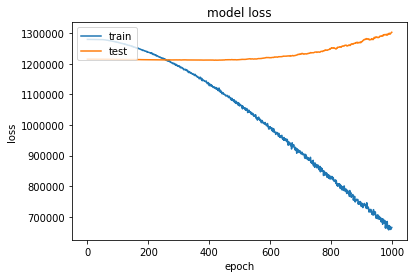

In [107]:
plot_training_history_loss(history, 'gold_nn_reg')

In [108]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

In [109]:
def plot_training_history_mse(history, name):
    # history = model.fit(X, Y, validation_split=0.33, epochs=150, batch_size=10, verbose=0)
    # list all data in history
    print(history.history.keys())
    # summarize history for accuracy
    # plt.plot(history.history['mean_squared_error'])
    plt.plot(history.history['val_mean_squared_error'])
    plt.title('Mean squared error')
    plt.ylabel('MSE')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    # plt.show()
    plt.savefig('figures/' + name + '_keras_mean_squared_error.eps')

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


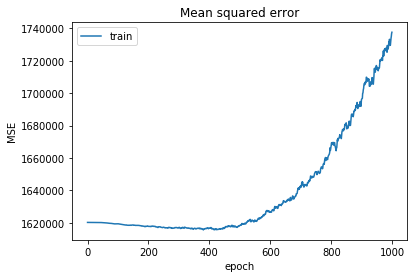

In [110]:
plot_training_history_mse(history, 'gold_nn_reg')

In [111]:
model = regressor_model()
model.load_weights('saved_models/weights.gold_reg.hdf5')
gold_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.1569129087117697
Returns  140.86 %
Number of trades:  72
Number of short trades:  15
Number of long trades:  57
Earnings per trade:  195.65
Earnings per short trade:  205.63
Earnings per long trade:  193.02
Precision score:  [0.53333333 0.02777778 0.59649123]


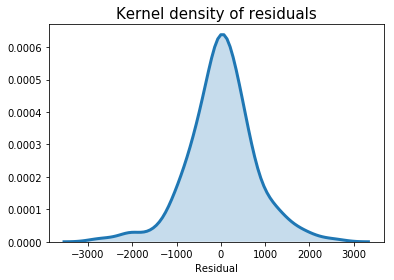

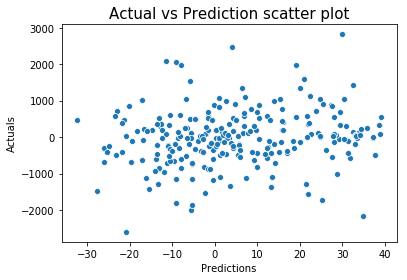

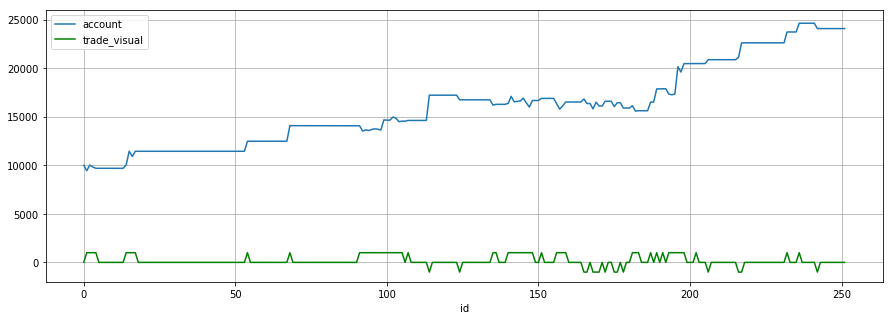

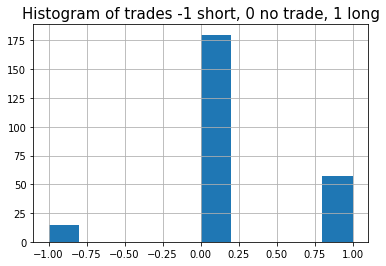

In [181]:
gold_account_nn = get_performance(gold_clf_reg_nn, gold_reg_pca, gold_gains.loc[gold_gains.index > validate_date], gold_reg_validate, gold_reg_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True, target=20, name='gold_nn_reg')

In [127]:
X = pca_transform(corn_reg_train, corn_reg_pca)
y = corn_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(corn_reg_test, corn_reg_pca)
y_test = corn_reg_label_test
# remove outliers
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.corn_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=50, batch_size=50)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1928 samples, validate on 483 samples
Epoch 1/1000
1928/1928 [==============================] - 2s 958us/step - loss: 132379.5148 - mean_squared_error: 176506.0184 - val_loss: 131887.8277 - val_mean_squared_error: 175850.4324

Epoch 00001: val_loss improved from inf to 131887.82767, saving model to saved_models/weights.corn_reg.hdf5
Epoch 2/1000
1928/1928 [==============================] - 0s 125us/step - loss: 132378.9128 - mean_squared_error: 176505.2135 - val_loss: 131888.0264 - val_mean_squared_error: 175850.7015

Epoch 00002: val_loss did not improve from 131887.82767
Epoch 3/1000
1928/1928 [==============================] - 0s 127us/step - loss: 132369.9960 - mean_squared_error: 176493.3273 - val_loss: 131888.0563 - val_mean_squared_error: 175850.7386

Epoch 00003: val_loss did not improve from 131887.82767
Epoch 4/1000
1928/1928 [==============================] - 0s 129us/step - loss: 132365.0731 - mean_squared_error: 176486.7636 - val_loss: 131888.1566 - val_mean_squar

1928/1928 [==============================] - 0s 128us/step - loss: 131807.1196 - mean_squared_error: 175742.8245 - val_loss: 131921.0394 - val_mean_squared_error: 175894.7185

Epoch 00034: val_loss did not improve from 131887.82767
Epoch 35/1000
1928/1928 [==============================] - 0s 128us/step - loss: 131807.2054 - mean_squared_error: 175742.9395 - val_loss: 131923.8050 - val_mean_squared_error: 175898.4051

Epoch 00035: val_loss did not improve from 131887.82767
Epoch 36/1000
1928/1928 [==============================] - 0s 140us/step - loss: 131771.3482 - mean_squared_error: 175695.1288 - val_loss: 131924.7441 - val_mean_squared_error: 175899.6649

Epoch 00036: val_loss did not improve from 131887.82767
Epoch 37/1000
1928/1928 [==============================] - 0s 145us/step - loss: 131712.4830 - mean_squared_error: 175616.6456 - val_loss: 131930.5194 - val_mean_squared_error: 175907.3558

Epoch 00037: val_loss did not improve from 131887.82767
Epoch 38/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 141us/step - loss: 129597.3782 - mean_squared_error: 172796.5078 - val_loss: 131996.4815 - val_mean_squared_error: 175995.3160

Epoch 00067: val_loss did not improve from 131887.82767
Epoch 68/1000
1928/1928 [==============================] - 0s 118us/step - loss: 129679.7203 - mean_squared_error: 172906.2945 - val_loss: 131993.0095 - val_mean_squared_error: 175990.6876

Epoch 00068: val_loss did not improve from 131887.82767
Epoch 69/1000
1928/1928 [==============================] - 0s 117us/step - loss: 129724.9192 - mean_squared_error: 172966.5565 - val_loss: 131989.7033 - val_mean_squared_error: 175986.2741

Epoch 00069: val_loss did not improve from 131887.82767
Epoch 70/1000
1928/1928 [==============================] - 0s 120us/step - loss: 129508.7232 - mean_squared_error: 172678.3010 - val_loss: 132011.5965 - val_mean_squared_error: 176015.4617

Epoch 00070: val_loss did not improve from 131887.82767
Epoch 71/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 121us/step - loss: 126975.1507 - mean_squared_error: 169300.1999 - val_loss: 132098.5328 - val_mean_squared_error: 176131.3794

Epoch 00100: val_loss did not improve from 131887.82767
Epoch 101/1000
1928/1928 [==============================] - 0s 130us/step - loss: 126769.5965 - mean_squared_error: 169026.1266 - val_loss: 132109.9453 - val_mean_squared_error: 176146.5908

Epoch 00101: val_loss did not improve from 131887.82767
Epoch 102/1000
1928/1928 [==============================] - 0s 129us/step - loss: 126625.2056 - mean_squared_error: 168833.6057 - val_loss: 132129.5381 - val_mean_squared_error: 176172.7126

Epoch 00102: val_loss did not improve from 131887.82767
Epoch 103/1000
1928/1928 [==============================] - 0s 123us/step - loss: 126699.5236 - mean_squared_error: 168932.7001 - val_loss: 132143.6281 - val_mean_squared_error: 176191.5067

Epoch 00103: val_loss did not improve from 131887.82767
Epoch 104/1000
1928/1928 [=

1928/1928 [==============================] - 0s 121us/step - loss: 123513.3357 - mean_squared_error: 164684.4480 - val_loss: 132262.8637 - val_mean_squared_error: 176350.4871

Epoch 00133: val_loss did not improve from 131887.82767
Epoch 134/1000
1928/1928 [==============================] - 0s 139us/step - loss: 123424.9868 - mean_squared_error: 164566.6508 - val_loss: 132285.2328 - val_mean_squared_error: 176380.3073

Epoch 00134: val_loss did not improve from 131887.82767
Epoch 135/1000
1928/1928 [==============================] - 0s 143us/step - loss: 123162.5140 - mean_squared_error: 164216.6851 - val_loss: 132273.6813 - val_mean_squared_error: 176364.9038

Epoch 00135: val_loss did not improve from 131887.82767
Epoch 136/1000
1928/1928 [==============================] - 0s 134us/step - loss: 123209.7384 - mean_squared_error: 164279.6496 - val_loss: 132271.7658 - val_mean_squared_error: 176362.3479

Epoch 00136: val_loss did not improve from 131887.82767
Epoch 137/1000
1928/1928 [=

1928/1928 [==============================] - 0s 126us/step - loss: 119798.7094 - mean_squared_error: 159731.6124 - val_loss: 132543.3224 - val_mean_squared_error: 176724.4216

Epoch 00166: val_loss did not improve from 131887.82767
Epoch 167/1000
1928/1928 [==============================] - 0s 131us/step - loss: 119938.4380 - mean_squared_error: 159917.9193 - val_loss: 132570.3701 - val_mean_squared_error: 176760.4938

Epoch 00167: val_loss did not improve from 131887.82767
Epoch 168/1000
1928/1928 [==============================] - 0s 139us/step - loss: 119949.2479 - mean_squared_error: 159932.3304 - val_loss: 132603.1480 - val_mean_squared_error: 176804.1912

Epoch 00168: val_loss did not improve from 131887.82767
Epoch 169/1000
1928/1928 [==============================] - 0s 121us/step - loss: 119470.2593 - mean_squared_error: 159293.6786 - val_loss: 132582.8893 - val_mean_squared_error: 176777.1850

Epoch 00169: val_loss did not improve from 131887.82767
Epoch 170/1000
1928/1928 [=

1928/1928 [==============================] - 0s 152us/step - loss: 115939.0817 - mean_squared_error: 154585.4413 - val_loss: 132904.9949 - val_mean_squared_error: 177206.6521

Epoch 00199: val_loss did not improve from 131887.82767
Epoch 200/1000
1928/1928 [==============================] - 0s 156us/step - loss: 115576.0835 - mean_squared_error: 154101.4458 - val_loss: 132903.9066 - val_mean_squared_error: 177205.2059

Epoch 00200: val_loss did not improve from 131887.82767
Epoch 201/1000
1928/1928 [==============================] - 0s 171us/step - loss: 115696.5708 - mean_squared_error: 154262.0908 - val_loss: 132965.2994 - val_mean_squared_error: 177287.0693

Epoch 00201: val_loss did not improve from 131887.82767
Epoch 202/1000
1928/1928 [==============================] - 0s 171us/step - loss: 115267.0027 - mean_squared_error: 153689.3395 - val_loss: 133009.9668 - val_mean_squared_error: 177346.6204

Epoch 00202: val_loss did not improve from 131887.82767
Epoch 203/1000
1928/1928 [=

1928/1928 [==============================] - 0s 138us/step - loss: 110971.5256 - mean_squared_error: 147962.0335 - val_loss: 133591.0846 - val_mean_squared_error: 178121.4408

Epoch 00232: val_loss did not improve from 131887.82767
Epoch 233/1000
1928/1928 [==============================] - 0s 138us/step - loss: 111571.5078 - mean_squared_error: 148762.0092 - val_loss: 133593.1633 - val_mean_squared_error: 178124.2105

Epoch 00233: val_loss did not improve from 131887.82767
Epoch 234/1000
1928/1928 [==============================] - 0s 137us/step - loss: 110768.5384 - mean_squared_error: 147691.3850 - val_loss: 133575.0740 - val_mean_squared_error: 178100.1035

Epoch 00234: val_loss did not improve from 131887.82767
Epoch 235/1000
1928/1928 [==============================] - 0s 137us/step - loss: 110648.1322 - mean_squared_error: 147530.8416 - val_loss: 133620.1342 - val_mean_squared_error: 178160.1787

Epoch 00235: val_loss did not improve from 131887.82767
Epoch 236/1000
1928/1928 [=

1928/1928 [==============================] - 0s 143us/step - loss: 106494.9734 - mean_squared_error: 141993.3009 - val_loss: 134232.4600 - val_mean_squared_error: 178976.6168

Epoch 00265: val_loss did not improve from 131887.82767
Epoch 266/1000
1928/1928 [==============================] - 0s 142us/step - loss: 106187.5329 - mean_squared_error: 141583.3782 - val_loss: 134255.7267 - val_mean_squared_error: 179007.6400

Epoch 00266: val_loss did not improve from 131887.82767
Epoch 267/1000
1928/1928 [==============================] - 0s 142us/step - loss: 105966.9296 - mean_squared_error: 141289.2414 - val_loss: 134345.7344 - val_mean_squared_error: 179127.6468

Epoch 00267: val_loss did not improve from 131887.82767
Epoch 268/1000
1928/1928 [==============================] - 0s 145us/step - loss: 106856.6007 - mean_squared_error: 142475.4625 - val_loss: 134411.8316 - val_mean_squared_error: 179215.7813

Epoch 00268: val_loss did not improve from 131887.82767
Epoch 269/1000
1928/1928 [=

1928/1928 [==============================] - 0s 122us/step - loss: 101012.8091 - mean_squared_error: 134683.7469 - val_loss: 135020.5461 - val_mean_squared_error: 180027.3942

Epoch 00298: val_loss did not improve from 131887.82767
Epoch 299/1000
1928/1928 [==============================] - 0s 124us/step - loss: 101308.7701 - mean_squared_error: 135078.3587 - val_loss: 135029.3091 - val_mean_squared_error: 180039.0762

Epoch 00299: val_loss did not improve from 131887.82767
Epoch 300/1000
1928/1928 [==============================] - 0s 126us/step - loss: 100884.7286 - mean_squared_error: 134512.9743 - val_loss: 134968.0471 - val_mean_squared_error: 179957.3951

Epoch 00300: val_loss did not improve from 131887.82767
Epoch 301/1000
1928/1928 [==============================] - 0s 137us/step - loss: 101219.9453 - mean_squared_error: 134959.9251 - val_loss: 134986.4125 - val_mean_squared_error: 179981.8789

Epoch 00301: val_loss did not improve from 131887.82767
Epoch 302/1000
1928/1928 [=

1928/1928 [==============================] - 0s 151us/step - loss: 95679.3295 - mean_squared_error: 127572.4395 - val_loss: 136018.8805 - val_mean_squared_error: 181358.5054

Epoch 00331: val_loss did not improve from 131887.82767
Epoch 332/1000
1928/1928 [==============================] - 0s 152us/step - loss: 96019.2457 - mean_squared_error: 128025.6576 - val_loss: 135983.9114 - val_mean_squared_error: 181311.8857

Epoch 00332: val_loss did not improve from 131887.82767
Epoch 333/1000
1928/1928 [==============================] - 0s 152us/step - loss: 94865.8961 - mean_squared_error: 126487.8616 - val_loss: 136107.9522 - val_mean_squared_error: 181477.2730

Epoch 00333: val_loss did not improve from 131887.82767
Epoch 334/1000
1928/1928 [==============================] - 0s 131us/step - loss: 95454.2319 - mean_squared_error: 127272.3112 - val_loss: 136168.2729 - val_mean_squared_error: 181557.6956

Epoch 00334: val_loss did not improve from 131887.82767
Epoch 335/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 151us/step - loss: 90190.0382 - mean_squared_error: 120253.3851 - val_loss: 137132.8042 - val_mean_squared_error: 182843.7409

Epoch 00364: val_loss did not improve from 131887.82767
Epoch 365/1000
1928/1928 [==============================] - 0s 152us/step - loss: 90034.4934 - mean_squared_error: 120045.9940 - val_loss: 137180.5291 - val_mean_squared_error: 182907.3705

Epoch 00365: val_loss did not improve from 131887.82767
Epoch 366/1000
1928/1928 [==============================] - 0s 154us/step - loss: 90178.9310 - mean_squared_error: 120238.5716 - val_loss: 137249.5331 - val_mean_squared_error: 182999.3782

Epoch 00366: val_loss did not improve from 131887.82767
Epoch 367/1000
1928/1928 [==============================] - 0s 154us/step - loss: 90752.6824 - mean_squared_error: 121003.5772 - val_loss: 137258.2754 - val_mean_squared_error: 183011.0319

Epoch 00367: val_loss did not improve from 131887.82767
Epoch 368/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 120us/step - loss: 85057.8072 - mean_squared_error: 113410.4120 - val_loss: 138697.0171 - val_mean_squared_error: 184929.3566

Epoch 00397: val_loss did not improve from 131887.82767
Epoch 398/1000
1928/1928 [==============================] - 0s 114us/step - loss: 84979.3549 - mean_squared_error: 113305.8095 - val_loss: 138861.5431 - val_mean_squared_error: 185148.7313

Epoch 00398: val_loss did not improve from 131887.82767
Epoch 399/1000
1928/1928 [==============================] - 0s 122us/step - loss: 84406.1606 - mean_squared_error: 112541.5474 - val_loss: 138827.4069 - val_mean_squared_error: 185103.2087

Epoch 00399: val_loss did not improve from 131887.82767
Epoch 400/1000
1928/1928 [==============================] - 0s 127us/step - loss: 85551.4189 - mean_squared_error: 114068.5608 - val_loss: 138901.1557 - val_mean_squared_error: 185201.5460

Epoch 00400: val_loss did not improve from 131887.82767
Epoch 401/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 129us/step - loss: 78952.1418 - mean_squared_error: 105269.5229 - val_loss: 140398.0540 - val_mean_squared_error: 187197.4039

Epoch 00430: val_loss did not improve from 131887.82767
Epoch 431/1000
1928/1928 [==============================] - 0s 128us/step - loss: 79499.1112 - mean_squared_error: 105998.8178 - val_loss: 140429.6493 - val_mean_squared_error: 187239.5415

Epoch 00431: val_loss did not improve from 131887.82767
Epoch 432/1000
1928/1928 [==============================] - 0s 128us/step - loss: 79109.3734 - mean_squared_error: 105479.1644 - val_loss: 140373.9953 - val_mean_squared_error: 187165.3202

Epoch 00432: val_loss did not improve from 131887.82767
Epoch 433/1000
1928/1928 [==============================] - 0s 129us/step - loss: 78052.9860 - mean_squared_error: 104070.6481 - val_loss: 140479.2033 - val_mean_squared_error: 187305.5963

Epoch 00433: val_loss did not improve from 131887.82767
Epoch 434/1000
1928/1928 [=====

1928/1928 [==============================] - 0s 135us/step - loss: 74873.8613 - mean_squared_error: 99831.8154 - val_loss: 142730.2272 - val_mean_squared_error: 190306.9628

Epoch 00463: val_loss did not improve from 131887.82767
Epoch 464/1000
1928/1928 [==============================] - 0s 137us/step - loss: 73614.2693 - mean_squared_error: 98152.3595 - val_loss: 142721.0083 - val_mean_squared_error: 190294.6706

Epoch 00464: val_loss did not improve from 131887.82767
Epoch 465/1000
1928/1928 [==============================] - 0s 135us/step - loss: 74419.9533 - mean_squared_error: 99226.6032 - val_loss: 142787.4877 - val_mean_squared_error: 190383.3157

Epoch 00465: val_loss did not improve from 131887.82767
Epoch 466/1000
1928/1928 [==============================] - 0s 135us/step - loss: 73171.8545 - mean_squared_error: 97562.4717 - val_loss: 143070.9687 - val_mean_squared_error: 190761.2945

Epoch 00466: val_loss did not improve from 131887.82767
Epoch 467/1000
1928/1928 [=========


Epoch 00496: val_loss did not improve from 131887.82767
Epoch 497/1000
1928/1928 [==============================] - 0s 137us/step - loss: 68894.7843 - mean_squared_error: 91859.7124 - val_loss: 145170.1288 - val_mean_squared_error: 193560.1725

Epoch 00497: val_loss did not improve from 131887.82767
Epoch 498/1000
1928/1928 [==============================] - 0s 138us/step - loss: 68396.7407 - mean_squared_error: 91195.6537 - val_loss: 144935.3731 - val_mean_squared_error: 193247.1670

Epoch 00498: val_loss did not improve from 131887.82767
Epoch 499/1000
1928/1928 [==============================] - 0s 138us/step - loss: 67388.6199 - mean_squared_error: 89851.4931 - val_loss: 145046.9695 - val_mean_squared_error: 193395.9606

Epoch 00499: val_loss did not improve from 131887.82767
Epoch 500/1000
1928/1928 [==============================] - 0s 142us/step - loss: 67611.6121 - mean_squared_error: 90148.8171 - val_loss: 145044.9810 - val_mean_squared_error: 193393.3069

Epoch 00500: val_lo

1928/1928 [==============================] - 0s 138us/step - loss: 63298.7543 - mean_squared_error: 84398.3396 - val_loss: 147207.6903 - val_mean_squared_error: 196276.9217

Epoch 00530: val_loss did not improve from 131887.82767
Epoch 531/1000
1928/1928 [==============================] - 0s 137us/step - loss: 62664.5919 - mean_squared_error: 83552.7895 - val_loss: 146865.5622 - val_mean_squared_error: 195820.7381

Epoch 00531: val_loss did not improve from 131887.82767
Epoch 532/1000
1928/1928 [==============================] - 0s 137us/step - loss: 61965.7103 - mean_squared_error: 82620.9481 - val_loss: 147372.0463 - val_mean_squared_error: 196496.0682

Epoch 00532: val_loss did not improve from 131887.82767
Epoch 533/1000
1928/1928 [==============================] - 0s 137us/step - loss: 63064.2717 - mean_squared_error: 84085.6950 - val_loss: 147785.8238 - val_mean_squared_error: 197047.7622

Epoch 00533: val_loss did not improve from 131887.82767
Epoch 534/1000
1928/1928 [=========


Epoch 00563: val_loss did not improve from 131887.82767
Epoch 564/1000
1928/1928 [==============================] - 0s 121us/step - loss: 57673.8358 - mean_squared_error: 76898.4470 - val_loss: 150609.2587 - val_mean_squared_error: 200812.3413

Epoch 00564: val_loss did not improve from 131887.82767
Epoch 565/1000
1928/1928 [==============================] - 0s 122us/step - loss: 57340.2081 - mean_squared_error: 76453.6105 - val_loss: 150813.8254 - val_mean_squared_error: 201085.1025

Epoch 00565: val_loss did not improve from 131887.82767
Epoch 566/1000
1928/1928 [==============================] - 0s 119us/step - loss: 57904.2213 - mean_squared_error: 77205.6270 - val_loss: 151014.6125 - val_mean_squared_error: 201352.8196

Epoch 00566: val_loss did not improve from 131887.82767
Epoch 567/1000
1928/1928 [==============================] - 0s 117us/step - loss: 58567.4725 - mean_squared_error: 78089.9648 - val_loss: 151430.6815 - val_mean_squared_error: 201907.5820

Epoch 00567: val_lo

1928/1928 [==============================] - 0s 153us/step - loss: 53151.4151 - mean_squared_error: 70868.5534 - val_loss: 155062.8493 - val_mean_squared_error: 206750.4653

Epoch 00597: val_loss did not improve from 131887.82767
Epoch 598/1000
1928/1928 [==============================] - 0s 154us/step - loss: 54999.1141 - mean_squared_error: 73332.1526 - val_loss: 154912.5101 - val_mean_squared_error: 206550.0205

Epoch 00598: val_loss did not improve from 131887.82767
Epoch 599/1000
1928/1928 [==============================] - 0s 142us/step - loss: 51940.7870 - mean_squared_error: 69254.3839 - val_loss: 155161.2681 - val_mean_squared_error: 206881.6912

Epoch 00599: val_loss did not improve from 131887.82767
Epoch 600/1000
1928/1928 [==============================] - 0s 115us/step - loss: 51450.2577 - mean_squared_error: 68600.3433 - val_loss: 155149.6751 - val_mean_squared_error: 206866.2444

Epoch 00600: val_loss did not improve from 131887.82767
Epoch 601/1000
1928/1928 [=========


Epoch 00630: val_loss did not improve from 131887.82767
Epoch 631/1000
1928/1928 [==============================] - 0s 125us/step - loss: 47735.1263 - mean_squared_error: 63646.8356 - val_loss: 159573.3601 - val_mean_squared_error: 212764.4765

Epoch 00631: val_loss did not improve from 131887.82767
Epoch 632/1000
1928/1928 [==============================] - 0s 121us/step - loss: 48323.1862 - mean_squared_error: 64430.9163 - val_loss: 159561.3553 - val_mean_squared_error: 212748.4770

Epoch 00632: val_loss did not improve from 131887.82767
Epoch 633/1000
1928/1928 [==============================] - 0s 121us/step - loss: 47881.0465 - mean_squared_error: 63841.3953 - val_loss: 159536.8465 - val_mean_squared_error: 212715.7900

Epoch 00633: val_loss did not improve from 131887.82767
Epoch 634/1000
1928/1928 [==============================] - 0s 120us/step - loss: 47422.2926 - mean_squared_error: 63229.7218 - val_loss: 159342.0920 - val_mean_squared_error: 212456.1205

Epoch 00634: val_lo

1928/1928 [==============================] - 0s 125us/step - loss: 43983.1876 - mean_squared_error: 58644.2506 - val_loss: 163413.2276 - val_mean_squared_error: 217884.3034

Epoch 00664: val_loss did not improve from 131887.82767
Epoch 665/1000
1928/1928 [==============================] - 0s 128us/step - loss: 43668.4850 - mean_squared_error: 58224.6461 - val_loss: 163288.1998 - val_mean_squared_error: 217717.6036

Epoch 00665: val_loss did not improve from 131887.82767
Epoch 666/1000
1928/1928 [==============================] - 0s 123us/step - loss: 45096.2629 - mean_squared_error: 60128.3499 - val_loss: 163453.2406 - val_mean_squared_error: 217937.6565

Epoch 00666: val_loss did not improve from 131887.82767
Epoch 667/1000
1928/1928 [==============================] - 0s 121us/step - loss: 42763.4690 - mean_squared_error: 57017.9592 - val_loss: 163303.3867 - val_mean_squared_error: 217737.8459

Epoch 00667: val_loss did not improve from 131887.82767
Epoch 668/1000
1928/1928 [=========


Epoch 00697: val_loss did not improve from 131887.82767
Epoch 698/1000
1928/1928 [==============================] - 0s 129us/step - loss: 40518.6819 - mean_squared_error: 54024.9087 - val_loss: 167237.9804 - val_mean_squared_error: 222983.9818

Epoch 00698: val_loss did not improve from 131887.82767
Epoch 699/1000
1928/1928 [==============================] - 0s 132us/step - loss: 41309.2388 - mean_squared_error: 55078.9862 - val_loss: 166973.5836 - val_mean_squared_error: 222631.4535

Epoch 00699: val_loss did not improve from 131887.82767
Epoch 700/1000
1928/1928 [==============================] - 0s 129us/step - loss: 40054.0511 - mean_squared_error: 53405.4007 - val_loss: 167024.7596 - val_mean_squared_error: 222699.6682

Epoch 00700: val_loss did not improve from 131887.82767
Epoch 701/1000
1928/1928 [==============================] - 0s 130us/step - loss: 39654.0860 - mean_squared_error: 52872.1155 - val_loss: 167718.9115 - val_mean_squared_error: 223625.2128

Epoch 00701: val_lo

1928/1928 [==============================] - 0s 131us/step - loss: 38275.0148 - mean_squared_error: 51033.3535 - val_loss: 172337.3626 - val_mean_squared_error: 229783.1465

Epoch 00731: val_loss did not improve from 131887.82767
Epoch 732/1000
1928/1928 [==============================] - 0s 131us/step - loss: 37673.9370 - mean_squared_error: 50231.9156 - val_loss: 172608.0923 - val_mean_squared_error: 230144.1266

Epoch 00732: val_loss did not improve from 131887.82767
Epoch 733/1000
1928/1928 [==============================] - 0s 130us/step - loss: 36552.4821 - mean_squared_error: 48736.6429 - val_loss: 173348.9749 - val_mean_squared_error: 231131.9613

Epoch 00733: val_loss did not improve from 131887.82767
Epoch 734/1000
1928/1928 [==============================] - 0s 131us/step - loss: 35468.6064 - mean_squared_error: 47291.4744 - val_loss: 173025.2505 - val_mean_squared_error: 230700.3312

Epoch 00734: val_loss did not improve from 131887.82767
Epoch 735/1000
1928/1928 [=========


Epoch 00764: val_loss did not improve from 131887.82767
Epoch 765/1000
1928/1928 [==============================] - 0s 124us/step - loss: 33909.3347 - mean_squared_error: 45212.4465 - val_loss: 178001.0097 - val_mean_squared_error: 237334.6667

Epoch 00765: val_loss did not improve from 131887.82767
Epoch 766/1000
1928/1928 [==============================] - 0s 124us/step - loss: 35288.2054 - mean_squared_error: 47050.9412 - val_loss: 177545.9374 - val_mean_squared_error: 236727.9181

Epoch 00766: val_loss did not improve from 131887.82767
Epoch 767/1000
1928/1928 [==============================] - 0s 123us/step - loss: 34084.4868 - mean_squared_error: 45445.9826 - val_loss: 177895.7414 - val_mean_squared_error: 237194.3232

Epoch 00767: val_loss did not improve from 131887.82767
Epoch 768/1000
1928/1928 [==============================] - 0s 129us/step - loss: 33214.2860 - mean_squared_error: 44285.7153 - val_loss: 177695.1079 - val_mean_squared_error: 236926.8090

Epoch 00768: val_lo

1928/1928 [==============================] - 0s 115us/step - loss: 30341.6537 - mean_squared_error: 40455.5394 - val_loss: 182136.1637 - val_mean_squared_error: 242848.2153

Epoch 00798: val_loss did not improve from 131887.82767
Epoch 799/1000
1928/1928 [==============================] - 0s 115us/step - loss: 30834.6893 - mean_squared_error: 41112.9194 - val_loss: 182748.7353 - val_mean_squared_error: 243664.9778

Epoch 00799: val_loss did not improve from 131887.82767
Epoch 800/1000
1928/1928 [==============================] - 0s 115us/step - loss: 32044.3467 - mean_squared_error: 42725.7951 - val_loss: 182404.3737 - val_mean_squared_error: 243205.8361

Epoch 00800: val_loss did not improve from 131887.82767
Epoch 801/1000
1928/1928 [==============================] - 0s 126us/step - loss: 31921.5921 - mean_squared_error: 42562.1228 - val_loss: 183087.4911 - val_mean_squared_error: 244116.6661

Epoch 00801: val_loss did not improve from 131887.82767
Epoch 802/1000
1928/1928 [=========


Epoch 00831: val_loss did not improve from 131887.82767
Epoch 832/1000
1928/1928 [==============================] - 0s 170us/step - loss: 29785.1866 - mean_squared_error: 39713.5832 - val_loss: 188126.5523 - val_mean_squared_error: 250835.3942

Epoch 00832: val_loss did not improve from 131887.82767
Epoch 833/1000
1928/1928 [==============================] - 0s 171us/step - loss: 28213.7088 - mean_squared_error: 37618.2780 - val_loss: 188285.1140 - val_mean_squared_error: 251046.8220

Epoch 00833: val_loss did not improve from 131887.82767
Epoch 834/1000
1928/1928 [==============================] - 0s 179us/step - loss: 29630.0887 - mean_squared_error: 39506.7843 - val_loss: 187664.3029 - val_mean_squared_error: 250219.0612

Epoch 00834: val_loss did not improve from 131887.82767
Epoch 835/1000
1928/1928 [==============================] - 0s 194us/step - loss: 28516.0482 - mean_squared_error: 38021.3981 - val_loss: 187169.3486 - val_mean_squared_error: 249559.1383

Epoch 00835: val_lo

1928/1928 [==============================] - 0s 125us/step - loss: 26503.0678 - mean_squared_error: 35337.4237 - val_loss: 191607.2111 - val_mean_squared_error: 255476.2824

Epoch 00865: val_loss did not improve from 131887.82767
Epoch 866/1000
1928/1928 [==============================] - 0s 132us/step - loss: 26874.5575 - mean_squared_error: 35832.7444 - val_loss: 192916.0473 - val_mean_squared_error: 257221.3901

Epoch 00866: val_loss did not improve from 131887.82767
Epoch 867/1000
1928/1928 [==============================] - 0s 123us/step - loss: 27096.7192 - mean_squared_error: 36128.9587 - val_loss: 193727.9718 - val_mean_squared_error: 258303.9629

Epoch 00867: val_loss did not improve from 131887.82767
Epoch 868/1000
1928/1928 [==============================] - 0s 125us/step - loss: 29072.0271 - mean_squared_error: 38762.7038 - val_loss: 194375.9670 - val_mean_squared_error: 259167.9464

Epoch 00868: val_loss did not improve from 131887.82767
Epoch 869/1000
1928/1928 [=========


Epoch 00898: val_loss did not improve from 131887.82767
Epoch 899/1000
1928/1928 [==============================] - 0s 122us/step - loss: 26210.6482 - mean_squared_error: 34947.5306 - val_loss: 198642.8230 - val_mean_squared_error: 264857.0836

Epoch 00899: val_loss did not improve from 131887.82767
Epoch 900/1000
1928/1928 [==============================] - 0s 136us/step - loss: 24355.7016 - mean_squared_error: 32474.2689 - val_loss: 200075.6690 - val_mean_squared_error: 266767.5463

Epoch 00900: val_loss did not improve from 131887.82767
Epoch 901/1000
1928/1928 [==============================] - 0s 129us/step - loss: 26015.4196 - mean_squared_error: 34687.2257 - val_loss: 198630.0083 - val_mean_squared_error: 264840.0084

Epoch 00901: val_loss did not improve from 131887.82767
Epoch 902/1000
1928/1928 [==============================] - 0s 127us/step - loss: 25755.5831 - mean_squared_error: 34340.7779 - val_loss: 197848.2944 - val_mean_squared_error: 263797.7218

Epoch 00902: val_lo

1928/1928 [==============================] - 0s 124us/step - loss: 24205.9945 - mean_squared_error: 32274.6598 - val_loss: 203111.4584 - val_mean_squared_error: 270815.2696

Epoch 00932: val_loss did not improve from 131887.82767
Epoch 933/1000
1928/1928 [==============================] - 0s 123us/step - loss: 23927.3648 - mean_squared_error: 31903.1524 - val_loss: 202490.8543 - val_mean_squared_error: 269987.8068

Epoch 00933: val_loss did not improve from 131887.82767
Epoch 934/1000
1928/1928 [==============================] - 0s 120us/step - loss: 23503.2310 - mean_squared_error: 31337.6415 - val_loss: 202188.1433 - val_mean_squared_error: 269584.1838

Epoch 00934: val_loss did not improve from 131887.82767
Epoch 935/1000
1928/1928 [==============================] - 0s 122us/step - loss: 25037.2777 - mean_squared_error: 33383.0363 - val_loss: 203345.3907 - val_mean_squared_error: 271127.1784

Epoch 00935: val_loss did not improve from 131887.82767
Epoch 936/1000
1928/1928 [=========


Epoch 00965: val_loss did not improve from 131887.82767
Epoch 966/1000
1928/1928 [==============================] - 0s 121us/step - loss: 23053.6482 - mean_squared_error: 30738.1976 - val_loss: 204686.1396 - val_mean_squared_error: 272914.8565

Epoch 00966: val_loss did not improve from 131887.82767
Epoch 967/1000
1928/1928 [==============================] - 0s 122us/step - loss: 23804.3195 - mean_squared_error: 31739.0915 - val_loss: 204154.8534 - val_mean_squared_error: 272206.4780

Epoch 00967: val_loss did not improve from 131887.82767
Epoch 968/1000
1928/1928 [==============================] - 0s 121us/step - loss: 23023.2300 - mean_squared_error: 30697.6409 - val_loss: 204380.2498 - val_mean_squared_error: 272507.0084

Epoch 00968: val_loss did not improve from 131887.82767
Epoch 969/1000
1928/1928 [==============================] - 0s 121us/step - loss: 23922.7356 - mean_squared_error: 31896.9808 - val_loss: 204339.9075 - val_mean_squared_error: 272453.2057

Epoch 00969: val_lo

1928/1928 [==============================] - 0s 121us/step - loss: 21986.7717 - mean_squared_error: 29315.6957 - val_loss: 209624.3134 - val_mean_squared_error: 279499.0950

Epoch 00999: val_loss did not improve from 131887.82767
Epoch 1000/1000
1928/1928 [==============================] - 0s 121us/step - loss: 21221.4305 - mean_squared_error: 28295.2403 - val_loss: 209808.7034 - val_mean_squared_error: 279744.9383

Epoch 01000: val_loss did not improve from 131887.82767


In [128]:
# plot_training_history_acc(history, 'corn_nn_reg')

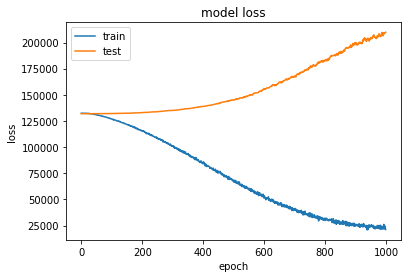

In [129]:
plot_training_history_loss(history, 'corn_nn_reg')

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


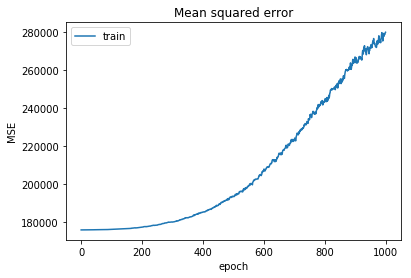

In [130]:
plot_training_history_mse(history, 'corn_nn_reg')

In [131]:
model = regressor_model()
model.load_weights('saved_models/weights.corn_reg.hdf5')
corn_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.06180867572208738
Returns  -3.40 %
Number of trades:  10
Number of short trades:  9
Number of long trades:  1
Earnings per trade:  -34.01
Earnings per short trade:  -46.86
Earnings per long trade:  81.62
Precision score:  [0.55555556 0.02892562 1.        ]


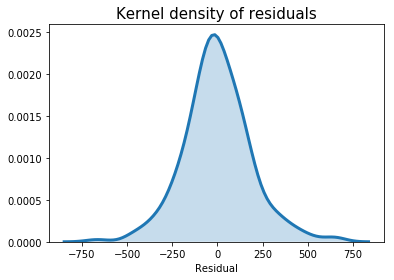

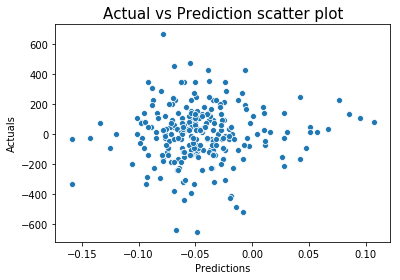

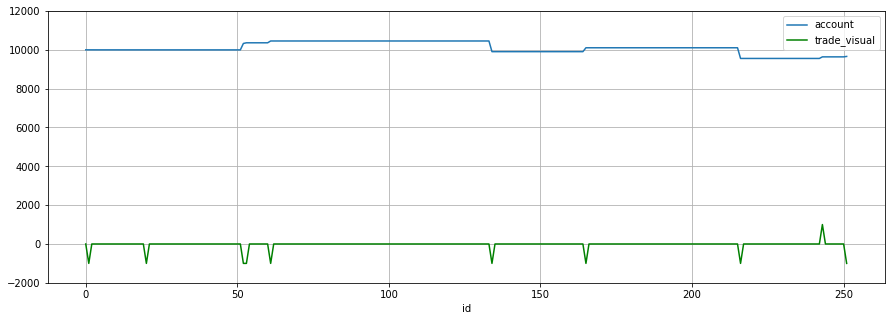

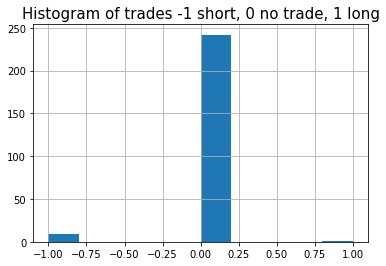

In [132]:
corn_account_nn = get_performance(corn_clf_reg_nn, corn_reg_pca, corn_gains.loc[corn_gains.index > validate_date], corn_reg_validate, corn_reg_label_validate, stop_loss_long=300, stop_loss_short=300, regression=True, target=0.1, name='corn_nn_reg')

In [133]:
X = pca_transform(coffee_reg_train, coffee_reg_pca)
y = coffee_reg_label_train
# remove outliers
X, y = remove_outliers(X, y, out_corn)

X_test = pca_transform(coffee_reg_test, coffee_reg_pca)
y_test = coffee_reg_label_test
X_test, y_test = remove_outliers(X_test, y_test, out_corn)

checkpointer = ModelCheckpoint(filepath='saved_models/weights.coffee_reg.hdf5',
                               monitor='val_loss',
                               verbose=1,
                               save_best_only=True,
                               save_weights_only=True)

estimator = KerasRegressor(build_fn=regressor_model, epochs=epochs, batch_size=batch_size)
history = estimator.fit(X, y, validation_data=(X_test, y_test), batch_size=batch_size, epochs=epochs, callbacks=[checkpointer])

Train on 1922 samples, validate on 481 samples
Epoch 1/1000
1922/1922 [==============================] - 2s 1ms/step - loss: 133702.7529 - mean_squared_error: 178270.3365 - val_loss: 121257.1985 - val_mean_squared_error: 161676.2633

Epoch 00001: val_loss improved from inf to 121257.19850, saving model to saved_models/weights.coffee_reg.hdf5
Epoch 2/1000
1922/1922 [==============================] - 0s 124us/step - loss: 133698.3865 - mean_squared_error: 178264.5152 - val_loss: 121257.8282 - val_mean_squared_error: 161677.1132

Epoch 00002: val_loss did not improve from 121257.19850
Epoch 3/1000
1922/1922 [==============================] - 0s 124us/step - loss: 133697.0071 - mean_squared_error: 178262.6782 - val_loss: 121258.4789 - val_mean_squared_error: 161677.9718

Epoch 00003: val_loss did not improve from 121257.19850
Epoch 4/1000
1922/1922 [==============================] - 0s 125us/step - loss: 133695.0995 - mean_squared_error: 178260.1342 - val_loss: 121258.7070 - val_mean_squar

1922/1922 [==============================] - 0s 127us/step - loss: 133365.4695 - mean_squared_error: 177820.6270 - val_loss: 121381.0049 - val_mean_squared_error: 161841.3399

Epoch 00034: val_loss did not improve from 121257.19850
Epoch 35/1000
1922/1922 [==============================] - 0s 125us/step - loss: 133341.3481 - mean_squared_error: 177788.4652 - val_loss: 121392.2616 - val_mean_squared_error: 161856.3530

Epoch 00035: val_loss did not improve from 121257.19850
Epoch 36/1000
1922/1922 [==============================] - 0s 124us/step - loss: 133306.0907 - mean_squared_error: 177741.4556 - val_loss: 121401.7993 - val_mean_squared_error: 161869.0627

Epoch 00036: val_loss did not improve from 121257.19850
Epoch 37/1000
1922/1922 [==============================] - 0s 124us/step - loss: 133274.9098 - mean_squared_error: 177699.8796 - val_loss: 121403.4093 - val_mean_squared_error: 161871.2132

Epoch 00037: val_loss did not improve from 121257.19850
Epoch 38/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 124us/step - loss: 132184.7326 - mean_squared_error: 176246.3087 - val_loss: 121609.1333 - val_mean_squared_error: 162145.5095

Epoch 00067: val_loss did not improve from 121257.19850
Epoch 68/1000
1922/1922 [==============================] - 0s 124us/step - loss: 132247.4866 - mean_squared_error: 176329.9851 - val_loss: 121611.6476 - val_mean_squared_error: 162148.8633

Epoch 00068: val_loss did not improve from 121257.19850
Epoch 69/1000
1922/1922 [==============================] - 0s 123us/step - loss: 132154.5018 - mean_squared_error: 176206.0060 - val_loss: 121614.3758 - val_mean_squared_error: 162152.5043

Epoch 00069: val_loss did not improve from 121257.19850
Epoch 70/1000
1922/1922 [==============================] - 0s 123us/step - loss: 132180.3770 - mean_squared_error: 176240.5048 - val_loss: 121630.0293 - val_mean_squared_error: 162173.3785

Epoch 00070: val_loss did not improve from 121257.19850
Epoch 71/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 126us/step - loss: 130463.8720 - mean_squared_error: 173951.8285 - val_loss: 121798.3445 - val_mean_squared_error: 162397.7950

Epoch 00100: val_loss did not improve from 121257.19850
Epoch 101/1000
1922/1922 [==============================] - 0s 125us/step - loss: 130428.4918 - mean_squared_error: 173904.6572 - val_loss: 121825.0440 - val_mean_squared_error: 162433.3954

Epoch 00101: val_loss did not improve from 121257.19850
Epoch 102/1000
1922/1922 [==============================] - 0s 123us/step - loss: 130380.6621 - mean_squared_error: 173840.8810 - val_loss: 121824.2338 - val_mean_squared_error: 162432.3153

Epoch 00102: val_loss did not improve from 121257.19850
Epoch 103/1000
1922/1922 [==============================] - 0s 123us/step - loss: 130071.6304 - mean_squared_error: 173428.8389 - val_loss: 121834.1324 - val_mean_squared_error: 162445.5110

Epoch 00103: val_loss did not improve from 121257.19850
Epoch 104/1000
1922/1922 [=

1922/1922 [==============================] - 0s 125us/step - loss: 128128.9103 - mean_squared_error: 170838.5474 - val_loss: 122156.1310 - val_mean_squared_error: 162874.8395

Epoch 00133: val_loss did not improve from 121257.19850
Epoch 134/1000
1922/1922 [==============================] - 0s 123us/step - loss: 127780.2774 - mean_squared_error: 170373.7060 - val_loss: 122133.0797 - val_mean_squared_error: 162844.1031

Epoch 00134: val_loss did not improve from 121257.19850
Epoch 135/1000
1922/1922 [==============================] - 0s 125us/step - loss: 127505.2956 - mean_squared_error: 170007.0593 - val_loss: 122100.8593 - val_mean_squared_error: 162801.1407

Epoch 00135: val_loss did not improve from 121257.19850
Epoch 136/1000
1922/1922 [==============================] - 0s 125us/step - loss: 127735.3444 - mean_squared_error: 170313.7936 - val_loss: 122098.2448 - val_mean_squared_error: 162797.6576

Epoch 00136: val_loss did not improve from 121257.19850
Epoch 137/1000
1922/1922 [=

1922/1922 [==============================] - 0s 125us/step - loss: 124658.4316 - mean_squared_error: 166211.2391 - val_loss: 122415.6350 - val_mean_squared_error: 163220.8393

Epoch 00166: val_loss did not improve from 121257.19850
Epoch 167/1000
1922/1922 [==============================] - 0s 124us/step - loss: 124850.6351 - mean_squared_error: 166467.5162 - val_loss: 122414.4142 - val_mean_squared_error: 163219.2254

Epoch 00167: val_loss did not improve from 121257.19850
Epoch 168/1000
1922/1922 [==============================] - 0s 124us/step - loss: 124805.4304 - mean_squared_error: 166407.2434 - val_loss: 122405.8331 - val_mean_squared_error: 163207.7768

Epoch 00168: val_loss did not improve from 121257.19850
Epoch 169/1000
1922/1922 [==============================] - 0s 123us/step - loss: 124503.8484 - mean_squared_error: 166005.1309 - val_loss: 122403.0409 - val_mean_squared_error: 163204.0552

Epoch 00169: val_loss did not improve from 121257.19850
Epoch 170/1000
1922/1922 [=

1922/1922 [==============================] - 0s 124us/step - loss: 120844.9943 - mean_squared_error: 161126.6594 - val_loss: 122717.9933 - val_mean_squared_error: 163623.9912

Epoch 00199: val_loss did not improve from 121257.19850
Epoch 200/1000
1922/1922 [==============================] - 0s 123us/step - loss: 120766.0067 - mean_squared_error: 161021.3426 - val_loss: 122794.4339 - val_mean_squared_error: 163725.9182

Epoch 00200: val_loss did not improve from 121257.19850
Epoch 201/1000
1922/1922 [==============================] - 0s 124us/step - loss: 121243.2249 - mean_squared_error: 161657.6334 - val_loss: 122851.1404 - val_mean_squared_error: 163801.5150

Epoch 00201: val_loss did not improve from 121257.19850
Epoch 202/1000
1922/1922 [==============================] - 0s 125us/step - loss: 121076.8870 - mean_squared_error: 161435.8497 - val_loss: 122811.8542 - val_mean_squared_error: 163749.1335

Epoch 00202: val_loss did not improve from 121257.19850
Epoch 203/1000
1922/1922 [=

1922/1922 [==============================] - 0s 123us/step - loss: 117721.8234 - mean_squared_error: 156962.4323 - val_loss: 123258.6138 - val_mean_squared_error: 164344.8128

Epoch 00232: val_loss did not improve from 121257.19850
Epoch 233/1000
1922/1922 [==============================] - 0s 124us/step - loss: 117577.2447 - mean_squared_error: 156769.6597 - val_loss: 123242.3855 - val_mean_squared_error: 164323.1852

Epoch 00233: val_loss did not improve from 121257.19850
Epoch 234/1000
1922/1922 [==============================] - 0s 125us/step - loss: 116957.1478 - mean_squared_error: 155942.8615 - val_loss: 123282.9539 - val_mean_squared_error: 164377.2728

Epoch 00234: val_loss did not improve from 121257.19850
Epoch 235/1000
1922/1922 [==============================] - 0s 124us/step - loss: 117036.1552 - mean_squared_error: 156048.2055 - val_loss: 123276.6990 - val_mean_squared_error: 164368.9271

Epoch 00235: val_loss did not improve from 121257.19850
Epoch 236/1000
1922/1922 [=

1922/1922 [==============================] - 0s 127us/step - loss: 112916.8406 - mean_squared_error: 150555.7878 - val_loss: 123812.6962 - val_mean_squared_error: 165083.5999

Epoch 00265: val_loss did not improve from 121257.19850
Epoch 266/1000
1922/1922 [==============================] - 0s 123us/step - loss: 113319.9642 - mean_squared_error: 151093.2870 - val_loss: 123737.8605 - val_mean_squared_error: 164983.8085

Epoch 00266: val_loss did not improve from 121257.19850
Epoch 267/1000
1922/1922 [==============================] - 0s 123us/step - loss: 113403.4115 - mean_squared_error: 151204.5471 - val_loss: 123766.4615 - val_mean_squared_error: 165021.9441

Epoch 00267: val_loss did not improve from 121257.19850
Epoch 268/1000
1922/1922 [==============================] - 0s 126us/step - loss: 112314.3382 - mean_squared_error: 149752.4537 - val_loss: 123733.2088 - val_mean_squared_error: 164977.6170

Epoch 00268: val_loss did not improve from 121257.19850
Epoch 269/1000
1922/1922 [=

1922/1922 [==============================] - 0s 123us/step - loss: 108057.0586 - mean_squared_error: 144076.0788 - val_loss: 124247.5880 - val_mean_squared_error: 165663.4527

Epoch 00298: val_loss did not improve from 121257.19850
Epoch 299/1000
1922/1922 [==============================] - 0s 123us/step - loss: 107232.9163 - mean_squared_error: 142977.2239 - val_loss: 124148.0288 - val_mean_squared_error: 165530.6999

Epoch 00299: val_loss did not improve from 121257.19850
Epoch 300/1000
1922/1922 [==============================] - 0s 124us/step - loss: 108564.1086 - mean_squared_error: 144752.1424 - val_loss: 124252.2328 - val_mean_squared_error: 165669.6381

Epoch 00300: val_loss did not improve from 121257.19850
Epoch 301/1000
1922/1922 [==============================] - 0s 124us/step - loss: 107845.0619 - mean_squared_error: 143793.4153 - val_loss: 124395.3292 - val_mean_squared_error: 165860.4376

Epoch 00301: val_loss did not improve from 121257.19850
Epoch 302/1000
1922/1922 [=

1922/1922 [==============================] - 0s 133us/step - loss: 103764.4315 - mean_squared_error: 138352.5743 - val_loss: 125136.1091 - val_mean_squared_error: 166848.1401

Epoch 00331: val_loss did not improve from 121257.19850
Epoch 332/1000
1922/1922 [==============================] - 0s 134us/step - loss: 103042.8326 - mean_squared_error: 137390.4434 - val_loss: 125120.0703 - val_mean_squared_error: 166826.7567

Epoch 00332: val_loss did not improve from 121257.19850
Epoch 333/1000
1922/1922 [==============================] - 0s 134us/step - loss: 103310.8756 - mean_squared_error: 137747.8333 - val_loss: 125293.4942 - val_mean_squared_error: 167057.9924

Epoch 00333: val_loss did not improve from 121257.19850
Epoch 334/1000
1922/1922 [==============================] - 0s 134us/step - loss: 102954.6176 - mean_squared_error: 137272.8248 - val_loss: 125390.3679 - val_mean_squared_error: 167187.1573

Epoch 00334: val_loss did not improve from 121257.19850
Epoch 335/1000
1922/1922 [=

1922/1922 [==============================] - 0s 134us/step - loss: 98596.6655 - mean_squared_error: 131462.2232 - val_loss: 126322.8493 - val_mean_squared_error: 168430.4632

Epoch 00364: val_loss did not improve from 121257.19850
Epoch 365/1000
1922/1922 [==============================] - 0s 134us/step - loss: 98143.5693 - mean_squared_error: 130858.0936 - val_loss: 126452.4042 - val_mean_squared_error: 168603.2132

Epoch 00365: val_loss did not improve from 121257.19850
Epoch 366/1000
1922/1922 [==============================] - 0s 133us/step - loss: 98395.7418 - mean_squared_error: 131194.3220 - val_loss: 126520.7508 - val_mean_squared_error: 168694.3409

Epoch 00366: val_loss did not improve from 121257.19850
Epoch 367/1000
1922/1922 [==============================] - 0s 135us/step - loss: 97483.2727 - mean_squared_error: 129977.6980 - val_loss: 126284.9221 - val_mean_squared_error: 168379.8971

Epoch 00367: val_loss did not improve from 121257.19850
Epoch 368/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 135us/step - loss: 93251.1405 - mean_squared_error: 124334.8545 - val_loss: 127517.4378 - val_mean_squared_error: 170023.2476

Epoch 00397: val_loss did not improve from 121257.19850
Epoch 398/1000
1922/1922 [==============================] - 0s 136us/step - loss: 92378.5453 - mean_squared_error: 123171.3945 - val_loss: 127348.7498 - val_mean_squared_error: 169798.3389

Epoch 00398: val_loss did not improve from 121257.19850
Epoch 399/1000
1922/1922 [==============================] - 0s 136us/step - loss: 92782.4381 - mean_squared_error: 123709.9156 - val_loss: 127492.4498 - val_mean_squared_error: 169989.9270

Epoch 00399: val_loss did not improve from 121257.19850
Epoch 400/1000
1922/1922 [==============================] - 0s 133us/step - loss: 92317.3658 - mean_squared_error: 123089.8224 - val_loss: 127519.9323 - val_mean_squared_error: 170026.5784

Epoch 00400: val_loss did not improve from 121257.19850
Epoch 401/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 124us/step - loss: 87964.6010 - mean_squared_error: 117286.1330 - val_loss: 128502.6082 - val_mean_squared_error: 171336.8038

Epoch 00430: val_loss did not improve from 121257.19850
Epoch 431/1000
1922/1922 [==============================] - 0s 122us/step - loss: 87626.6197 - mean_squared_error: 116835.4920 - val_loss: 128523.8143 - val_mean_squared_error: 171365.0901

Epoch 00431: val_loss did not improve from 121257.19850
Epoch 432/1000
1922/1922 [==============================] - 0s 124us/step - loss: 87764.6216 - mean_squared_error: 117019.4946 - val_loss: 128892.2991 - val_mean_squared_error: 171856.3980

Epoch 00432: val_loss did not improve from 121257.19850
Epoch 433/1000
1922/1922 [==============================] - 0s 122us/step - loss: 88134.7859 - mean_squared_error: 117513.0474 - val_loss: 129072.0624 - val_mean_squared_error: 172096.0889

Epoch 00433: val_loss did not improve from 121257.19850
Epoch 434/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 123us/step - loss: 83140.6003 - mean_squared_error: 110854.1322 - val_loss: 130655.6706 - val_mean_squared_error: 174207.5587

Epoch 00463: val_loss did not improve from 121257.19850
Epoch 464/1000
1922/1922 [==============================] - 0s 122us/step - loss: 81145.5252 - mean_squared_error: 108194.0364 - val_loss: 130690.6277 - val_mean_squared_error: 174254.1769

Epoch 00464: val_loss did not improve from 121257.19850
Epoch 465/1000
1922/1922 [==============================] - 0s 128us/step - loss: 83332.3915 - mean_squared_error: 111109.8535 - val_loss: 130732.2014 - val_mean_squared_error: 174309.5979

Epoch 00465: val_loss did not improve from 121257.19850
Epoch 466/1000
1922/1922 [==============================] - 0s 124us/step - loss: 83008.0345 - mean_squared_error: 110677.3793 - val_loss: 130796.4179 - val_mean_squared_error: 174395.2219

Epoch 00466: val_loss did not improve from 121257.19850
Epoch 467/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 123us/step - loss: 77713.5485 - mean_squared_error: 103618.0638 - val_loss: 132578.6067 - val_mean_squared_error: 176771.4768

Epoch 00496: val_loss did not improve from 121257.19850
Epoch 497/1000
1922/1922 [==============================] - 0s 125us/step - loss: 75745.2072 - mean_squared_error: 100993.6095 - val_loss: 132790.6089 - val_mean_squared_error: 177054.1417

Epoch 00497: val_loss did not improve from 121257.19850
Epoch 498/1000
1922/1922 [==============================] - 0s 124us/step - loss: 77639.6709 - mean_squared_error: 103519.5593 - val_loss: 132709.8258 - val_mean_squared_error: 176946.4352

Epoch 00498: val_loss did not improve from 121257.19850
Epoch 499/1000
1922/1922 [==============================] - 0s 122us/step - loss: 76969.1014 - mean_squared_error: 102625.4708 - val_loss: 132874.7059 - val_mean_squared_error: 177166.2761

Epoch 00499: val_loss did not improve from 121257.19850
Epoch 500/1000
1922/1922 [=====

1922/1922 [==============================] - 0s 124us/step - loss: 72064.6512 - mean_squared_error: 96086.2032 - val_loss: 134630.4650 - val_mean_squared_error: 179507.2942

Epoch 00529: val_loss did not improve from 121257.19850
Epoch 530/1000
1922/1922 [==============================] - 0s 123us/step - loss: 74037.6505 - mean_squared_error: 98716.8658 - val_loss: 134377.1828 - val_mean_squared_error: 179169.5720

Epoch 00530: val_loss did not improve from 121257.19850
Epoch 531/1000
1922/1922 [==============================] - 0s 126us/step - loss: 73366.9264 - mean_squared_error: 97822.5712 - val_loss: 134497.8996 - val_mean_squared_error: 179330.5322

Epoch 00531: val_loss did not improve from 121257.19850
Epoch 532/1000
1922/1922 [==============================] - 0s 123us/step - loss: 72112.4125 - mean_squared_error: 96149.8829 - val_loss: 134840.6145 - val_mean_squared_error: 179787.4899

Epoch 00532: val_loss did not improve from 121257.19850
Epoch 533/1000
1922/1922 [=========


Epoch 00562: val_loss did not improve from 121257.19850
Epoch 563/1000
1922/1922 [==============================] - 0s 123us/step - loss: 66700.7727 - mean_squared_error: 88934.3619 - val_loss: 137500.9972 - val_mean_squared_error: 183334.6615

Epoch 00563: val_loss did not improve from 121257.19850
Epoch 564/1000
1922/1922 [==============================] - 0s 124us/step - loss: 65269.0031 - mean_squared_error: 87025.3360 - val_loss: 137274.5949 - val_mean_squared_error: 183032.7948

Epoch 00564: val_loss did not improve from 121257.19850
Epoch 565/1000
1922/1922 [==============================] - 0s 123us/step - loss: 66076.1204 - mean_squared_error: 88101.4936 - val_loss: 137553.0650 - val_mean_squared_error: 183404.0821

Epoch 00565: val_loss did not improve from 121257.19850
Epoch 566/1000
1922/1922 [==============================] - 0s 124us/step - loss: 66471.2511 - mean_squared_error: 88628.3348 - val_loss: 137719.9087 - val_mean_squared_error: 183626.5389

Epoch 00566: val_lo

1922/1922 [==============================] - 0s 124us/step - loss: 62090.0829 - mean_squared_error: 82786.7782 - val_loss: 139424.2440 - val_mean_squared_error: 185898.9903

Epoch 00596: val_loss did not improve from 121257.19850
Epoch 597/1000
1922/1922 [==============================] - 0s 122us/step - loss: 63239.0120 - mean_squared_error: 84318.6814 - val_loss: 139857.6580 - val_mean_squared_error: 186476.8814

Epoch 00597: val_loss did not improve from 121257.19850
Epoch 598/1000
1922/1922 [==============================] - 0s 124us/step - loss: 60708.6485 - mean_squared_error: 80944.8647 - val_loss: 139938.0879 - val_mean_squared_error: 186584.1163

Epoch 00598: val_loss did not improve from 121257.19850
Epoch 599/1000
1922/1922 [==============================] - 0s 123us/step - loss: 61647.3327 - mean_squared_error: 82196.4437 - val_loss: 140061.0554 - val_mean_squared_error: 186748.0782

Epoch 00599: val_loss did not improve from 121257.19850
Epoch 600/1000
1922/1922 [=========


Epoch 00629: val_loss did not improve from 121257.19850
Epoch 630/1000
1922/1922 [==============================] - 0s 124us/step - loss: 59509.0178 - mean_squared_error: 79345.3591 - val_loss: 143417.3175 - val_mean_squared_error: 191223.0906

Epoch 00630: val_loss did not improve from 121257.19850
Epoch 631/1000
1922/1922 [==============================] - 0s 130us/step - loss: 56518.3562 - mean_squared_error: 75357.8089 - val_loss: 142550.0765 - val_mean_squared_error: 190066.7729

Epoch 00631: val_loss did not improve from 121257.19850
Epoch 632/1000
1922/1922 [==============================] - 0s 125us/step - loss: 56937.3224 - mean_squared_error: 75916.4301 - val_loss: 142549.3497 - val_mean_squared_error: 190065.7969

Epoch 00632: val_loss did not improve from 121257.19850
Epoch 633/1000
1922/1922 [==============================] - 0s 130us/step - loss: 57342.4526 - mean_squared_error: 76456.6034 - val_loss: 143087.9187 - val_mean_squared_error: 190783.8878

Epoch 00633: val_lo

1922/1922 [==============================] - 0s 122us/step - loss: 53176.7906 - mean_squared_error: 70902.3874 - val_loss: 146471.9809 - val_mean_squared_error: 195295.9792

Epoch 00663: val_loss did not improve from 121257.19850
Epoch 664/1000
1922/1922 [==============================] - 0s 124us/step - loss: 54944.5575 - mean_squared_error: 73259.4105 - val_loss: 146285.5583 - val_mean_squared_error: 195047.4157

Epoch 00664: val_loss did not improve from 121257.19850
Epoch 665/1000
1922/1922 [==============================] - 0s 125us/step - loss: 52600.4928 - mean_squared_error: 70133.9901 - val_loss: 146437.8564 - val_mean_squared_error: 195250.4753

Epoch 00665: val_loss did not improve from 121257.19850
Epoch 666/1000
1922/1922 [==============================] - 0s 122us/step - loss: 52664.2382 - mean_squared_error: 70218.9833 - val_loss: 146055.3289 - val_mean_squared_error: 194740.4472

Epoch 00666: val_loss did not improve from 121257.19850
Epoch 667/1000
1922/1922 [=========


Epoch 00696: val_loss did not improve from 121257.19850
Epoch 697/1000
1922/1922 [==============================] - 0s 126us/step - loss: 48684.9132 - mean_squared_error: 64913.2167 - val_loss: 148628.0536 - val_mean_squared_error: 198170.7377

Epoch 00697: val_loss did not improve from 121257.19850
Epoch 698/1000
1922/1922 [==============================] - 0s 124us/step - loss: 49882.2216 - mean_squared_error: 66509.6299 - val_loss: 149138.0220 - val_mean_squared_error: 198850.6963

Epoch 00698: val_loss did not improve from 121257.19850
Epoch 699/1000
1922/1922 [==============================] - 0s 122us/step - loss: 47979.1941 - mean_squared_error: 63972.2580 - val_loss: 148461.9632 - val_mean_squared_error: 197949.2775

Epoch 00699: val_loss did not improve from 121257.19850
Epoch 700/1000
1922/1922 [==============================] - 0s 124us/step - loss: 46975.6807 - mean_squared_error: 62634.2414 - val_loss: 148618.4798 - val_mean_squared_error: 198157.9725

Epoch 00700: val_lo

1922/1922 [==============================] - 0s 124us/step - loss: 46468.6537 - mean_squared_error: 61958.2044 - val_loss: 153271.8467 - val_mean_squared_error: 204362.4588

Epoch 00730: val_loss did not improve from 121257.19850
Epoch 731/1000
1922/1922 [==============================] - 0s 124us/step - loss: 47316.8664 - mean_squared_error: 63089.1553 - val_loss: 153835.0745 - val_mean_squared_error: 205113.4322

Epoch 00731: val_loss did not improve from 121257.19850
Epoch 732/1000
1922/1922 [==============================] - 0s 123us/step - loss: 46351.0885 - mean_squared_error: 61801.4512 - val_loss: 153253.9127 - val_mean_squared_error: 204338.5481

Epoch 00732: val_loss did not improve from 121257.19850
Epoch 733/1000
1922/1922 [==============================] - 0s 125us/step - loss: 45411.8783 - mean_squared_error: 60549.1714 - val_loss: 153548.0060 - val_mean_squared_error: 204730.6658

Epoch 00733: val_loss did not improve from 121257.19850
Epoch 734/1000
1922/1922 [=========


Epoch 00763: val_loss did not improve from 121257.19850
Epoch 764/1000
1922/1922 [==============================] - 0s 125us/step - loss: 41758.6696 - mean_squared_error: 55678.2277 - val_loss: 157027.0968 - val_mean_squared_error: 209369.4599

Epoch 00764: val_loss did not improve from 121257.19850
Epoch 765/1000
1922/1922 [==============================] - 0s 123us/step - loss: 42127.3932 - mean_squared_error: 56169.8567 - val_loss: 157300.1673 - val_mean_squared_error: 209733.5528

Epoch 00765: val_loss did not improve from 121257.19850
Epoch 766/1000
1922/1922 [==============================] - 0s 123us/step - loss: 41741.1344 - mean_squared_error: 55654.8446 - val_loss: 156767.2983 - val_mean_squared_error: 209023.0682

Epoch 00766: val_loss did not improve from 121257.19850
Epoch 767/1000
1922/1922 [==============================] - 0s 124us/step - loss: 42224.0028 - mean_squared_error: 56298.6701 - val_loss: 157190.9336 - val_mean_squared_error: 209587.9077

Epoch 00767: val_lo

1922/1922 [==============================] - 0s 124us/step - loss: 39723.1761 - mean_squared_error: 52964.2346 - val_loss: 160457.6413 - val_mean_squared_error: 213943.5224

Epoch 00797: val_loss did not improve from 121257.19850
Epoch 798/1000
1922/1922 [==============================] - 0s 123us/step - loss: 39628.7614 - mean_squared_error: 52838.3476 - val_loss: 159975.8600 - val_mean_squared_error: 213301.1477

Epoch 00798: val_loss did not improve from 121257.19850
Epoch 799/1000
1922/1922 [==============================] - 0s 123us/step - loss: 38327.8860 - mean_squared_error: 51103.8470 - val_loss: 159931.7045 - val_mean_squared_error: 213242.2769

Epoch 00799: val_loss did not improve from 121257.19850
Epoch 800/1000
1922/1922 [==============================] - 0s 123us/step - loss: 41152.8575 - mean_squared_error: 54870.4781 - val_loss: 159697.7273 - val_mean_squared_error: 212930.3017

Epoch 00800: val_loss did not improve from 121257.19850
Epoch 801/1000
1922/1922 [=========


Epoch 00830: val_loss did not improve from 121257.19850
Epoch 831/1000
1922/1922 [==============================] - 0s 123us/step - loss: 37638.6247 - mean_squared_error: 50184.8332 - val_loss: 162979.1321 - val_mean_squared_error: 217305.5072

Epoch 00831: val_loss did not improve from 121257.19850
Epoch 832/1000
1922/1922 [==============================] - 0s 122us/step - loss: 35854.5914 - mean_squared_error: 47806.1221 - val_loss: 163418.0098 - val_mean_squared_error: 217890.6783

Epoch 00832: val_loss did not improve from 121257.19850
Epoch 833/1000
1922/1922 [==============================] - 0s 122us/step - loss: 37925.1900 - mean_squared_error: 50566.9200 - val_loss: 164271.7442 - val_mean_squared_error: 219028.9902

Epoch 00833: val_loss did not improve from 121257.19850
Epoch 834/1000
1922/1922 [==============================] - 0s 123us/step - loss: 37067.7255 - mean_squared_error: 49423.6340 - val_loss: 165307.2398 - val_mean_squared_error: 220409.6568

Epoch 00834: val_lo

1922/1922 [==============================] - 0s 123us/step - loss: 34945.3548 - mean_squared_error: 46593.8050 - val_loss: 168803.2215 - val_mean_squared_error: 225070.9611

Epoch 00864: val_loss did not improve from 121257.19850
Epoch 865/1000
1922/1922 [==============================] - 0s 125us/step - loss: 35342.7810 - mean_squared_error: 47123.7087 - val_loss: 168223.7004 - val_mean_squared_error: 224298.2673

Epoch 00865: val_loss did not improve from 121257.19850
Epoch 866/1000
1922/1922 [==============================] - 0s 123us/step - loss: 36614.9161 - mean_squared_error: 48819.8884 - val_loss: 168055.3313 - val_mean_squared_error: 224073.7810

Epoch 00866: val_loss did not improve from 121257.19850
Epoch 867/1000
1922/1922 [==============================] - 0s 125us/step - loss: 35175.6670 - mean_squared_error: 46900.8893 - val_loss: 168725.9535 - val_mean_squared_error: 224967.9250

Epoch 00867: val_loss did not improve from 121257.19850
Epoch 868/1000
1922/1922 [=========


Epoch 00897: val_loss did not improve from 121257.19850
Epoch 898/1000
1922/1922 [==============================] - 0s 125us/step - loss: 34258.4685 - mean_squared_error: 45677.9575 - val_loss: 172028.5323 - val_mean_squared_error: 229371.3844

Epoch 00898: val_loss did not improve from 121257.19850
Epoch 899/1000
1922/1922 [==============================] - 0s 125us/step - loss: 33583.8554 - mean_squared_error: 44778.4741 - val_loss: 173022.1100 - val_mean_squared_error: 230696.1480

Epoch 00899: val_loss did not improve from 121257.19850
Epoch 900/1000
1922/1922 [==============================] - 0s 123us/step - loss: 33411.6797 - mean_squared_error: 44548.9064 - val_loss: 174400.2841 - val_mean_squared_error: 232533.7180

Epoch 00900: val_loss did not improve from 121257.19850
Epoch 901/1000
1922/1922 [==============================] - 0s 125us/step - loss: 31950.8799 - mean_squared_error: 42601.1742 - val_loss: 173958.6332 - val_mean_squared_error: 231944.8449

Epoch 00901: val_lo

1922/1922 [==============================] - 0s 130us/step - loss: 33019.4293 - mean_squared_error: 44025.9064 - val_loss: 175935.4570 - val_mean_squared_error: 234580.6112

Epoch 00931: val_loss did not improve from 121257.19850
Epoch 932/1000
1922/1922 [==============================] - 0s 130us/step - loss: 31869.4490 - mean_squared_error: 42492.5981 - val_loss: 175980.5400 - val_mean_squared_error: 234640.7181

Epoch 00932: val_loss did not improve from 121257.19850
Epoch 933/1000
1922/1922 [==============================] - 0s 139us/step - loss: 31770.2543 - mean_squared_error: 42360.3393 - val_loss: 176293.1434 - val_mean_squared_error: 235057.5282

Epoch 00933: val_loss did not improve from 121257.19850
Epoch 934/1000
1922/1922 [==============================] - 0s 128us/step - loss: 32256.5751 - mean_squared_error: 43008.7664 - val_loss: 175745.0061 - val_mean_squared_error: 234326.6669

Epoch 00934: val_loss did not improve from 121257.19850
Epoch 935/1000
1922/1922 [=========


Epoch 00964: val_loss did not improve from 121257.19850
Epoch 965/1000
1922/1922 [==============================] - 0s 135us/step - loss: 30508.1938 - mean_squared_error: 40677.5922 - val_loss: 179953.8590 - val_mean_squared_error: 239938.4743

Epoch 00965: val_loss did not improve from 121257.19850
Epoch 966/1000
1922/1922 [==============================] - 0s 139us/step - loss: 29229.3174 - mean_squared_error: 38972.4226 - val_loss: 181690.9060 - val_mean_squared_error: 242254.5363

Epoch 00966: val_loss did not improve from 121257.19850
Epoch 967/1000
1922/1922 [==============================] - 0s 125us/step - loss: 29284.6582 - mean_squared_error: 39046.2111 - val_loss: 180137.7321 - val_mean_squared_error: 240183.6539

Epoch 00967: val_loss did not improve from 121257.19850
Epoch 968/1000
1922/1922 [==============================] - 0s 124us/step - loss: 30653.1941 - mean_squared_error: 40870.9256 - val_loss: 180020.3995 - val_mean_squared_error: 240027.1998

Epoch 00968: val_lo

1922/1922 [==============================] - 0s 124us/step - loss: 30385.1422 - mean_squared_error: 40513.5235 - val_loss: 183192.7624 - val_mean_squared_error: 244257.0175

Epoch 00998: val_loss did not improve from 121257.19850
Epoch 999/1000
1922/1922 [==============================] - 0s 124us/step - loss: 30675.5582 - mean_squared_error: 40900.7443 - val_loss: 184575.8717 - val_mean_squared_error: 246101.1528

Epoch 00999: val_loss did not improve from 121257.19850
Epoch 1000/1000
1922/1922 [==============================] - 0s 125us/step - loss: 32726.3328 - mean_squared_error: 43635.1113 - val_loss: 187589.5872 - val_mean_squared_error: 250119.4480

Epoch 01000: val_loss did not improve from 121257.19850


In [134]:
# plot_training_history_acc(history, 'coffee_nn_reg')

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


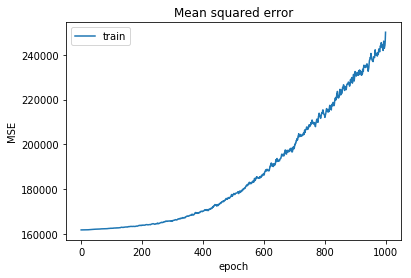

In [135]:
plot_training_history_mse(history, 'coffee_nn_reg')

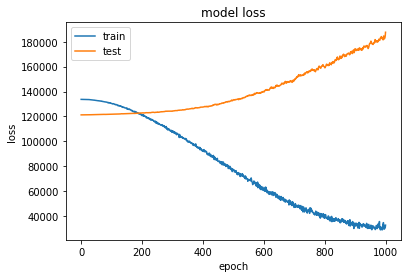

In [136]:
plot_training_history_loss(history, 'coffee_nn_reg')

In [137]:
model = regressor_model()
model.load_weights('saved_models/weights.coffee_reg.hdf5')
coffee_clf_reg_nn = model

Predictions/Actual volatility correlation:  0.026175392501264896
Returns  0.00 %
Number of trades:  0
Number of short trades:  0
Number of long trades:  0
Earnings per trade:  0.00
Earnings per short trade:  0.00
Earnings per long trade:  0.00
Precision score:  [0.         0.03571429 0.        ]


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


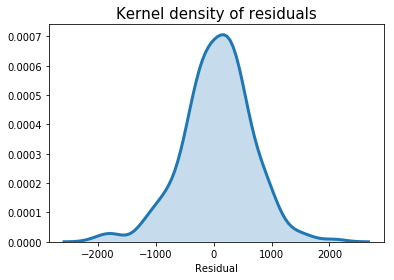

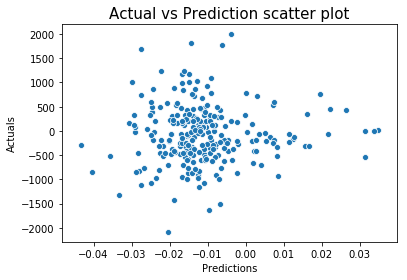

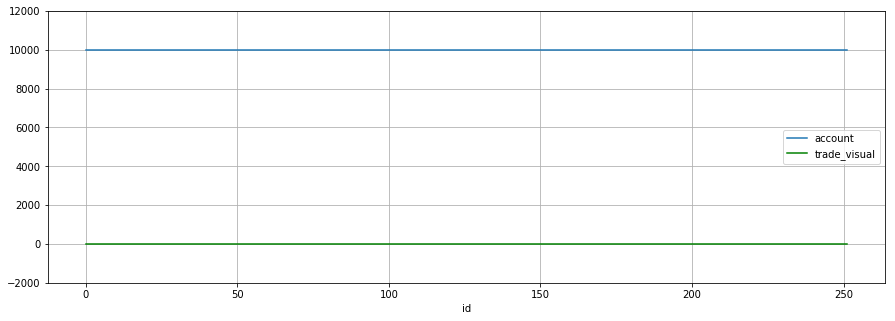

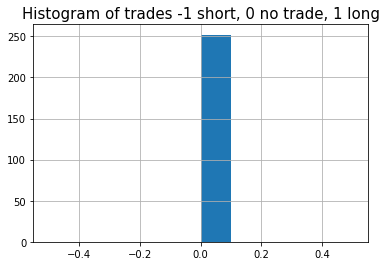

In [138]:
coffee_account_nn = get_performance(coffee_clf_reg_nn, coffee_reg_pca, coffee_gains.loc[coffee_gains.index > validate_date], coffee_reg_validate, coffee_reg_label_validate, stop_loss_long=1000, stop_loss_short=1000, regression=True, target=0.1, name='coffee_nn_reg')

# Conclusions
Only Gold regressor has data that returns positive results. Correlation between actual gold price and predictions is around $0.15$ (depending on training).

Corn and Coffee has rather random correlation with actual performance (also training is not going well).
Last weights update for keras neural network regressor (1000 epochs):

| Gold | Corn | Coffee |
|------|------|--------|
| 512  |   32 | 1      |

I am surprised that I cannot achieve better results with corn. Since corn retained most information by PCA transformation. I expected to have best training results with corn.

# H2O AutoML experiment

In [139]:
import h2o
from h2o.automl import H2OAutoML

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "10.0.2" 2018-07-17; OpenJDK Runtime Environment (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4); OpenJDK 64-Bit Server VM (build 10.0.2+13-Ubuntu-1ubuntu0.18.04.4, mixed mode)
  Starting server from /home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpcs4edpsj
  JVM stdout: /tmp/tmpcs4edpsj/h2o_martin_started_from_python.out
  JVM stderr: /tmp/tmpcs4edpsj/h2o_martin_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Europe/Bratislava
H2O data parsing timezone:,UTC
H2O cluster version:,3.22.1.2
H2O cluster version age:,22 days
H2O cluster name:,H2O_from_python_martin_srgtap
H2O cluster total nodes:,1
H2O cluster free memory:,3.898 Gb
H2O cluster total cores:,6
H2O cluster allowed cores:,6
H2O cluster status:,"accepting new members, healthy"


### Classification
Based on the H2O documentation only 2 categories are supported for AutoML. This model was generated for long trades.

In [140]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_long_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_long_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()
validation[y] = validation[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190210_190303,0.5,0.693147,0.5,0.5,0.25
XRT_1_AutoML_20190210_190303,0.489358,0.649831,0.491267,0.47449,0.225141
StackedEnsemble_BestOfFamily_AutoML_20190210_190303,0.482473,0.607319,0.5,0.456395,0.208296
StackedEnsemble_AllModels_AutoML_20190210_190303,0.482473,0.607319,0.5,0.456395,0.208296
GLM_grid_1_AutoML_20190210_190303_model_1,0.479587,0.607513,0.49148,0.456493,0.208386
DRF_1_AutoML_20190210_190303,0.472127,0.650638,0.494616,0.474203,0.224868


xgboost prediction progress: |████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd580b39e10>]],
      dtype=object)

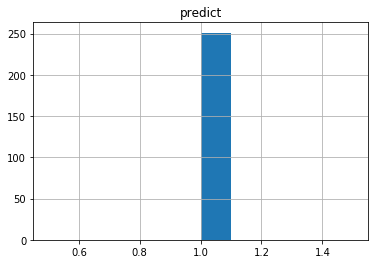

In [141]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  131.44 %
Number of trades:  251
Number of short trades:  0
Number of long trades:  251
Earnings per trade:  52.36
Earnings per short trade:  0.00
Earnings per long trade:  52.36


/home/martin/anaconda3/envs/trading/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision score:  [0.         1.         0.21115538]


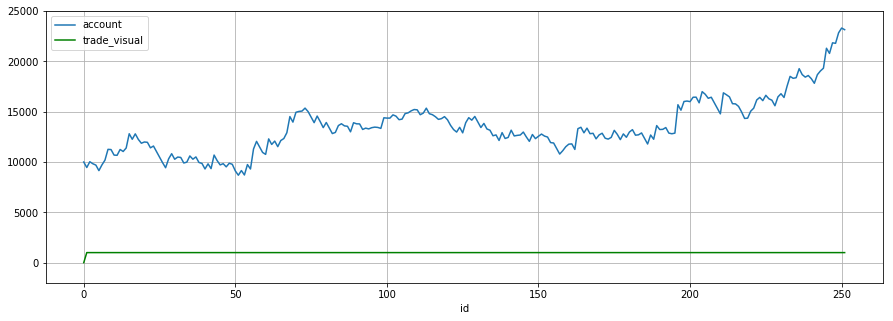

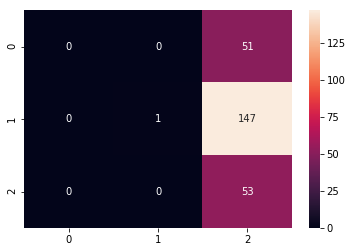

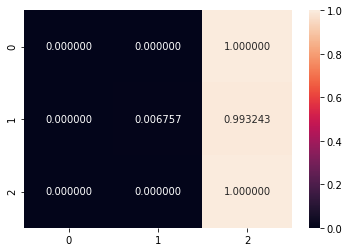

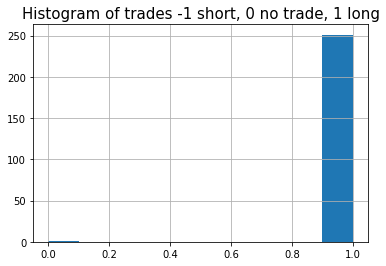

In [142]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, name='gold_long_automl_clf')

### H2O AutoML gold regressor

In [143]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_reg_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_reg_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_reg_test.csv", header=1)

# Identify predictors and response
print(train.head())
x = train.columns
y = "label"
x.remove(y)

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=40, max_runtime_secs=60, seed=1234, stopping_metric='deviance')
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199
-331248,-27640.9,567537,65888,59525.3,252952,55627.9,-128754,107664,-216797,-88334.8,-158876,-132532,109755,-46152.6,-48243.4,102096,-26623.6,30557,96471.9,128856,-45498.6,7400.27,-52095.7,-102416,11413.4,193359,43174.8,2397.14,102818,51492,86161.9,36587.2,-431.163,-59398.9,-16408.3,-31970.8,7392.44,-41167.5,-38087.9,-79022.2,39880,74855.5,59099.8,-57810.6,4571.96,6865.5,69375.7,-24542.1,-2964.83,38010.9,50722.6,-49494,84525.8,-50325.3,1617.01,9757.53,40051,13361,28889.2,64254.2,-927.344,-13659.5,-973.585,57239.3,-14635.2,51039.1,-37447.1,71646.4,12300.9,7308.94,2995.98,66098,-25603.1,118375,-14342.2,23159.5,-106860,-30568.6,66324.5,-28319.3,-19414.8,74039.7,20878.1,-57363.5,-37656.5,15939.3,19836.3,52715.5,35991,40769.2,-14441.3,69806.5,36537.7,-44491.1,-57462,39878.1,25845.4,-8552.88,-6417.83,5903.48,-26696.2,6223.8,25249.4,16073.9,-3946.47,14822.4,-45238.9,-22718.6,-5387.21,63061.7,-21204.8,46718.1,-10246.8,-17679.4,82309.2,10278.2,33819.8,14791.7,-10318.9,38208.1,36031.4,-22415.4,-22948.7,9237.39,-46271.5,-16025.7,-32045.3,11528.7,-14694,-52873.6,65658.5,78371.1,-3786.76,15688.5,-13926,-47534.8,39424.6,-27202.7,-29934.4,-18343.1,20998.2,9208.38,-16001.3,43712.7,-4050.55,-25511,16382.3,-60760.7,3977.03,-19944.2,64013.7,-39727.3,-37917,-13036.8,52607.2,48494.9,38249.9,-88103.1,-40157.5,-36073.4,9875.56,42455.1,42717.8,-17228.2,-902.95,-28762.9,-41110.7,18957.3,-28820.2,15033.3,-17562.3,-8803.51,23882.9,37622.3,-16041.9,26617.1,15831.3,-1452.96,-24442.8,-13424.9,-17986.4,-54551.6,100337,-12982.5,-20857.6,-49309.7,-29425.2,9438.39,-31290.8,20001,74281.2,38789.7,34382.4,-2799.05,-39896.4,32486.2,74129.7,-38974.9,33943.5
-325632,-21861.3,570463,61896.1,12385.8,263138,67919.9,-122209,98093.1,-221691,-106287,-152934,-113510,123914,-42969.4,-38251.7,83308.7,-40120.2,40592,115483,118716,-59971.5,15404.1,-53785.8,-114764,16018.2,177401,-17123,17396.5,124792,34830.4,80182.2,61158.6,-37570.1,-29884.3,-1243.13,-41191.5,25931.6,198.042,-70567.6,2435.07,24739,104129,15369.9,-67739.2,-63275.3,41865.1,42055.7,458.742,-15286.7,3486.52,45515.7,-82916.5,55935.8,-75649.4,-26103.3,2369.58,42338.8,8161.88,64239.1,56469.8,14761.5,-45009.8,17551.6,24207.2,21459,97579.9,16854,104355,-10585.3,-15991.3,-10664.7,79435.3,1332.76,94045.8,-13272.3,40374.8,-26720.8,-46435.1,69752,-29560.7,-20420.7,15062.6,-49836.2,-69314.5,-75523.9,30552.3,30807.6,78707.6,20325.7,73373.8,-9184.14,23539.3,49531.5,-8248.75,-20231,7103.48,21536.8,-42549,12079.5,-10135.3,-38184.1,21524,40226.9,13054.8,38784.9,-46167.2,-17813.3,-19602,-25986.1,7817.18,-32128.9,-23314.1,-50007.2,-49561.8,26797.7,24791.3,78396.3,19204.7,21994.7,-62312.4,-39373.4,38829.6,10357.8,-792.608,163.776,17432.4,-69134,-45877.9,-39993.2,-11836,24834.9,29452.1,55929.8,39657.4,43875.6,31612.3,76769.7,14581.8,15596.5,36543.6,-14573.6,-387.628,23286.4,-29384.7,-7514.05,-19781.8,20652.3,2781.08,-13415.9,23300.7,46168.7,-48293.3,37659.9,68456.3,35566.7,-16892.2,-7713.68,7171.18,-13490.9,21885.4,29476.2,-18953.5,-19306.2,52039.9,-14114.8,-110200,-44815.4,-31763.5,15814.1,-13441.6,23622.1,30740.1,5327.42,45627.3,16424.6,34625.1,-8653.75,-18554,63492.4,28164.3,5081.91,1326.42,-41837,-30386,3184.34,-34923.6,-38657.6,-41088.3,-20688.8,-18062.2,5762.19,-46274.8,-456.058,-35580.8,-13500,-2665.41,15078.1,-39647.8,4789.56
-322972,-16385.8,56900


AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,mean_residual_deviance,rmse,mse,mae,rmsle
XGBoost_1_AutoML_20190210_190426,1.68348e+06,1297.49,1.68348e+06,895.096,nan
GLM_grid_1_AutoML_20190210_190426_model_1,1.68431e+06,1297.81,1.68431e+06,895.899,nan
StackedEnsemble_BestOfFamily_AutoML_20190210_190426,1.68533e+06,1298.2,1.68533e+06,896.418,nan
StackedEnsemble_AllModels_AutoML_20190210_190426,1.68533e+06,1298.2,1.68533e+06,896.418,nan
XRT_1_AutoML_20190210_190426,1.86535e+06,1365.78,1.86535e+06,955.052,nan
DRF_1_AutoML_20190210_190426,1.91745e+06,1384.72,1.91745e+06,975.795,nan


xgboost prediction progress: |████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd580c1ec18>]],
      dtype=object)

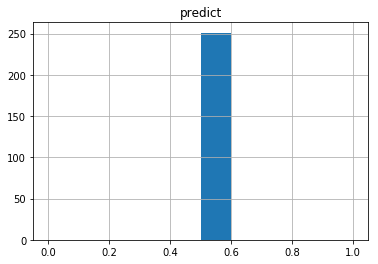

In [144]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

In [145]:
b

array([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5,
       0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.

In [146]:
def trade(x, treshold):
    ans = 0
    if abs(x) > treshold:
        if x > 0:
            ans = 1
        else:
            ans = -1
    return 0



preds = list(map(lambda x: trade(x, 200), b))

In [147]:
print(preds)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [148]:
# gold_account_reg = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800, regression=True,  name='gold_automl_reg')

### H2O short trade

In [149]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/gold_pca_short_train.csv", header=1)
validation = h2o.import_file("data/gold_pca_short_validation.csv", header=1)
test = h2o.import_file("data/gold_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20190210_190548,0.514799,0.644456,0.49188,0.470246,0.221131
XRT_1_AutoML_20190210_190548,0.512713,0.644007,0.490532,0.470221,0.221108
XGBoost_1_AutoML_20190210_190548,0.5,0.693147,0.5,0.5,0.25
GLM_grid_1_AutoML_20190210_190548_model_1,0.493468,0.604427,0.49927,0.454912,0.206945
StackedEnsemble_BestOfFamily_AutoML_20190210_190548,0.479506,0.604492,0.5,0.454945,0.206975
StackedEnsemble_AllModels_AutoML_20190210_190548,0.479506,0.604492,0.5,0.454945,0.206975


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd580ca1400>]],
      dtype=object)

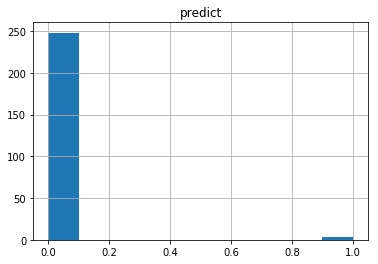

In [150]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = list(map(lambda x: -1 if x > 0 else 0, a.predict.values))
a.hist()

Returns  6.44 %
Number of trades:  3
Number of short trades:  3
Number of long trades:  0
Earnings per trade:  214.67
Earnings per short trade:  214.67
Earnings per long trade:  0.00
Precision score:  [0.66666667 0.59036145 0.        ]


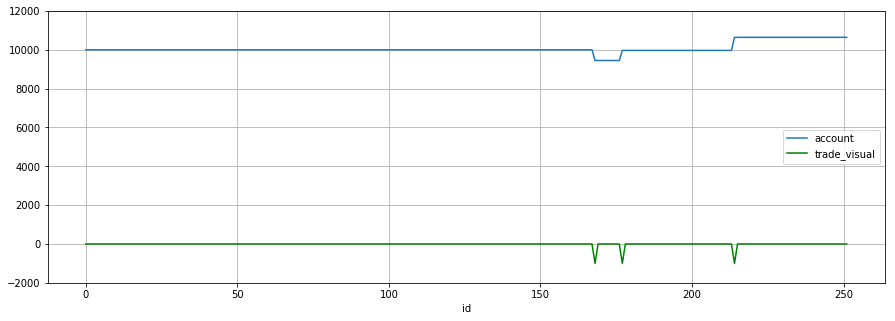

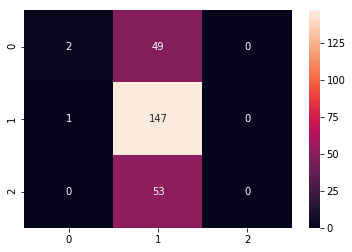

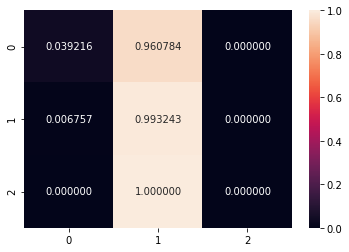

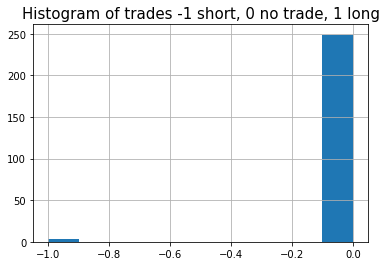

In [151]:
gold_account = get_account(b, gold_gains.loc[gold_gains.index > validate_date], gold_label_validate, stop_loss_long=1000, stop_loss_short=800,  name='gold_automl_short_clf')

In [152]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_short_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_short_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
DRF_1_AutoML_20190210_190706,0.528342,0.660491,0.5,0.464089,0.215378
GLM_grid_1_AutoML_20190210_190706_model_1,0.518063,0.60057,0.490497,0.452982,0.205193
XRT_1_AutoML_20190210_190706,0.514973,0.633006,0.499272,0.4651,0.216318
XGBoost_1_AutoML_20190210_190706,0.5,0.693147,0.5,0.5,0.25
StackedEnsemble_BestOfFamily_AutoML_20190210_190706,0.471911,0.601609,0.5,0.453431,0.2056
StackedEnsemble_AllModels_AutoML_20190210_190706,0.471911,0.601609,0.5,0.453431,0.2056


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd58085afd0>]],
      dtype=object)

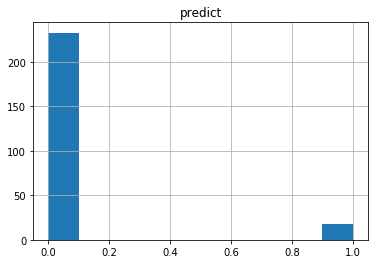

In [153]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x > 0 else 0).values
a.hist()

Returns  11.84 %
Number of trades:  18
Number of short trades:  18
Number of long trades:  0
Earnings per trade:  65.79
Earnings per short trade:  65.79
Earnings per long trade:  0.00
Precision score:  [0.22222222 0.67094017 0.        ]


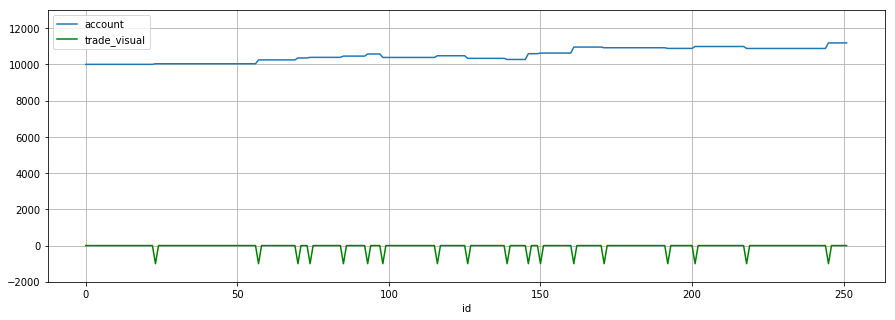

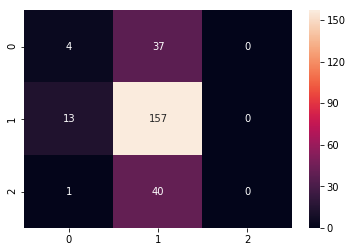

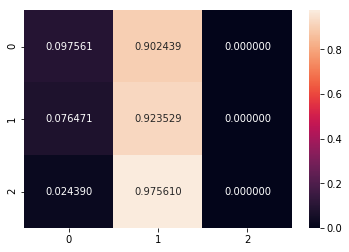

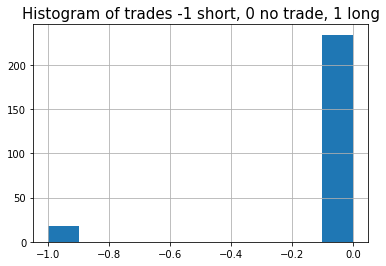

In [154]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_automl_short_clf')

In [155]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/corn_pca_long_train.csv", header=1)
validation = h2o.import_file("data/corn_pca_long_validation.csv", header=1)
test = h2o.import_file("data/corn_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
validation[y] = validation[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XRT_1_AutoML_20190210_190826,0.506634,0.648925,0.498509,0.473999,0.224675
GLM_grid_1_AutoML_20190210_190826_model_1,0.503377,0.61554,0.498445,0.460647,0.212196
XGBoost_1_AutoML_20190210_190826,0.5,0.693147,0.5,0.5,0.25
DRF_1_AutoML_20190210_190826,0.494978,0.669528,0.495359,0.476381,0.226939
StackedEnsemble_AllModels_AutoML_20190210_190826,0.472857,0.615789,0.495399,0.460761,0.212301
StackedEnsemble_BestOfFamily_AutoML_20190210_190826,0.472857,0.615789,0.495399,0.460761,0.212301


drf prediction progress: |████████████████████████████████████████████████| 100%


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd57f3a2828>]],
      dtype=object)

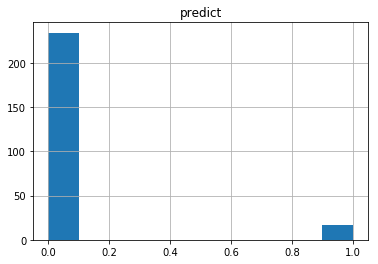

In [156]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

Returns  6.47 %
Number of trades:  17
Number of short trades:  0
Number of long trades:  17
Earnings per trade:  38.05
Earnings per short trade:  0.00
Earnings per long trade:  38.05
Precision score:  [0.         0.68510638 0.35294118]


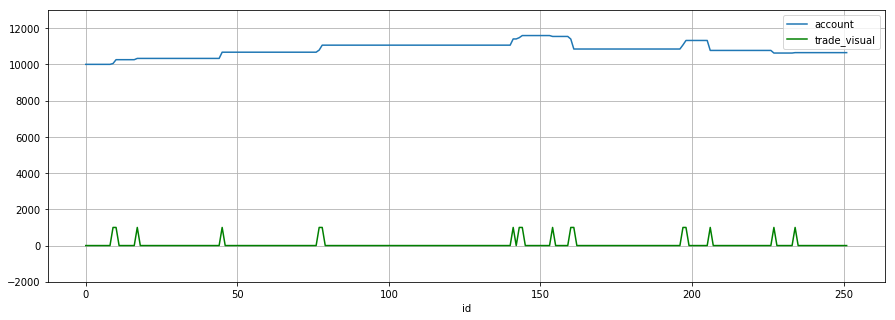

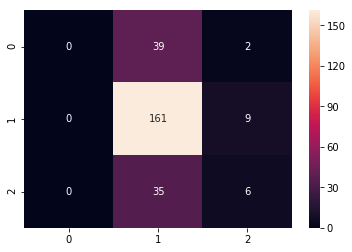

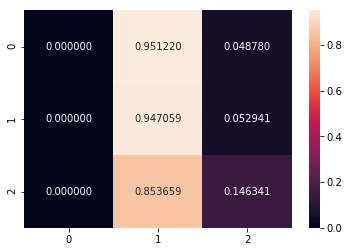

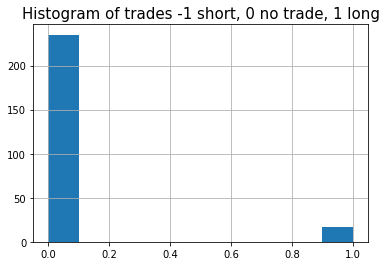

In [158]:
corn_account = get_account(b, corn_gains.loc[corn_gains.index > validate_date], corn_label_validate, stop_loss_long=300, stop_loss_short=300, name='corn_automl_long_clf')

In [159]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_long_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_long_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
GLM_grid_1_AutoML_20190210_191638_model_1,0.527217,0.658517,0.5,0.482574,0.232877
XRT_1_AutoML_20190210_191638,0.51527,0.687282,0.49699,0.495211,0.245234
XGBoost_1_AutoML_20190210_191638,0.5,0.693147,0.5,0.5,0.25
DRF_1_AutoML_20190210_191638,0.49963,0.71331,0.5,0.499027,0.249027
StackedEnsemble_BestOfFamily_AutoML_20190210_191638,0.480183,0.65927,0.499587,0.482954,0.233245
StackedEnsemble_AllModels_AutoML_20190210_191638,0.480183,0.65927,0.499587,0.482954,0.233245


glm prediction progress: |████████████████████████████████████████████████| 100%
Returns  -100.81 %
Number of trades:  89
Number of short trades:  0
Number of long trades:  89
Earnings per trade:  -113.27
Earnings per short trade:  0.00
Earnings per long trade:  -113.27
Precision score:  [0.         0.56338028 0.20224719]


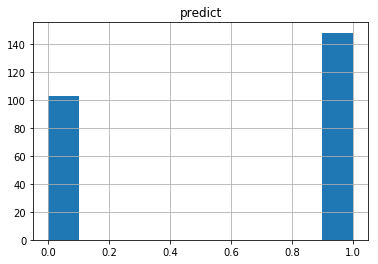

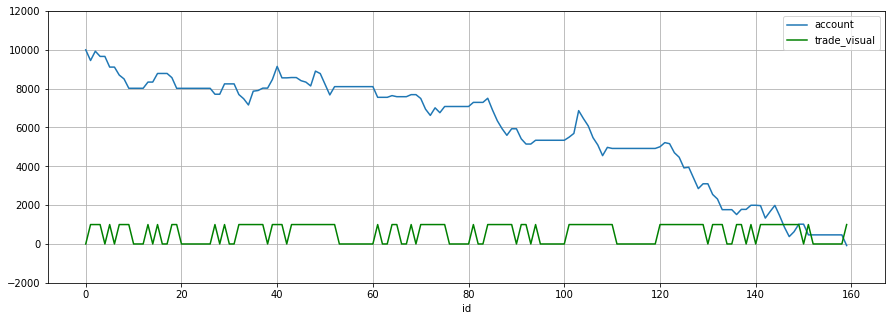

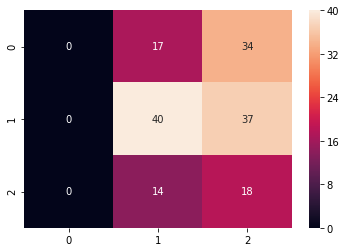

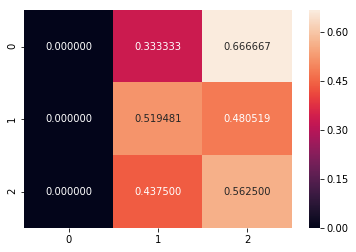

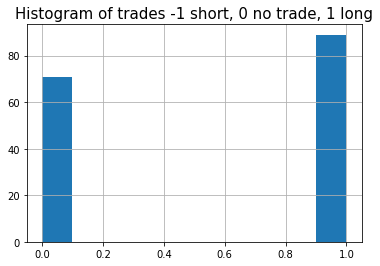

In [161]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, name='coffee_automl_short_clf')

In [162]:
# Import a sample binary outcome train/test set into H2O
train = h2o.import_file("data/coffee_pca_short_train.csv", header=1)
validation = h2o.import_file("data/coffee_pca_long_validation.csv", header=1)
test = h2o.import_file("data/coffee_pca_short_test.csv", header=1)

# Identify predictors and response
x = train.columns
y = "label"
x.remove(y)

# For binary classification, response should be a factor
train[y] = train[y].asfactor()
test[y] = test[y].asfactor()

# Run AutoML for 20 base models (limited to 1 hour max runtime by default)
aml = H2OAutoML(max_models=20, max_runtime_secs=60, seed=1234)
aml.train(x=x, y=y, training_frame=train, validation_frame=validation)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb.head(rows=lb.nrows)  # Print all rows instead of default (10 rows)

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,mean_per_class_error,rmse,mse
XGBoost_1_AutoML_20190210_191924,0.5,0.693147,0.5,0.5,0.25
GLM_grid_1_AutoML_20190210_191924_model_1,0.498935,0.666653,0.498733,0.486688,0.236866
DRF_1_AutoML_20190210_191924,0.496928,0.706637,0.498733,0.503576,0.253589
XRT_1_AutoML_20190210_191924,0.493407,0.704369,0.499578,0.502743,0.25275
StackedEnsemble_BestOfFamily_AutoML_20190210_191924,0.47347,0.666722,0.5,0.486717,0.236894
StackedEnsemble_AllModels_AutoML_20190210_191924,0.47347,0.666722,0.5,0.486717,0.236894


xgboost prediction progress: |████████████████████████████████████████████| 100%
Returns  204.45 %
Number of trades:  251
Number of short trades:  251
Number of long trades:  0
Earnings per trade:  81.45
Earnings per short trade:  81.45
Earnings per long trade:  0.00
Precision score:  [0.35856574 1.         0.        ]


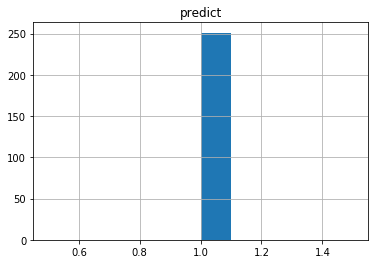

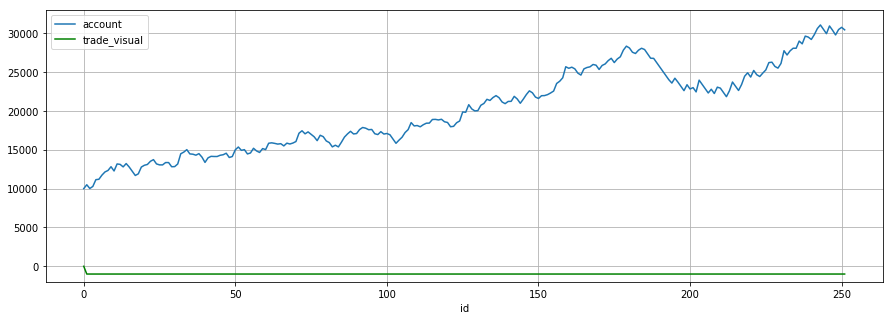

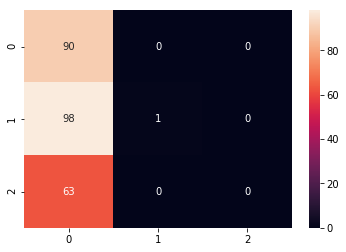

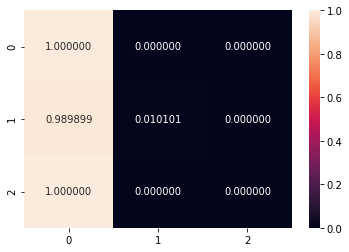

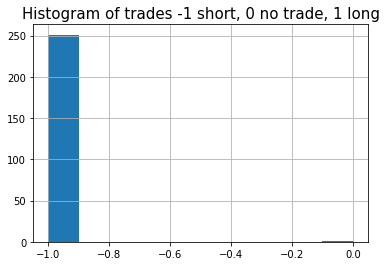

In [164]:
preds = aml.leader.predict(test)
a = preds[0].as_data_frame()
b = a.predict.map(lambda x: -1 if x == 1 else 0).values
a.hist()

coffee_account = get_account(b, coffee_gains.loc[coffee_gains.index > validate_date], coffee_label_validate, stop_loss_long=800, stop_loss_short=800, name='coffee_automl_short_clf')

# H2O AutoML conclusion

AutoML regression results were very disappointing since all the predictions for gold were around -26 (which is mean value of training data). Classifiers seems to work better. I think you could get some information but overall I think it is necessary to get insight into the data.

In [165]:
# mean reversal
# Compute the z-scores for each day using the historical data up to that day
def mean_reversal_account(df, df_gains, trade_days=1):
    account = 10000
    direction = gold['mean_direction'].values[0]
    dct = {}
    dct['account'] = [account]
    trade = 0
    for d, v in zip(df['mean_direction'].values, gold_gains.values):
        if d >= 0 and direction <= 0:
            account -= v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        elif d <= 0 and direction >= 0:
            direction = d
            account += v[0]
            trade += 1
            if trade_days == trade:
                direction = d
                trade = 0
        dct['account'].append(account)
        if account <= 0:
            break
    return pd.DataFrame.from_dict(dct)

def mean_calculation(df, big_range, small_range):
    big_mean = 'mean_' + str(big_range)
    small_mean = 'mean_' + str(small_range)
    df[big_mean] = df.rolling(str(big_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df[small_mean] = df.rolling(str(small_range) + 'd')['Settle'].apply(np.mean, raw=False)
    df['mean_direction'] =  df[small_mean] - df[big_mean]
    return df

# Comparison of performances

Below we will look at the comparison of the best trading strategy for each commodity versus mean reversal strategy and Nasdaq.

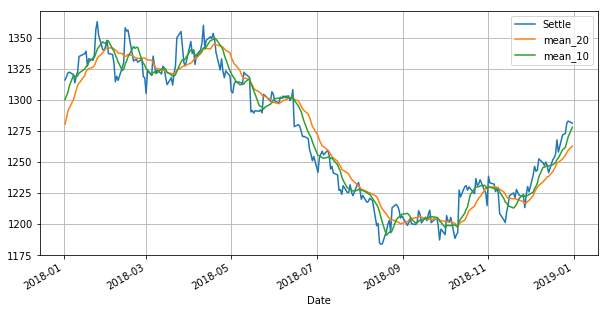

In [166]:
gold = mean_calculation(gold, 20, 10)
gold[['Settle', 'mean_20', 'mean_10']].loc[gold.index > validate_date].plot(figsize=(10,5), grid=True)
savefig('figures/gold_mean_reversal.eps')

In [167]:
nasdaq_amount = 10000/nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

nasdaq = nasdaq.loc[(nasdaq.index <= '2018-12-30')]

In [168]:
nasdaq.loc[(nasdaq.index >= '2018-01-02') & (nasdaq.index < '2018-01-03')].Settle.values[0]

6514.75

In [169]:
nasdaq_amount

1.5349783184312522

In [208]:
interest = 1 + 0.04/12
dct = {}
dct['Interest 4%'] = 20*[10000]
acc = 10000
for i in range(252//20):
    acc *= interest
    dct['Interest 4%'] += 23*[acc]

# dct['Interest 4%'] += [acc*interest]
dct['Interest 4%'] = dct['Interest 4%'][:254]
df = pd.DataFrame.from_dict(dct)

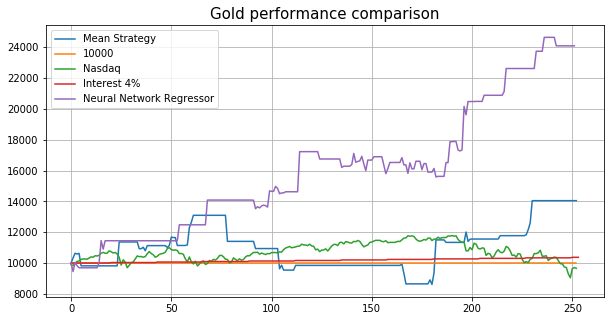

In [209]:
gold_mean = mean_reversal_account(gold.loc[gold.index > validate_date], gold_gains.loc[gold_gains.index > validate_date], trade_days=5)
gold_mean['base'] = gold_mean.account.apply(lambda x: 10000)
gold_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
gold_mean['Nasdaq'] = gold_mean['Nasdaq']*nasdaq_amount

# gold_account_nn = get_performance(gold_clf_reg_nn
ax = pd.concat([gold_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                df[['Interest 4%']],
               gold_account_nn.rename(columns={'account': 'Neural Network Regressor'})[['Neural Network Regressor']],
               ], axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Gold performance comparison', size=15)
savefig('figures/gold_benchmark_performance.eps')

In [171]:
gold_mean.head()

,account,base,Nasdaq
0,10000.0,10000,9894.853985
1,10332.5,10000,9837.292298
2,10636.5,10000,10000.000000
3,10589.0,10000,10107.064738
4,10627.0,10000,10136.229326


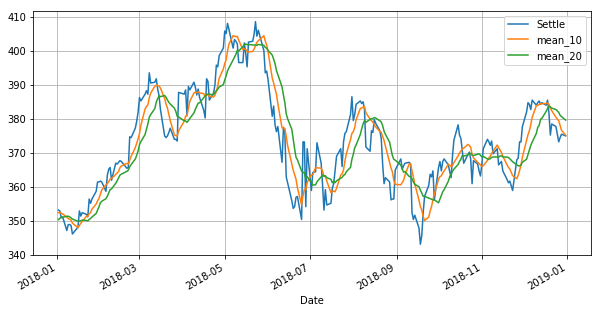

In [172]:
corn = mean_calculation(corn, 20, 10)
corn[['Settle', 'mean_10', 'mean_20']].loc[corn.index > validate_date].plot(figsize=(10,5), grid=True)

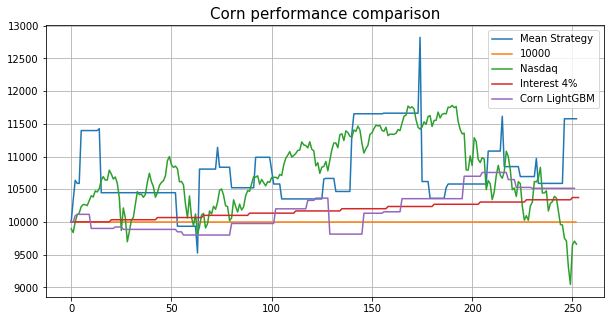

In [210]:
corn_mean = mean_reversal_account(corn.loc[corn.index > validate_date], corn_gains.loc[corn_gains.index > validate_date], trade_days=3)
corn_mean['base'] = corn_mean.account.apply(lambda x: 10000)
corn_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
corn_mean['Nasdaq'] = corn_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([corn_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                df[['Interest 4%']],
               corn_account_lgb.rename(columns={'account': 'Corn LightGBM'})[['Corn LightGBM']]], 
               axis=1).plot(figsize=(10,5), grid=True)

title = ax.set_title('Corn performance comparison', size=15)
savefig('figures/corn_benchmark_performance.eps')

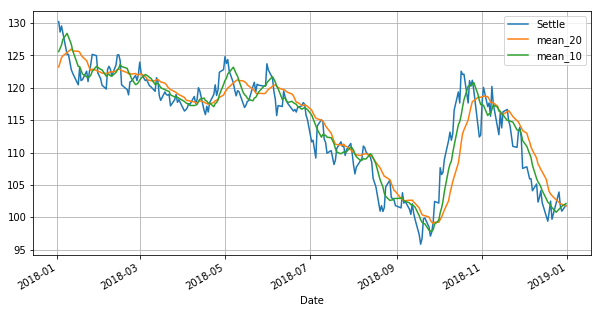

In [174]:
coffee = mean_calculation(coffee, 20, 10)
coffee[['Settle', 'mean_20', 'mean_10']].loc[coffee.index > validate_date].plot(figsize=(10,5), grid=True)

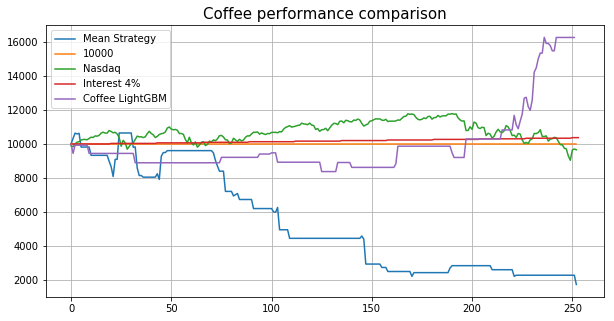

In [211]:
coffee_mean = mean_reversal_account(coffee.loc[coffee.index > validate_date], 
                                    coffee_gains.loc[coffee_gains.index > validate_date], 
                                    trade_days=5)
coffee_mean['base'] = coffee_mean.account.apply(lambda x: 10000)
coffee_mean['Nasdaq'] = nasdaq.Settle.values[-253:]
coffee_mean['Nasdaq'] = coffee_mean['Nasdaq']*nasdaq_amount

ax = pd.concat([coffee_mean.rename(columns={'account': 'Mean Strategy', 'base': '10000'}), 
                df[['Interest 4%']],
                coffee_account_lgb.rename(columns={'account': 'Coffee LightGBM'})[['Coffee LightGBM']],
               ], axis=1).plot(figsize=(10,5), grid=True)
title = ax.set_title('Coffee performance comparison', size=15)
savefig('figures/coffee_benchmark_performance.eps')

# Conclusion

Trading is a difficult ML problem. Out of three compared commodities gold, corn and coffee we were able to predict performance with gold. Other commodities behaved randomly with approximately 0 correlation to the actual volatility.

In the beginning of project, I was thinking of a classifier (short, no trade, long) because it is closer to the usage of model. I tested regressor as well. Regressor works better because there is more information. I tried different loss function when training regressor. I decided to use weighted MSE. This could be further modified for better function omitting errors below threshold.

Gold trading is the most capital intensive with very big stop losses (1000 long, 800 short). This can be problem for trading with $10 000\$$ account.

In case of corn and coffee the data was almost impossible to classify. I suspect more data transformation is needed to get better results.